Presented By : **Rebecca Bayssari**

Presented To : **Nacera Seghouani**


# Préliminaries


## 1.1 Importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
import random
import time
from collections import defaultdict
import community as community_louvain
import node2vec
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request
import zipfile
import gzip
import tarfile
import glob
import shutil

___________________________________________________________________________________________________

## 1.2 Datasets download

Here we download Twitter and Facebooks grpahs

In [2]:
def process_network_dataset(url, filename_base, directed=False, max_nodes=None):

    # File paths
    gz_file = f"{filename_base}.txt.gz"
    txt_file = f"{filename_base}.txt"

    
    # Download dataset if needed
    if not os.path.exists(gz_file):
        print(f"Downloading {filename_base} dataset...")
        try:
            urllib.request.urlretrieve(url, gz_file)
            print(f"{filename_base} download complete.")
        except Exception as e:
            print(f"Error downloading {url}: {e}")
            return None
    else:
        print(f"{filename_base} dataset already exists locally.")

    # Extract dataset if needed
    if not os.path.exists(txt_file):
        print(f"Extracting {filename_base} dataset...")
        try:
            with gzip.open(gz_file, 'rb') as f_in:
                with open(txt_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"{filename_base} extraction complete.")
        except Exception as e:
            print(f"Error extracting {gz_file}: {e}")
            # Clean up potentially corrupted txt file if extraction failed
            if os.path.exists(txt_file):
                 os.remove(txt_file)
            return None
    else:
        print(f"{filename_base} extracted file already exists.")

    # --- Load network ---
    graph_type = nx.DiGraph() if directed else nx.Graph()
    graph = graph_type # Initialize graph

    print(f"Loading {filename_base} network...")
    nodes_loaded = 0
    edges_loaded = 0

    try:
        if max_nodes is not None:
            print(f"Loading up to {max_nodes} nodes...")
            with open(txt_file, 'r') as f:
                for line in f:
                    # Skip comments/headers often starting with '#' or '%'
                    if line.startswith('#') or line.startswith('%'):
                        continue

                    try:
                        # Split line, take first two parts, convert to int
                        u, v = map(int, line.split()[:2])
                    except (ValueError, IndexError):
                        # Skip malformed lines
                        continue

                    # Add the edge 
                    graph.add_edge(u, v)
                    edges_loaded += 1

                    # Check if we've reached the node limit
                    if graph.number_of_nodes() >= max_nodes:
                        print(f"Reached node limit ({max_nodes}). Stopping read.")
                        break # Stop reading the rest of the file
            nodes_loaded = graph.number_of_nodes()
            edges_loaded = graph.number_of_edges()
            print(f"Partial network loaded: {nodes_loaded} nodes, {edges_loaded} edges")

        else:
            print("Loading full network...")
            graph = nx.read_edgelist(txt_file, create_using=graph_type, nodetype=int, comments='#')
            nodes_loaded = graph.number_of_nodes()
            edges_loaded = graph.number_of_edges()
            print(f"Full network loaded: {nodes_loaded} nodes, {edges_loaded} edges")

    except FileNotFoundError:
         print(f"Error: Extracted file {txt_file} not found. Cannot load graph.")
         return None
    except Exception as e:
         print(f"An error occurred during graph loading: {e}")
         return None


    return graph


# URLs for the datasets
twitter_url = "https://snap.stanford.edu/data/twitter_combined.txt.gz"
facebook_url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"

# for testing
MAX_TWITTER_NODES = 5000 

# Process datasets
print("\n--- Processing Twitter ---")
twitter_graph = process_network_dataset(
    twitter_url,
    "twitter_combined",
    directed=True,
    max_nodes=None # Pass the limit here
)

print("\n--- Processing Facebook ---")
facebook_graph = process_network_dataset(
    facebook_url,
    "facebook_combined",
    directed=False,
    max_nodes=None 
)


if twitter_graph and facebook_graph:
    print("\nBoth networks processed ")


--- Processing Twitter ---
twitter_combined dataset already exists locally.
twitter_combined extracted file already exists.
Loading twitter_combined network...
Loading full network...
Full network loaded: 81306 nodes, 1768149 edges

--- Processing Facebook ---
facebook_combined dataset already exists locally.
facebook_combined extracted file already exists.
Loading facebook_combined network...
Loading full network...
Full network loaded: 4039 nodes, 88234 edges

Both networks processed 


Here we can notice that the Twitter graph is way bigger than the Facebook graph. It's important to keep in mind that Twitter is directed.

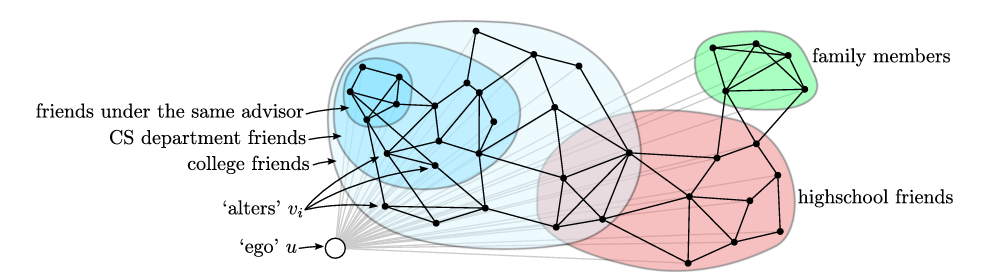

The nodes are users, and the edges are friendships relations between them. For Twitter, edges from u to v are : u follows v, hence why it is directed. 
These graphs originate from a paper where the goal was to discover communities, as seen in the image.


## 1.3 Quick graph analysis

In [8]:
def analyze_graph(graph, name):
    """Print basic information about the given graph."""
    print(f"\n--- {name} Network Analysis ---")

    # Basic statistics
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")

    # Largest connected component
    if name == "Twitter":  # Twitter is directed
        largest_wcc = max(nx.weakly_connected_components(graph), key=len)
        largest_scc = max(nx.strongly_connected_components(graph), key=len)

        wcc_size = len(largest_wcc)
        wcc_subgraph = graph.subgraph(largest_wcc)
        wcc_edges = wcc_subgraph.number_of_edges()

        scc_size = len(largest_scc)
        scc_subgraph = graph.subgraph(largest_scc)
        scc_edges = scc_subgraph.number_of_edges()

        print(f"Nodes in largest WCC: {wcc_size} ({wcc_size/num_nodes:.3f})")
        print(f"Edges in largest WCC: {wcc_edges} ({wcc_edges/num_edges:.3f})")
        print(f"Nodes in largest SCC: {scc_size} ({scc_size/num_nodes:.3f})")
        print(f"Edges in largest SCC: {scc_edges} ({scc_edges/num_edges:.3f})")
    else:  # Facebook is undirected
        largest_cc = max(nx.connected_components(graph), key=len)
        cc_size = len(largest_cc)
        cc_subgraph = graph.subgraph(largest_cc)
        cc_edges = cc_subgraph.number_of_edges()

        print(f"Nodes in largest CC: {cc_size} ({cc_size/num_nodes:.3f})")
        print(f"Edges in largest CC: {cc_edges} ({cc_edges/num_edges:.3f})")

    # Clustering and triangles for both graphs
    # For directed graph (Twitter), convert to undirected for these metrics
    if name == "Twitter":
        undirected_graph = graph.to_undirected()
        avg_clustering = nx.average_clustering(undirected_graph)
    else:  # Facebook
        avg_clustering = nx.average_clustering(graph)


    print(f"Average clustering coefficient: {avg_clustering:.4f}")


# Analyze both networks
analyze_graph(twitter_graph, "Twitter")
analyze_graph(facebook_graph, "Facebook")


--- Twitter Network Analysis ---
Nodes: 81306
Edges: 1768149
Nodes in largest WCC: 81306 (1.000)
Edges in largest WCC: 1768149 (1.000)
Nodes in largest SCC: 68413 (0.841)
Edges in largest SCC: 1685163 (0.953)
Average clustering coefficient: 0.5653

--- Facebook Network Analysis ---
Nodes: 4039
Edges: 88234
Nodes in largest CC: 4039 (1.000)
Edges in largest CC: 88234 (1.000)
Average clustering coefficient: 0.6055


Good news, we find the same data that the Stanford pages where we found the graphs give. Let's give a reminder on those definition to better understand what this means.

**CC (Connected Component)**: A subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph.

**WCC (Weakly Connected Component):** A maximal subgraph such that for any two vertices u and v in the subgraph, there is a path between u and v *ignoring the direction of the edges.*

**SCC (Strongly Connected Component):** A maximal subgraph such that for every pair of vertices u and v in the subgraph, there is a *directed* path from u to v and a *directed* path from v to u.

Both networks are highly connected overall.
The entire Facebook network is connected since all the nodes and edges are in the largest CC, and it's the same for Twitter, if you ignore the direction of the edges. But if you take into account that there are followers and users that don't necessarely follow back, not all nodes are in the largest SCC. 16% of users follow people in the core (or elsewhere) but aren't followed back enough to be part of that mutually reachable group.

Both networks show high levels of clustering, indicating strong community structures.



## 1.4 Graphs visualisation


Visualizing Twitter network...
Graph too large, sampling 20000 nodes for visualization...


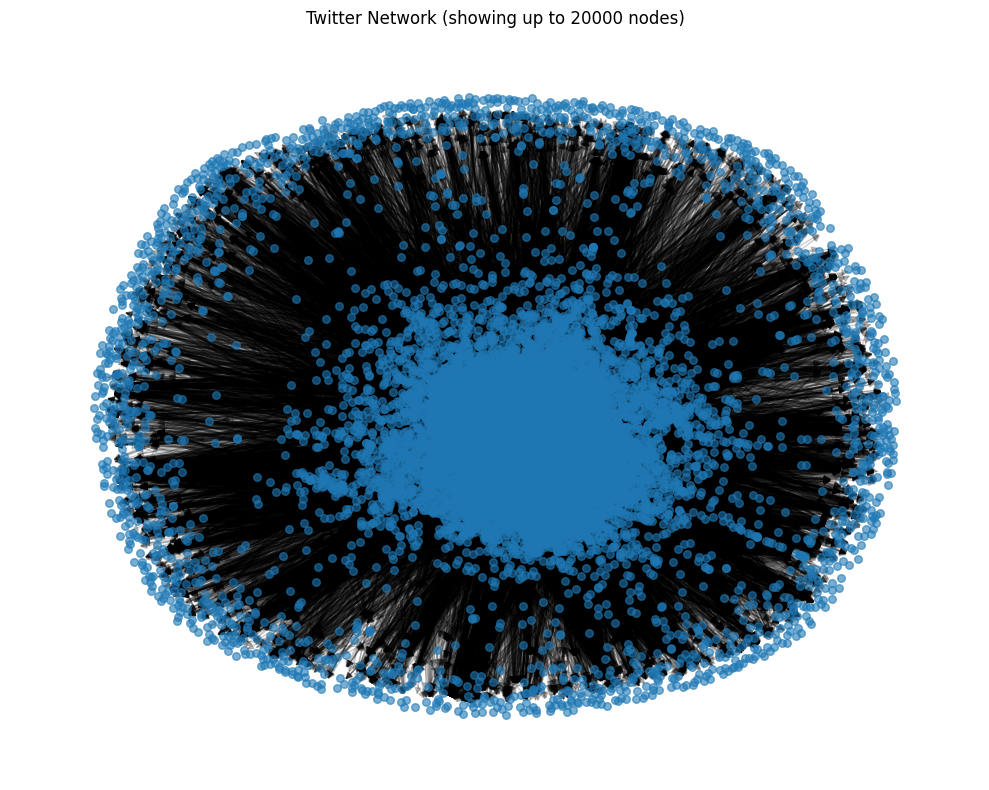


Visualizing Facebook network...
Graph too large, sampling 4000 nodes for visualization...


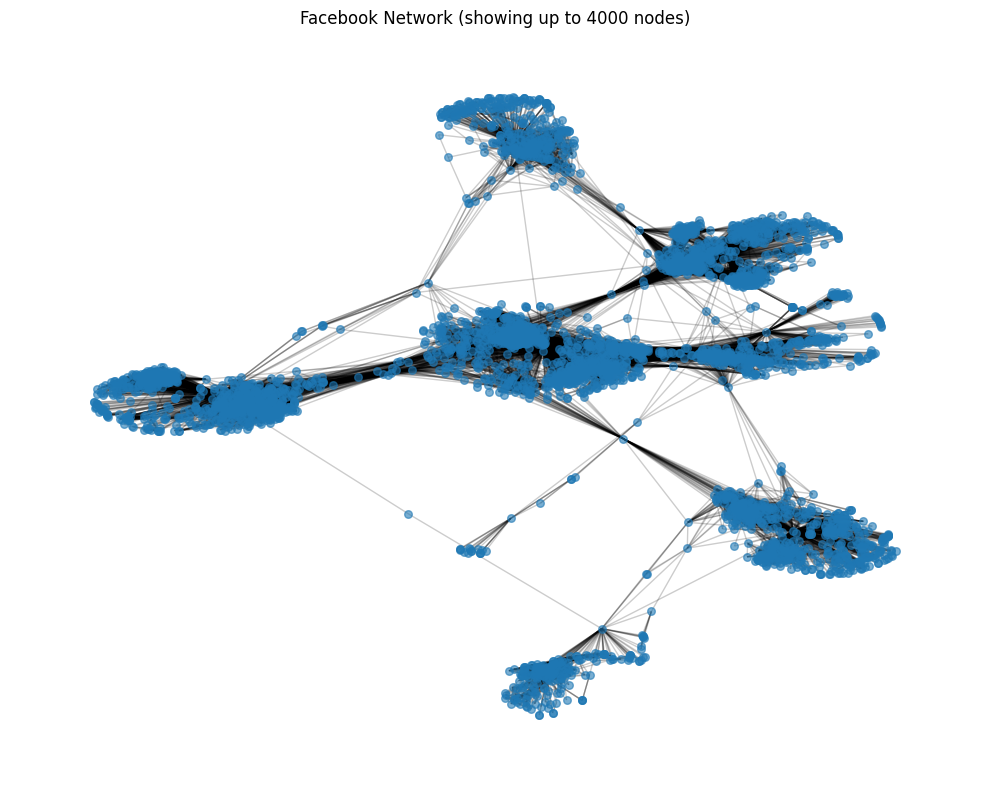

In [26]:
import matplotlib.pyplot as plt

def display_graph(graph, name, max_nodes=3000):
    """
    Display a network graph using matplotlib.
    Limits the visualization to max_nodes to avoid overwhelming the display.
    """
    print(f"\nVisualizing {name} network...")

    # Create a new figure
    plt.figure(figsize=(10, 8))

    # If the graph is too large, take a sample
    if graph.number_of_nodes() > max_nodes:
        print(f"Graph too large, sampling {max_nodes} nodes for visualization...")
        nodes = list(graph.nodes())[:max_nodes]
        subgraph = graph.subgraph(nodes)
    else:
        subgraph = graph

    # Set up layout - spring layout generally works well for small to medium graphs
    pos = nx.spring_layout(subgraph, seed=42)  # Seed for reproducibility

    # Draw the network
    nx.draw_networkx_nodes(subgraph, pos, node_size=30, alpha=0.6)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2)

    # Add title and remove axes
    plt.title(f"{name} Network (showing up to {max_nodes} nodes)")
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Display both networks
display_graph(twitter_graph, "Twitter",max_nodes=20000)
display_graph(facebook_graph, "Facebook", max_nodes=4000)

We find again that for Twitter, we have a strongly connected core (probably the SCC) with sparse nodes in the periphery that are less connected. Plus, the arrows are from the core to the nodes.

Facebook shows several communities with strongly connected members. These communities still are connected to other communities, even if the edges are more sparse, so it is logical there is one CC. 


Visualizing Twitter network with SCC highlighted...
Graph too large, sampling 5000 nodes for visualization...


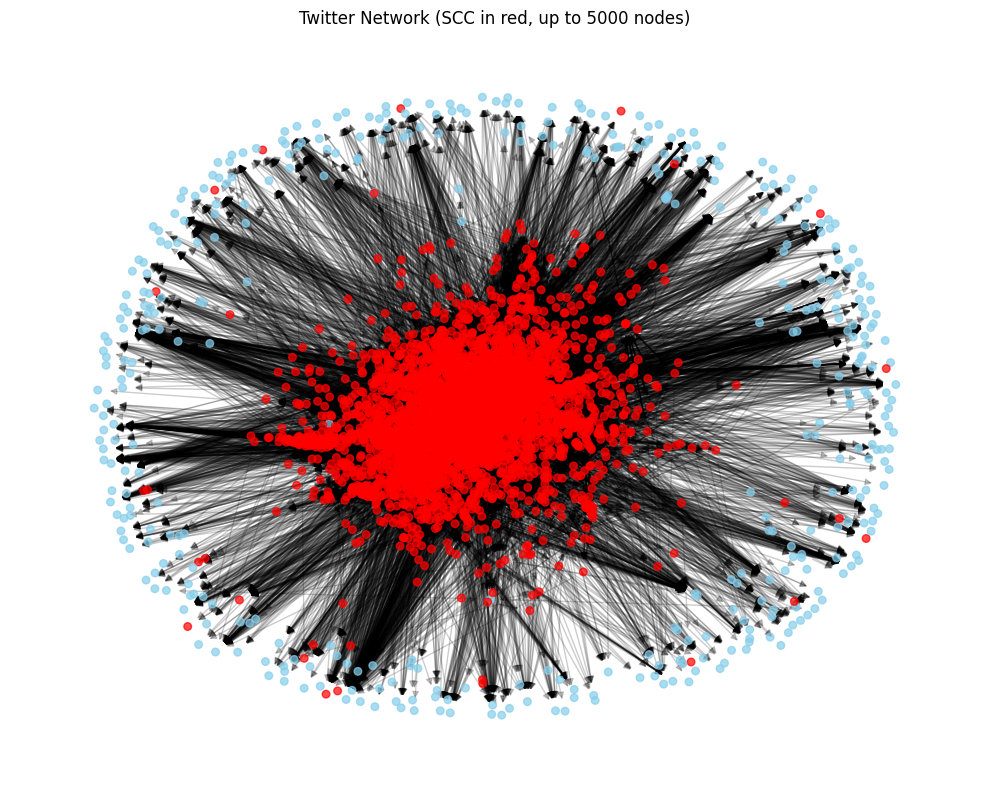

In [27]:
def display_graph_with_scc(graph, name, max_nodes=5000):
    """
    Display the network graph, highlighting the largest SCC for directed graphs.
    """
    import matplotlib.pyplot as plt
    import networkx as nx

    print(f"\nVisualizing {name} network with SCC highlighted...")

    # For Twitter (directed), find the largest SCC
    if graph.is_directed():
        largest_scc = max(nx.strongly_connected_components(graph), key=len)
        scc_nodes = set(largest_scc)
    else:
        scc_nodes = set()

    # Sample nodes if too large
    if graph.number_of_nodes() > max_nodes:
        print(f"Graph too large, sampling {max_nodes} nodes for visualization...")
        nodes = list(graph.nodes())[:max_nodes]
        subgraph = graph.subgraph(nodes)
        scc_nodes = scc_nodes.intersection(subgraph.nodes)
    else:
        subgraph = graph

    pos = nx.spring_layout(subgraph, seed=42)

    # Color nodes: SCC in red, others in blue
    node_colors = [
        'red' if node in scc_nodes else 'skyblue'
        for node in subgraph.nodes()
    ]

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=30, alpha=0.7)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
    plt.title(f"{name} Network (SCC in red, up to {max_nodes} nodes)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

display_graph_with_scc(twitter_graph, "Twitter")


Color nodes: SCC in red, others in blue
It's what we were expecting...

# Graph centralities

#### What we added :
Plots to better see the centralities values.


--- Eigenvector Centrality Analysis: Twitter ---

[Attempting eigenvector centrality on the full graph...]
Successfully computed eigenvector centrality for the full graph.

[Computing eigenvector centrality on the largest strongly connected component...]
Directed graph: Using largest SCC.

Top 5 nodes by eigenvector centrality:
Node 40981798: 0.202486
Node 22462180: 0.192295
Node 43003845: 0.190751
Node 34428380: 0.190513
Node 31331740: 0.130039
Plotting Note: X-axis shows node indices as 68413 plotted nodes are too many to label individually.


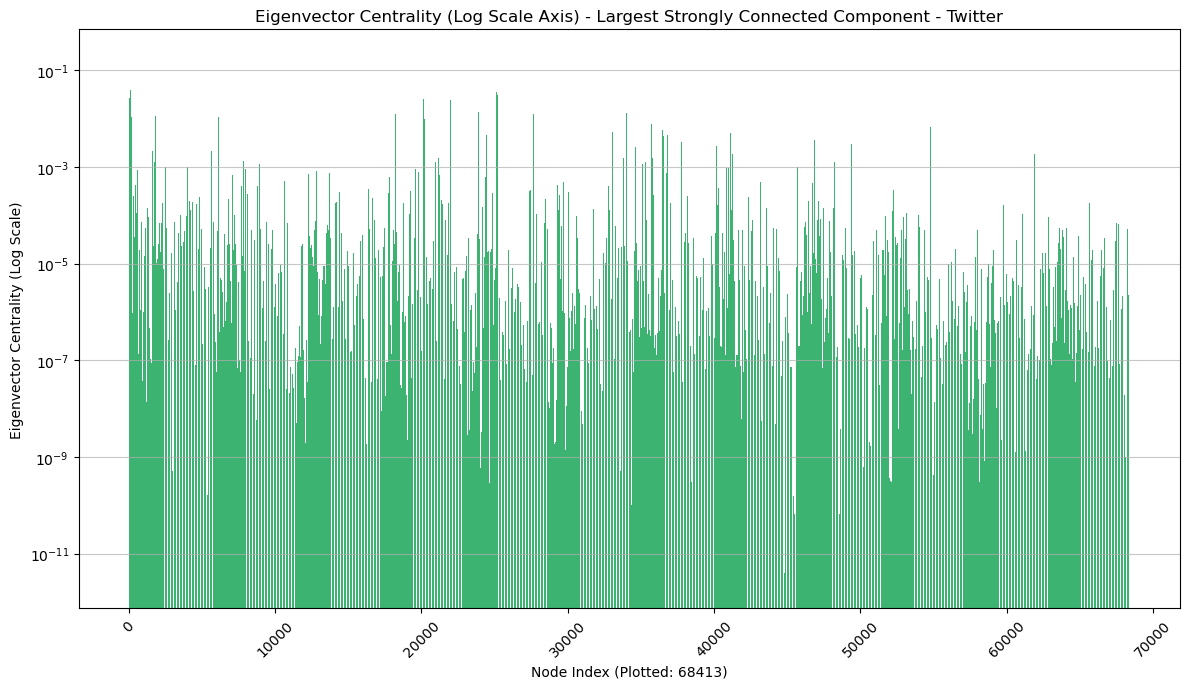


--- Eigenvector Centrality Analysis: Facebook ---

[Attempting eigenvector centrality on the full graph...]
Successfully computed eigenvector centrality for the full graph.

[Computing eigenvector centrality on the largest strongly connected component...]
Undirected graph: Using largest CC.

Top 5 nodes by eigenvector centrality:
Node 1912: 0.095407
Node 2266: 0.086983
Node 2206: 0.086052
Node 2233: 0.085173
Node 2464: 0.084279
Plotting Note: X-axis shows node indices as 4039 plotted nodes are too many to label individually.


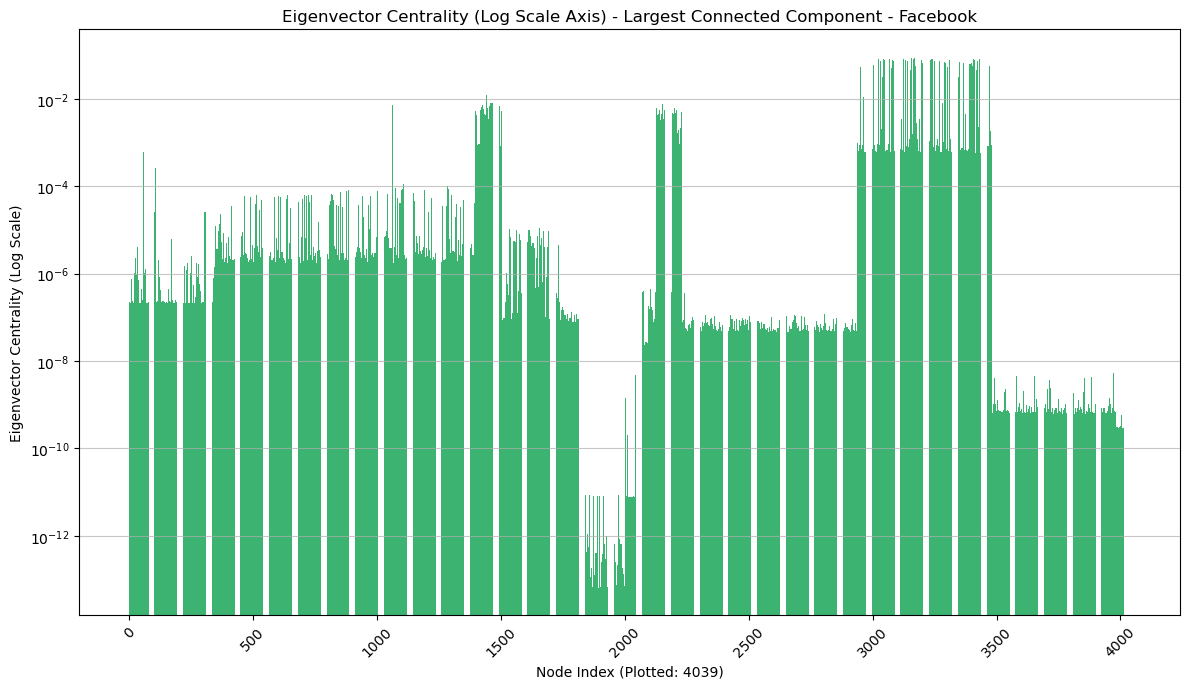

In [12]:
# @title 1- EigenVector Centrality
import networkx as nx

def analyze_eigen_centrality(graph, name):
    print(f"\n--- Eigenvector Centrality Analysis: {name} ---")

    # First try: Eigenvector centrality on full graph
    print("\n[Attempting eigenvector centrality on the full graph...]")
    try:
        centrality_full = nx.eigenvector_centrality(graph, max_iter=500, tol=1e-06)
        print("Successfully computed eigenvector centrality for the full graph.")
    except nx.PowerIterationFailedConvergence as e:
        print(f"Failed to compute eigenvector centrality on full graph: {e}")
        #print("Reason: Eigenvector centrality requires a strongly connected directed graph.")

    #Now let's try a different approach
    print("\n[Computing eigenvector centrality on the largest strongly connected component...]")
    if graph.is_directed():
        # Compute SCC for directed graphs (like Twitter)
        largest_scc = max(nx.strongly_connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_scc).copy()
        print("Directed graph: Using largest SCC.")
    else:
        # Compute CC for undirected graphs (like Facebook)
        largest_cc = max(nx.connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc).copy()
        print("Undirected graph: Using largest CC.")

    centrality = nx.eigenvector_centrality(subgraph, max_iter=500, tol=1e-06)

    top_5 = sorted(centrality.items(), key=lambda item: item[1], reverse=True)[:5]
    print("\nTop 5 nodes by eigenvector centrality:")
    for node, cent in top_5:
        print(f"Node {node}: {cent:.6f}")

    # --- Plotting Centrality (Y-Axis Log Scale) ---
    if centrality:
        all_nodes = list(centrality.keys())
        all_values = list(centrality.values())

        # --- Filter out non-positive values for log scale ---
        nodes_to_plot = []
        values_to_plot = []
        zero_value_nodes = []

        for node, value in zip(all_nodes, all_values):
            if value > 0:
                nodes_to_plot.append(node)
                values_to_plot.append(value)
            else:
                zero_value_nodes.append(node)

        if zero_value_nodes:
            print(f"\nPlotting Note: Log scale ignores {len(zero_value_nodes)} node(s) with zero or non-positive centrality.")

        if not values_to_plot:
            print("\nNo nodes with positive centrality found. Cannot generate log scale plot.")
        else:
            try:
                plt.figure(figsize=(12, 7)) # Slightly taller figure might be good

                # Create bar chart using the *original positive* values
                num_nodes_plotted = len(nodes_to_plot)
                use_labels = num_nodes_plotted < 50
                plt.bar(range(num_nodes_plotted), values_to_plot,
                        tick_label=[str(n) for n in nodes_to_plot] if use_labels else None,
                        color='mediumseagreen') # Yet another color

                # <<< --- Set Y-axis to Logarithmic Scale --- >>>
                plt.yscale('log')

                plt.xlabel("Node ID" if use_labels else f"Node Index (Plotted: {num_nodes_plotted})")
                plt.ylabel("Eigenvector Centrality (Log Scale)") 

                # Determine component type for title based on graph type
                component_desc = "Largest Strongly Connected Component" if graph.is_directed() else "Largest Connected Component"
                plt.title(f"Eigenvector Centrality (Log Scale Axis) - {component_desc} - {name}") 

                if use_labels:
                    plt.xticks(rotation=90, fontsize=8) 
                else:
                    if not use_labels:
                        print(f"Plotting Note: X-axis shows node indices as {num_nodes_plotted} plotted nodes are too many to label individually.")
                    plt.xticks(rotation=45)

                plt.grid(axis='y', linestyle='-', alpha=0.7) 
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"\nError during log scale plotting: {e}")

    else:
        print("\nNo centrality data available from the component to plot.")
   


# Iterating for both graphs:
graphs = {
    "Twitter": twitter_graph,
    "Facebook": facebook_graph
}

for name, graph in graphs.items():
    analyze_eigen_centrality(graph, name)




Analyzing the results :

 First , we decided to compute **the eigenvector centrality** because not only it measures a node’s importance but it also take into consideration the importance of its neighbors . As said in course , a high eigenvector score means that a node is connected to
 many nodes which themselves have high scores.

  As we can see, we tried at first the eigenvector centrality on the full graph even though its not really recommended due to the risk of convergence but in our case, Eigenvector centrality was successfully computed on the full graph, indicating that the algorithm converged on both graphs despite the directed Twitter network not being fully strongly connected. This suggests that the graph's structure is sufficiently well-connected to allow meaningful centrality scores.
  
  To get more reliable centrality results , we applied to the directed graph (Twitter) the largest strongly connected component ( meaning all nodes in this component are mutually reachable) and to the undirected graph(Facebook) the largest connected component (CC).

 **For Twitter Network:**
  The centrality scores are relatively high (ranging from ~0.13 to ~0.20), with a significant drop after the fourth node.The centrality values (0.2, 0.19, etc.) indicate strong relative influence , likely a highly followed account. The fifth node (31331740, score: 0.130) is less central, indicating a gap in influence between the top 4 and the rest. In conclusion , the network is likely dominated by a small group of highly influential accounts.

 **For Facebook Network:**
Scores are lower (ranging from ~0.084 to ~0.095) and more evenly distributed compared to Twitter. Lower absolute centrality values  compared to Twitter are due to network size, density, and connectivity patterns . Node 1912 (score: 0.095) is the most central, likely a well-connected individual in the social circle. The scores decrease gradually. As a conclusion , The network has a more evenly distributed influence, with no single dominant node.


--- Degree Centrality Analysis: Twitter ---
[Directed Graph] Calculating in-degree and out-degree centrality...

Top 5 nodes by in-degree centrality:
Node 115485051: 0.041609
Node 40981798: 0.039555
Node 43003845: 0.033639
Node 813286: 0.032556
Node 22462180: 0.030392

Plotting Note (In-Degree Centrality): Log scale ignores 1 node(s) with zero or non-positive centrality.
Plotting Note (In-Degree Centrality): X-axis shows indices for 81305 nodes.


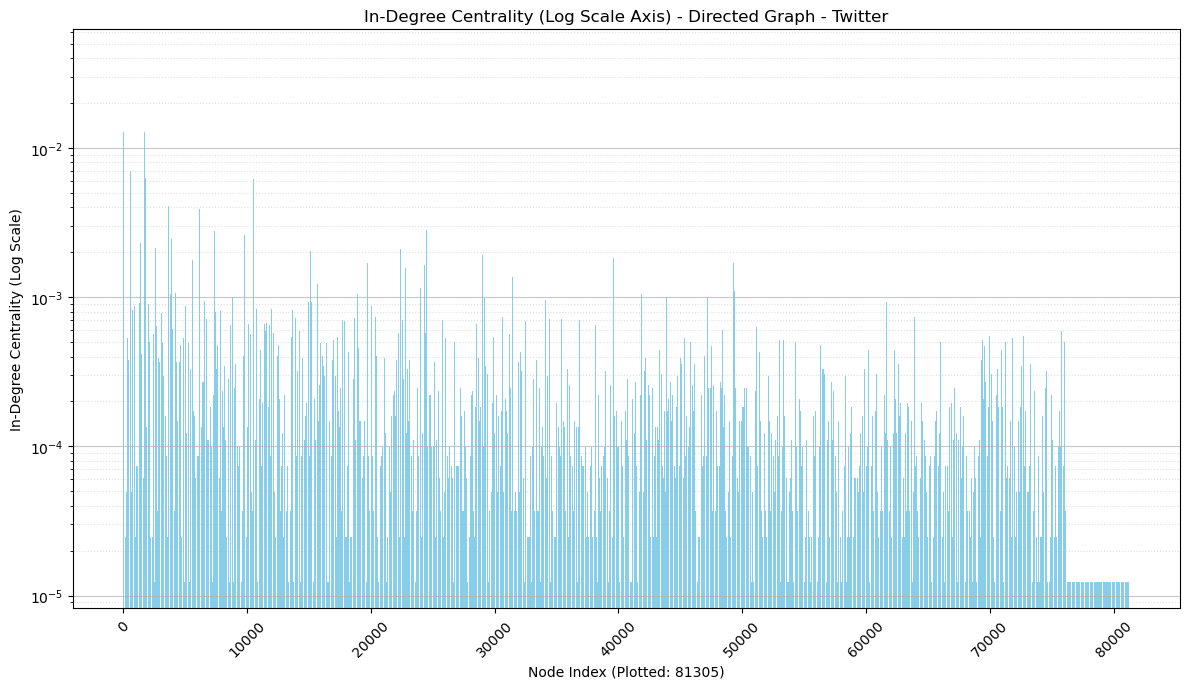


Top 5 nodes by out-degree centrality:
Node 59804598: 0.014821
Node 3359851: 0.014243
Node 813286: 0.013665
Node 5442012: 0.013148
Node 18581803: 0.011438

Plotting Note (Out-Degree Centrality): Log scale ignores 11209 node(s) with zero or non-positive centrality.
Plotting Note (Out-Degree Centrality): X-axis shows indices for 70097 nodes.


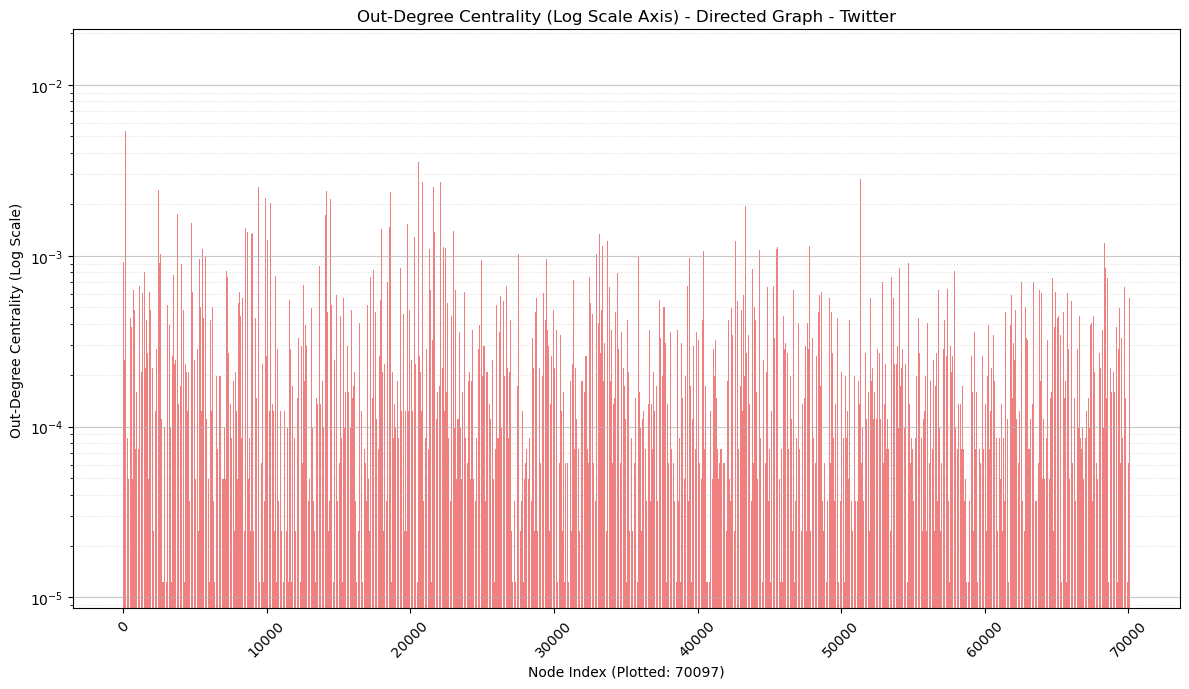


--- Degree Centrality Analysis: Facebook ---
[Undirected Graph] Calculating degree centrality...

Top 5 nodes by degree centrality:
Node 107: 0.258791
Node 1684: 0.196137
Node 1912: 0.186974
Node 3437: 0.135463
Node 0: 0.085934
Plotting Note (Degree Centrality): X-axis shows indices for 4039 nodes.


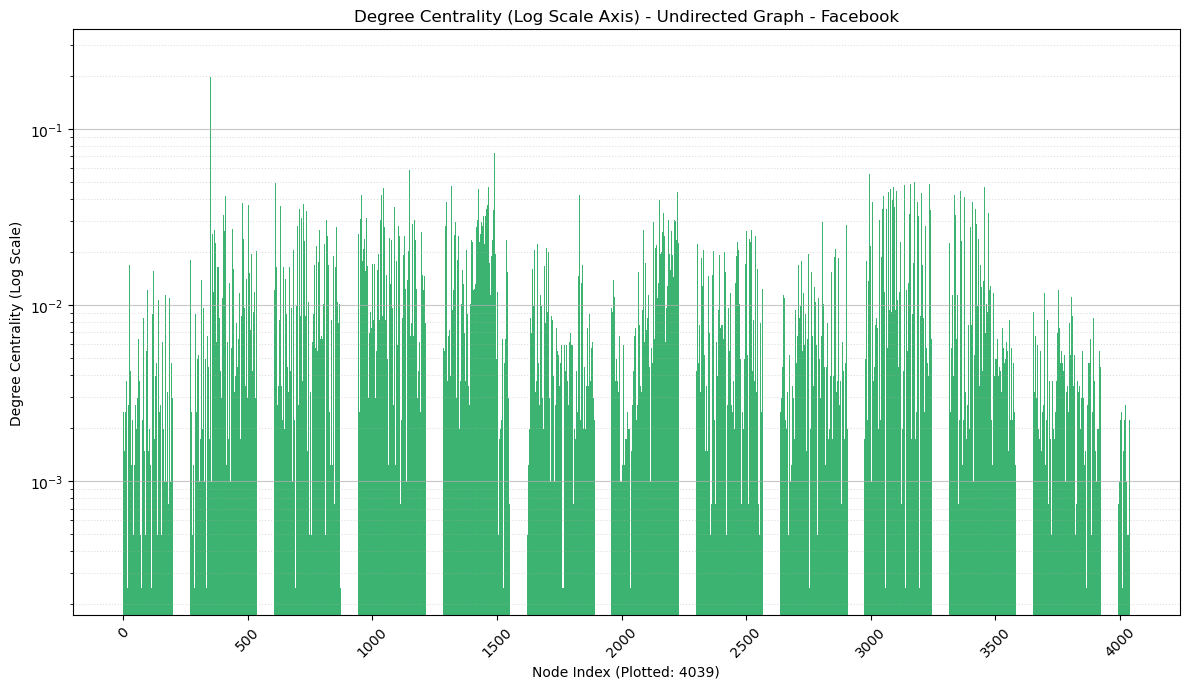


--- Analysis Complete ---


In [27]:
def analyze_degree_centrality(graph, name):
    print(f"\n--- Degree Centrality Analysis: {name} ---")

    # --- Nested plotting function defined *inside* analyze_degree_centrality ---
    def _plot_log_scale(centrality_dict, centrality_label, graph_type_desc):
        """Nested helper to plot centrality on a log scale."""
        if not centrality_dict:
            print(f"\nNo data provided for {centrality_label} to plot.")
            return

        all_nodes = list(centrality_dict.keys())
        all_values = list(centrality_dict.values())

        # Filter out non-positive values for log scale
        nodes_to_plot = []
        values_to_plot = []
        zero_value_nodes = []

        for node, value in zip(all_nodes, all_values):
            if value > 0:
                nodes_to_plot.append(node)
                values_to_plot.append(value)
            else:
                zero_value_nodes.append(node)

        if zero_value_nodes:
            print(f"\nPlotting Note ({centrality_label}): Log scale ignores {len(zero_value_nodes)} node(s) with zero or non-positive centrality.")

        if not values_to_plot:
            print(f"\nNo nodes with positive {centrality_label} found. Cannot generate log scale plot.")
            return # Stop if nothing to plot

        try:
            plt.figure(figsize=(12, 7))
            num_nodes_plotted = len(nodes_to_plot)
            use_labels = num_nodes_plotted < 50
            # Assign color based on centrality type for visual distinction
            plot_color = 'skyblue' if 'In-Degree' in centrality_label else 'lightcoral' if 'Out-Degree' in centrality_label else 'mediumseagreen'
            plt.bar(range(num_nodes_plotted), values_to_plot,
                    tick_label=[str(n) for n in nodes_to_plot] if use_labels else None,
                    color=plot_color)

            plt.yscale('log')
            plt.xlabel("Node ID" if use_labels else f"Node Index (Plotted: {num_nodes_plotted})")
            plt.ylabel(f"{centrality_label} (Log Scale)")
            plt.title(f"{centrality_label} (Log Scale Axis) - {graph_type_desc} - {name}")

            if use_labels:
                plt.xticks(rotation=90, fontsize=8)
            else:
                if not use_labels:
                     print(f"Plotting Note ({centrality_label}): X-axis shows indices for {num_nodes_plotted} nodes.")
                plt.xticks(rotation=45)

            plt.grid(axis='y', which='major', linestyle='-', alpha=0.7)
            plt.grid(axis='y', which='minor', linestyle=':', alpha=0.4)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"\nError during {centrality_label} log scale plotting: {e}")
    # --- End of nested plotting function ---


    # --- Main logic of analyze_degree_centrality ---
    if graph.is_directed():
        print("[Directed Graph] Calculating in-degree and out-degree centrality...")
        graph_type_desc = "Directed Graph" # Description for plot titles

        # Calculate In-Degree
        in_deg_cent = nx.in_degree_centrality(graph)
        top_in = sorted(in_deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nTop 5 nodes by in-degree centrality:")
        for node, score in top_in:
            print(f"Node {node}: {score:.6f}")
        # Plot In-Degree using the nested function
        _plot_log_scale(in_deg_cent, "In-Degree Centrality", graph_type_desc)

        # Calculate Out-Degree
        out_deg_cent = nx.out_degree_centrality(graph)
        top_out = sorted(out_deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nTop 5 nodes by out-degree centrality:")
        for node, score in top_out:
            print(f"Node {node}: {score:.6f}")
        # Plot Out-Degree using the nested function
        _plot_log_scale(out_deg_cent, "Out-Degree Centrality", graph_type_desc)

    else: # Undirected Graph
        print("[Undirected Graph] Calculating degree centrality...")
        graph_type_desc = "Undirected Graph" # Description for plot titles

        # Calculate Degree
        deg_cent = nx.degree_centrality(graph)
        top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nTop 5 nodes by degree centrality:")
        for node, score in top_deg:
            print(f"Node {node}: {score:.6f}")
        # Plot Degree using the nested function
        _plot_log_scale(deg_cent, "Degree Centrality", graph_type_desc)



# Run analysis
for name, graph in graphs.items():
    analyze_degree_centrality(graph, name)

print("\n--- Analysis Complete ---")

*For directed graphs (Twitter)*, we distinguish between:

**In-degree centrality**: Number of incoming edges (followers). High in-degree = influential accounts. the values are close, these are likely high-profile accounts. Node 40981798 also appeared in the top eigenvector centrality, confirming its influence.

**Out-degree centrality**: Number of outgoing edges (accounts followed). High out-degree = accounts that follow many others. The first value indicates then that the its an highly active user, follows or interacts with many. We notice that the node 813286 appears in both lists, suggesting it is both followed and follows many

*For undirected graphs (Facebook)*, we only calculate the total degree centrality which means in this case the number of connections . It reflects the	Social connectivity / integration which means that for example the node 107 is very well connected (has many friends). Node 1912 also appeared in eigenvector centrality, meaning it’s not just well-connected but also connected to other well-connected people.




--- Betweenness Centrality Analysis: Twitter ---
[Approximated version using 1000 samples]

Top 5 nodes by betweenness centrality:
Node 813286: 0.159765
Node 17093617: 0.062715
Node 15846407: 0.052027
Node 3359851: 0.045858
Node 12611642: 0.029365

Plotting Note: Log scale ignores 31800 node(s) with zero or non-positive centrality.
Plotting Note: X-axis shows node indices as 49506 plotted nodes are too many to label individually.


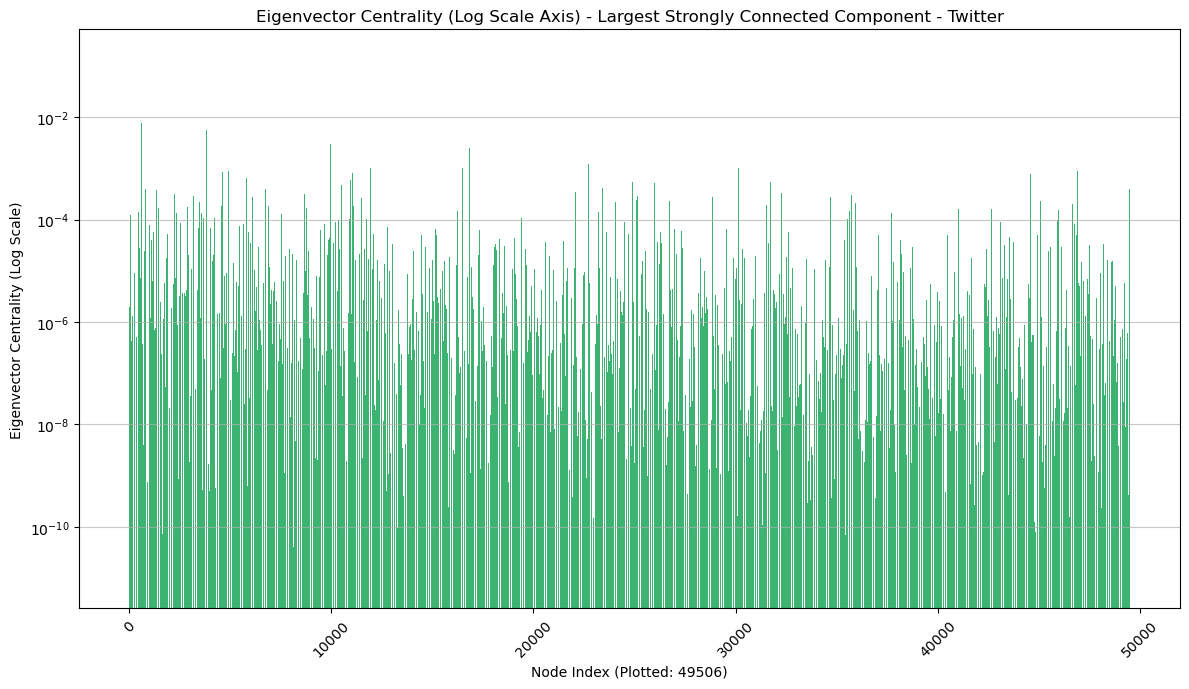


--- Betweenness Centrality Analysis: Facebook ---
[Exact version]

Top 5 nodes by betweenness centrality:
Node 107: 0.480518
Node 1684: 0.337797
Node 3437: 0.236115
Node 1912: 0.229295
Node 1085: 0.149015

Plotting Note: Log scale ignores 342 node(s) with zero or non-positive centrality.
Plotting Note: X-axis shows node indices as 3697 plotted nodes are too many to label individually.


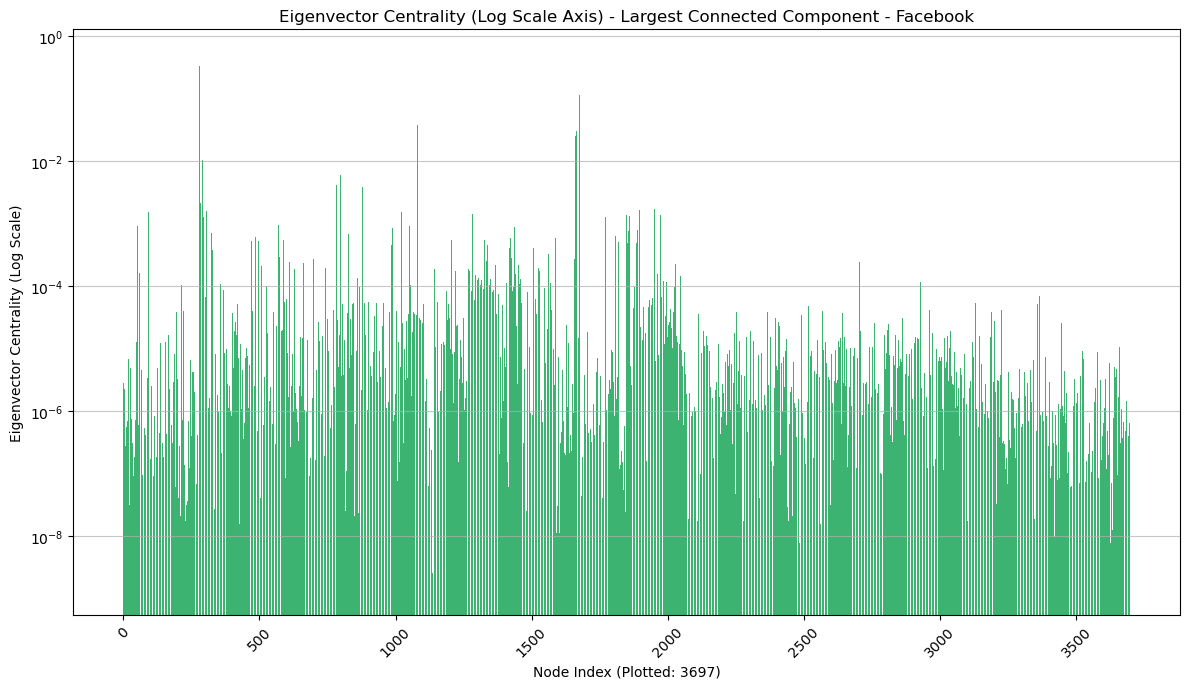

In [28]:
# @title 3- Betweenness Centrality
import networkx as nx

def analyze_betweenness_centrality(graph, name, k=None):
    print(f"\n--- Betweenness Centrality Analysis: {name} ---")

    # For large graphs, use approximation (if k is set)
    if k:
        print(f"[Approximated version using {k} samples]")
        bet_cent = nx.betweenness_centrality(graph, k=k, normalized=True, seed=42)
    else:
        print("[Exact version]")
        bet_cent = nx.betweenness_centrality(graph, normalized=True)

    # Get top 5 nodes by betweenness centrality
    top_5 = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\nTop 5 nodes by betweenness centrality:")
    for node, score in top_5:
        print(f"Node {node}: {score:.6f}")

# Apply to both graphs
# For Twitter (large graph) → use k for approximation
# For Facebook (small graph) → compute exact

# --- Plotting Centrality (Y-Axis Log Scale) ---
    if bet_cent:
        all_nodes = list(bet_cent.keys())
        all_values = list(bet_cent.values())

        # --- Filter out non-positive values for log scale ---
        nodes_to_plot = []
        values_to_plot = []
        zero_value_nodes = []

        for node, value in zip(all_nodes, all_values):
            if value > 0:
                nodes_to_plot.append(node)
                values_to_plot.append(value)
            else:
                zero_value_nodes.append(node)

        if zero_value_nodes:
            print(f"\nPlotting Note: Log scale ignores {len(zero_value_nodes)} node(s) with zero or non-positive centrality.")

        if not values_to_plot:
            print("\nNo nodes with positive centrality found. Cannot generate log scale plot.")
        else:
            try:
                plt.figure(figsize=(12, 7)) # Slightly taller figure might be good

                # Create bar chart using the *original positive* values
                num_nodes_plotted = len(nodes_to_plot)
                use_labels = num_nodes_plotted < 50
                plt.bar(range(num_nodes_plotted), values_to_plot,
                        tick_label=[str(n) for n in nodes_to_plot] if use_labels else None,
                        color='mediumseagreen') # Yet another color

                # <<< --- Set Y-axis to Logarithmic Scale --- >>>
                plt.yscale('log')

                plt.xlabel("Node ID" if use_labels else f"Node Index (Plotted: {num_nodes_plotted})")
                plt.ylabel("Eigenvector Centrality (Log Scale)") 

                # Determine component type for title based on graph type
                component_desc = "Largest Strongly Connected Component" if graph.is_directed() else "Largest Connected Component"
                plt.title(f"Eigenvector Centrality (Log Scale Axis) - {component_desc} - {name}") 

                if use_labels:
                    plt.xticks(rotation=90, fontsize=8) 
                else:
                    if not use_labels:
                        print(f"Plotting Note: X-axis shows node indices as {num_nodes_plotted} plotted nodes are too many to label individually.")
                    plt.xticks(rotation=45)

                plt.grid(axis='y', linestyle='-', alpha=0.7) 
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"\nError during log scale plotting: {e}")

    else:
        print("\nNo centrality data available from the component to plot.")

graphs = {
    "Twitter": twitter_graph,
    "Facebook": facebook_graph
}

for name, graph in graphs.items():
    if name == "Twitter":
        analyze_betweenness_centrality(graph, name, k=1000)  # use approximation
    else:
        analyze_betweenness_centrality(graph, name)  # exact


We decided we want to implement **the betweenness centrality** because it differs from the other approaches ; it dont really measures the influence of the node but its useful for detecting influential connectors, even if they’re not the most connected because it measures how often a node appears on the shortest paths between other nodes. A node with higher betweenness centrality would have more control over the network, because more
 information will pass through that node.

*Analyzing the results for the twitter network:*

High betweenness nodes control information flow and connect different communities.Node 813286 Dominates: Its betweenness (0.16) is 2.5× higher than the next node, indicating it is a **critical bridge** in the network. This node also appeared in both in-degree and out-degree top lists. That shows that it's both structurally central and well-connected. That results to : Removing Node 813286 could fragment the network. Nodes like 17093617 and 15846407 also play a significant bridging role, though to a lesser extent. The node  3359851 also had high out-degree centrality; It reaches out to many others and plays a key structural role by connecting otherwise separated users or communities.

**These nodes may not be the most followed or active, but they sit in strategic structural positions, making them influential for connectivity, not popularity.**

*Analyzing the results for the facebook network:*

Node 107 is a Super-Bridge: Its betweenness (0.48) is exceptionally high, meaning nearly half of all shortest paths pass through it.This aligns with its top degree centrality (0.26), confirming it is both well-connected and critical for flow. The top 3 nodes ( 1684, 3437, 1912) also appeared in degree centrality, showing that social hubs double as bridges. Node 1912 is notable for high eigenvector centrality, meaning it connects influential people and is structurally important at the same time.


# 2. Community detection

## 2.1 Louvain approach

For the first approach of community detetction , we decided to implement the **louvain algorithm** , a simple method to extract the community structure of a network. This is a  greedy, heuristic method based on Local Modularity Optimization followed by Network Aggregation.




*** Step 1: Detecting Communities and Calculating Metrics ***

 Louvain Community Detection: Twitter Graph
Graph Info: 81306 nodes, 1768149 edges
Running Louvain algorithm...
Louvain algorithm completed.

Number of communities detected: 70
Calculating quality metrics...
  Modularity of the partition: 0.8034
  Coverage of the partition: 0.8732
Quality metric calculation finished.
Calculating per-community metrics (size, density, conductance, mod_contrib)...
Per-community metric calculation finished.

Community Size Statistics:
  Min size:    10
  Max size:    11029
  Mean size:   1161.51
  Median size: 374

Top 5 community sizes:
  Rank 1: 11029 nodes
  Rank 2: 10259 nodes
  Rank 3: 7468 nodes
  Rank 4: 6292 nodes
  Rank 5: 4216 nodes

--- End of Community Detection: Twitter ---

 Louvain Community Detection: Facebook Graph
Graph Info: 4039 nodes, 88234 edges
Running Louvain algorithm...
Louvain algorithm completed.

Number of communities detected: 16
Calculating quality metrics...
  M

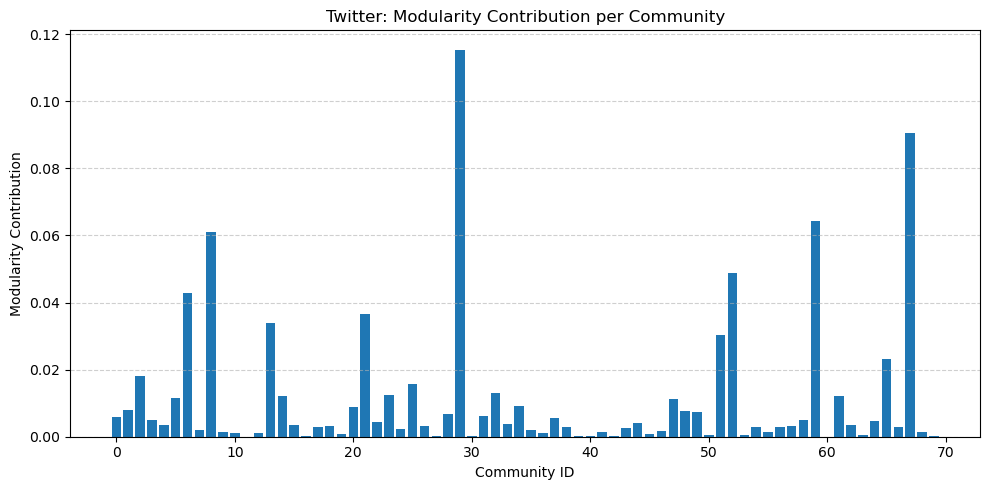

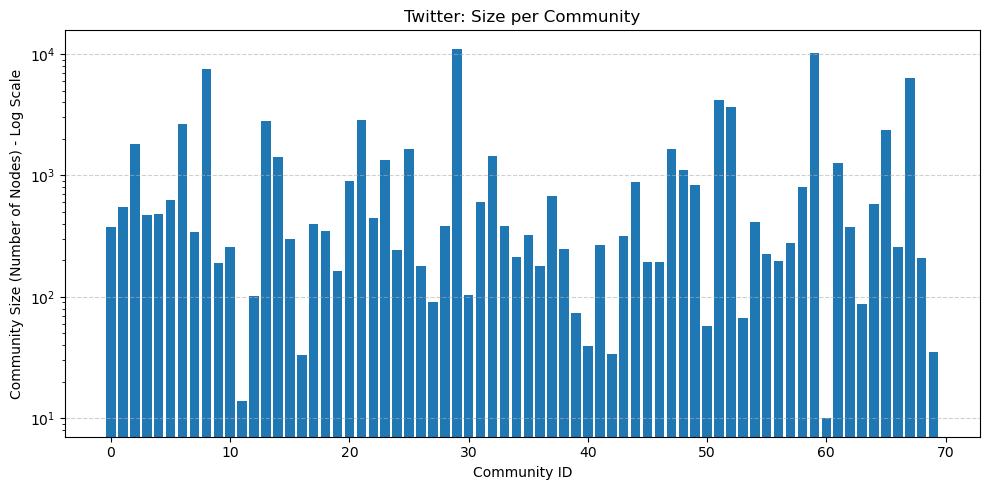

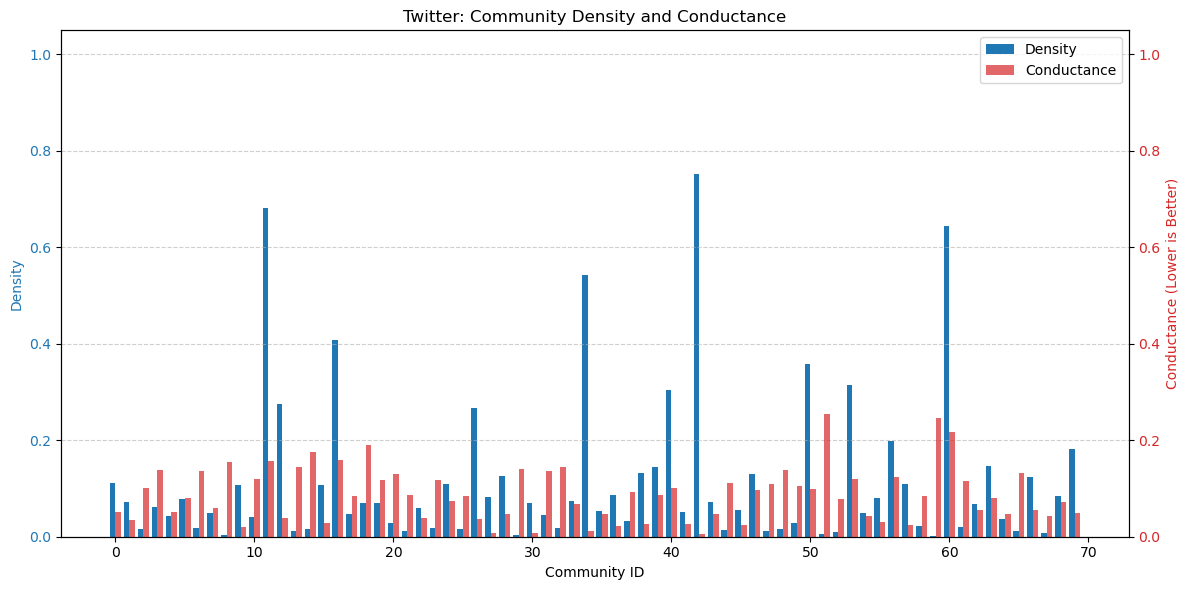

--- Finished Plotting Metrics: Twitter ---

--- Plotting Community Metrics: Facebook ---
Using 'bar' plot type for 16 communities.


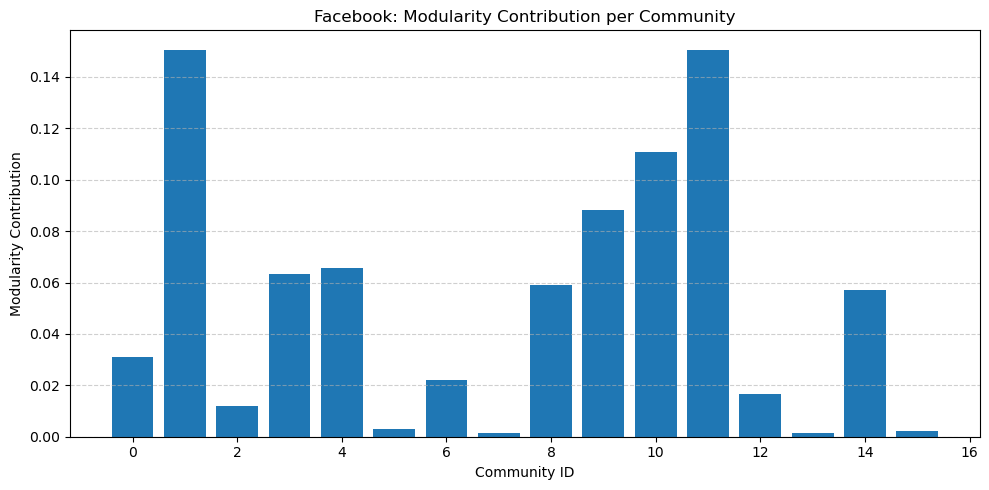

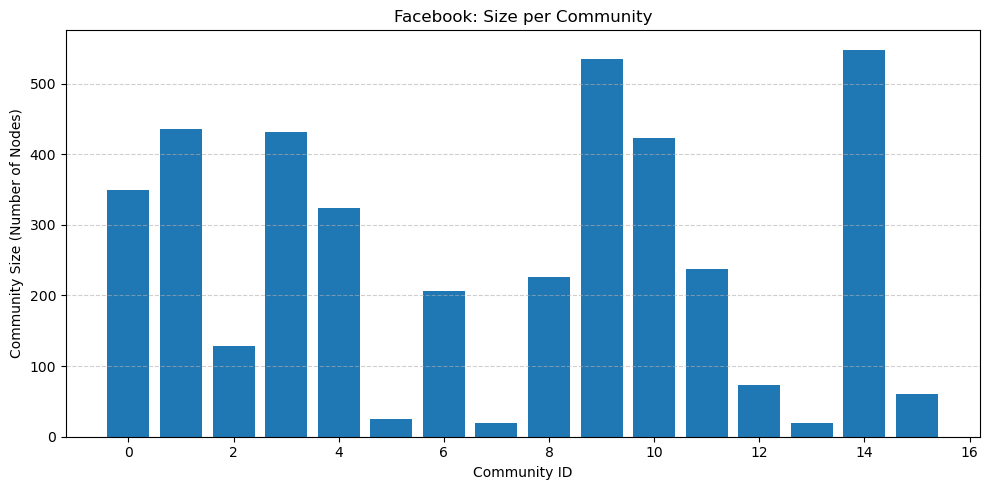

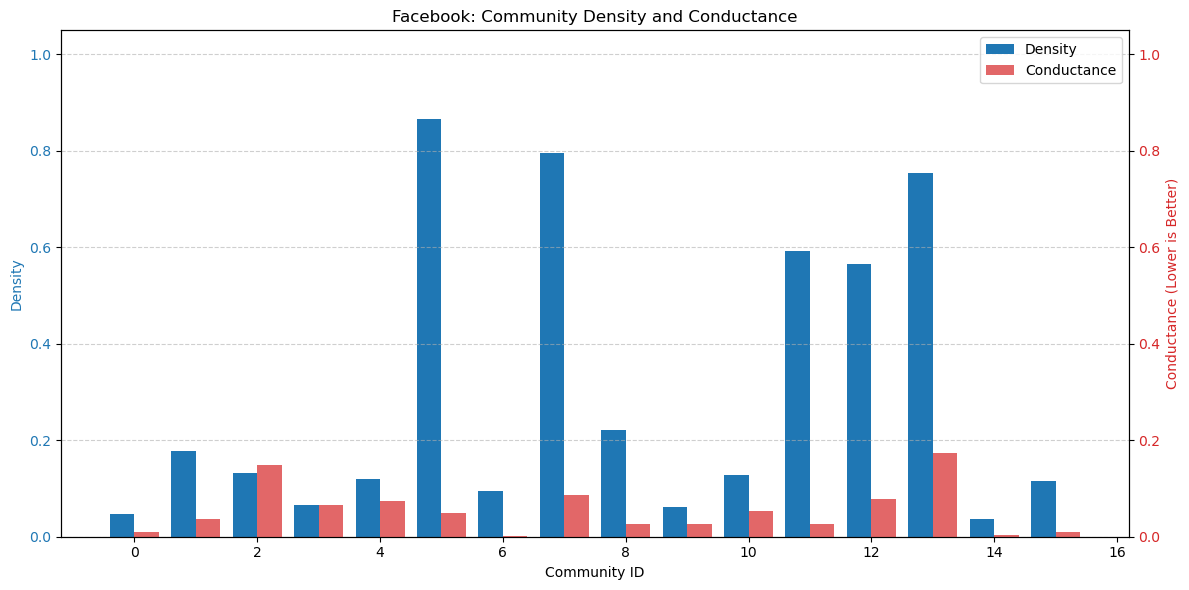

--- Finished Plotting Metrics: Facebook ---

*** Step 3: Visualizing Community Structures ***

Visualizing a random sample of 80000 nodes.
Sampled subgraph has 80000 nodes and 1705879 edges.

--- Visualizing Communities: Twitter (80000 nodes being drawn) ---
Coloring nodes based on 70 detected communities.
Using Default/Twitter color scheme (20 hues, 2 S levels, 3 V levels).
Cycling through 20 hues, 2 saturations, 3 values (120 unique colors possible).
Calculating node positions using spring_layout for 80000 nodes...
Layout calculation finished.
Drawing graph...


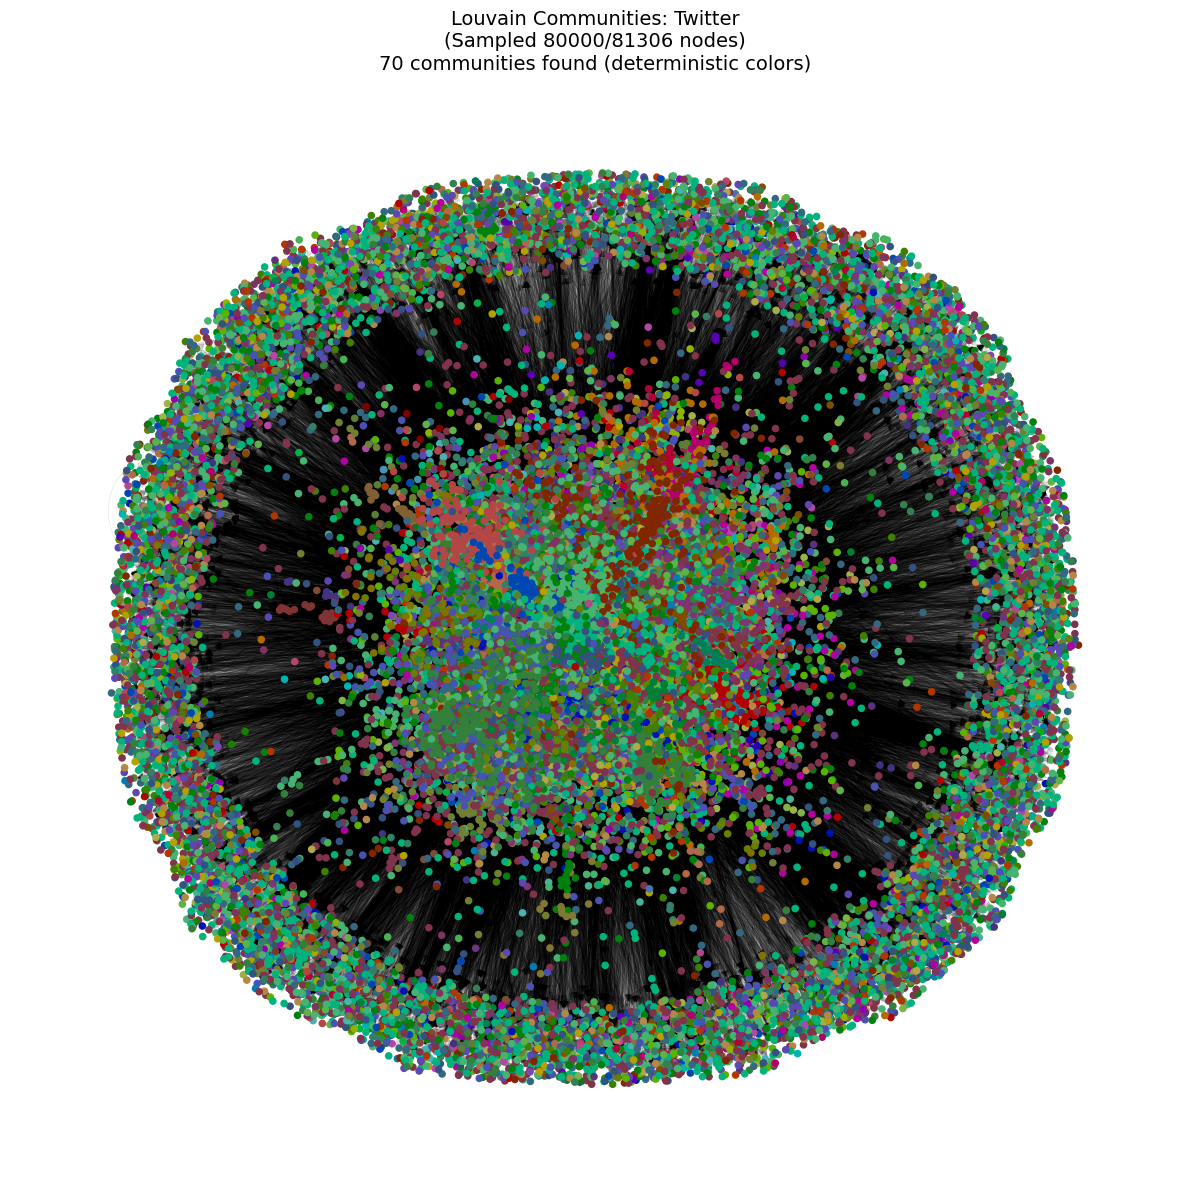

--- Visualization Complete: Twitter ---

--- Visualizing Communities: Facebook (4039 nodes being drawn) ---
Coloring nodes based on 16 detected communities.
Using Facebook color scheme (8 hues, 2 SV pairs).
Cycling through 8 hues and 2 SV pairs (16 unique colors possible).
Calculating node positions using spring_layout for 4039 nodes...
Layout calculation finished.
Drawing graph...


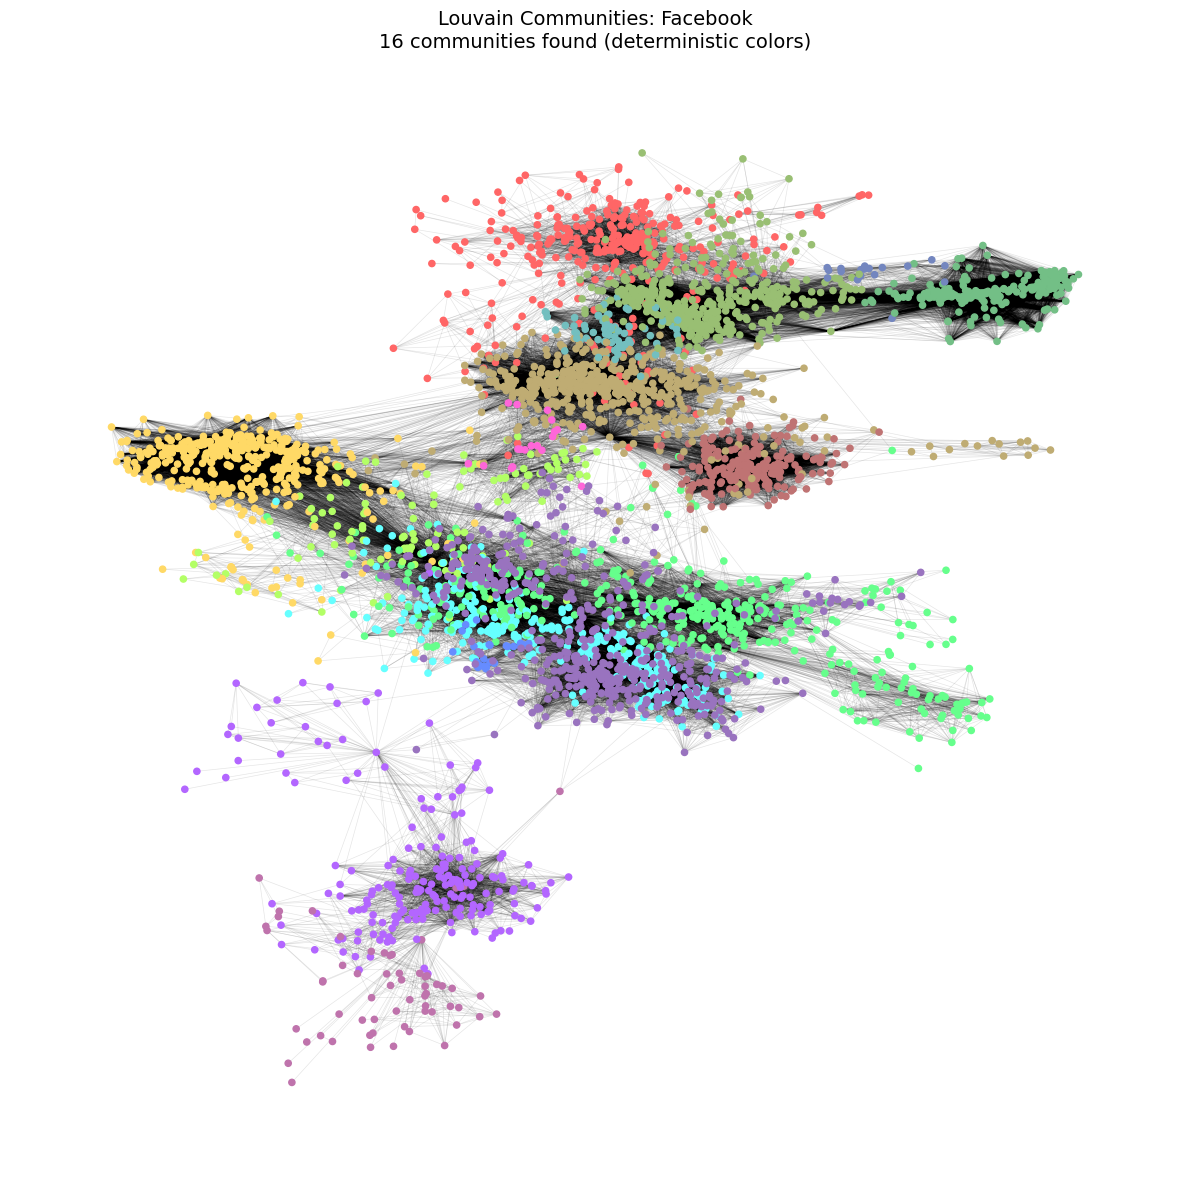

--- Visualization Complete: Facebook ---

*** Analysis, Plotting, and Visualization Complete ***


In [32]:
import networkx as nx
      
from networkx.algorithms.community import louvain_communities, modularity, partition_quality
from networkx.algorithms.cuts import conductance 
    
import colorsys # Needed for HSV to RGB conversion


# --- Function Definitions ---

# --- calculate_community_metrics  ---
def calculate_community_metrics(graph_undirected, communities):
    """Calculates metrics for each community."""
    metrics = []
    if not communities or graph_undirected.number_of_nodes() == 0:
        return metrics

    total_edges = graph_undirected.number_of_edges()
    if total_edges == 0: # Handle graphs with no edges - metrics will be 0 or NaN
         for i, comm_nodes in enumerate(communities):
              size = len(comm_nodes)
              metrics.append({
                  'id': i,
                  'size': size,
                  'density': 0.0, 
                  'conductance': 0.0, 
                  'modularity_contribution': 0.0 
              })
         return metrics

    # Pre-calculate all node degrees in the original graph
    all_degrees = dict(graph_undirected.degree())
    twice_total_edges = 2.0 * total_edges # Pre-calculate for modularity

    for i, comm_nodes in enumerate(communities):
        community_set = set(comm_nodes) 
        size = len(community_set)

        if size == 0:
            continue 

        # --- Density ---
        subgraph = graph_undirected.subgraph(community_set)
        internal_edges = subgraph.number_of_edges()
        if size > 1:
            max_possible_edges = size * (size - 1) / 2.0
            density = internal_edges / max_possible_edges if max_possible_edges > 0 else 0.0
        else:
            density = 0.0 

        # --- Conductance ---
        conductance_val = np.nan # Default
        try:
            if size < graph_undirected.number_of_nodes(): 
                conductance_val = nx.conductance(graph_undirected, community_set, weight=None)
            elif size == graph_undirected.number_of_nodes():

                conductance_val = 0.0
        except Exception as e:

            pass # Keep conductance_val as NaN

        Dc = sum(all_degrees.get(node, 0) for node in community_set) # Sum degrees from original graph
        term1 = internal_edges / total_edges
        term2 = (Dc / twice_total_edges) ** 2
        modularity_contribution = term1 - term2

        metrics.append({
            'id': i,
            'size': size,
            'density': density,
            'conductance': conductance_val, # Lower is generally better (more compact/separated)
            'modularity_contribution': modularity_contribution
        })

    return metrics


# --- detect_communities (Modified to add metrics calculation & return) ---
def detect_communities(graph, name):
    print(f"\n=====================================================")
    print(f" Louvain Community Detection: {name} Graph")
    print(f"=====================================================")

    if not isinstance(graph, (nx.Graph, nx.DiGraph)):
        print(f"Error: Input graph for {name} is not a NetworkX graph object.")
        return [], {}, []

    original_num_nodes = graph.number_of_nodes()
    original_num_edges = graph.number_of_edges()

    if original_num_nodes == 0:
        print("Graph is empty. Cannot detect communities.")
        return [], {}, [] # Return empty metrics list

    print(f"Graph Info: {original_num_nodes} nodes, {original_num_edges} edges")
    print("Running Louvain algorithm...")

    if graph.is_directed():
        graph_undirected = nx.Graph(graph)
    else:
        graph_undirected = graph.copy()

    # Initialize variables
    communities = []
    node_to_community = {}
    modularity_score = np.nan
    coverage = np.nan
    community_sizes = []
    num_communities = 0
    community_metrics = [] 

    # --- Handling for graphs with no edges (keeps original structure) ---
    if graph_undirected.number_of_edges() == 0 and original_num_nodes > 0:
        print("Graph has no edges. Treating all nodes as separate communities.")
        communities = [{node} for node in graph_undirected.nodes()]
        num_communities = len(communities)
        if num_communities > 0:
            community_sizes = [1] * num_communities
            node_to_community = {}
            for i, comm in enumerate(communities):
                for node in comm:
                    node_to_community[node] = i
        print(f"\nNumber of communities detected: {num_communities}")
        modularity_score = 0.0 
        coverage = 0.0
        print(f"  Modularity of the partition: {modularity_score:.4f} (by definition)")
        print(f"  Coverage of the partition: {coverage:.4f} (by definition)")
        # --- Calculate metrics for these singleton communities ---
        print("Calculating per-community metrics (size, density, conductance, mod_contrib)...")
        community_metrics = calculate_community_metrics(graph_undirected, communities)
        print("Per-community metric calculation finished.")

    # --- Main Louvain execution and metric calculation block ---
    elif original_num_nodes > 0:
        try:
            communities_list = louvain_communities(graph_undirected, resolution=1, seed=42)
            communities = [set(c) for c in communities_list if c] 
            print("Louvain algorithm completed.")

            num_communities = len(communities)
            print(f"\nNumber of communities detected: {num_communities}")

            if num_communities == 0:
                print("No communities detected by Louvain.")
                return [], {}, [] # Return empty metrics

            community_sizes = [len(c) for c in communities]

            node_to_community = {}
            for i, comm in enumerate(communities):
                for node in comm:
                    node_to_community[node] = i

            print("Calculating quality metrics...")
            try:
                if communities:
                     modularity_score = modularity(graph_undirected, communities)
                     print(f"  Modularity of the partition: {modularity_score:.4f}") # Use global modularity term
                else:
                     print("  Skipping modularity calculation (no communities).")
                     modularity_score = np.nan
            except Exception as e:
                print(f"  Could not calculate modularity: {e}")
                modularity_score = np.nan

            try:
                if communities:
                    qual = partition_quality(graph_undirected, communities)
                    coverage = qual[0]
                    # performance = qual[1] # Capture performance if needed
                    print(f"  Coverage of the partition: {coverage:.4f}")
                    # print(f"  Performance of the partition: {performance:.4f}") # Print if needed
                else:
                     print("  Skipping coverage calculation (no communities).")
                     coverage = np.nan
                     # performance = np.nan
            except Exception as e:
                 print(f"  Could not calculate coverage: {e}") # Original message only mentioned coverage
                 coverage = np.nan
                 # performance = np.nan

            print("Quality metric calculation finished.") # Matches original phrasing

            # --- Add calculation of per-community metrics ---
            print("Calculating per-community metrics (size, density, conductance, mod_contrib)...")
            community_metrics = calculate_community_metrics(graph_undirected, communities)
            print("Per-community metric calculation finished.")
            # --- End of added calculation ---

        except Exception as e:
             print(f"An error occurred during Louvain detection or metric calculation: {e}")
             # Return empty results on error, including metrics
             return [], {}, []


    # --- Reporting Community Size Statistics ---
    if community_sizes:
        print("\nCommunity Size Statistics:")
        print(f"  Min size:    {np.min(community_sizes)}")
        print(f"  Max size:    {np.max(community_sizes)}")
        print(f"  Mean size:   {np.mean(community_sizes):.2f}")
        print(f"  Median size: {np.median(community_sizes):.0f}")

        print("\nTop 5 community sizes:")
        sorted_communities_by_size = sorted(communities, key=len, reverse=True) if communities else []
        for i, community in enumerate(sorted_communities_by_size[:5]):
            print(f"  Rank {i + 1}: {len(community)} nodes")
    elif original_num_nodes > 0 and not communities:
        print("No communities found to report size statistics.")
    elif original_num_nodes == 0:
        pass 

    print(f"\n--- End of Community Detection: {name} ---") 

    return communities, node_to_community, community_metrics


# --- plot_community_metrics (New function as developed before) ---
def plot_community_metrics(metrics, graph_name):
    """Generates plots for community size, modularity contribution, density, and conductance."""
    if not metrics:
        print(f"No community metrics to plot for {graph_name}.")
        return

    print(f"\n--- Plotting Community Metrics: {graph_name} ---")

    ids = [m['id'] for m in metrics]
    sizes = [m['size'] for m in metrics]
    mod_contribs = [m['modularity_contribution'] for m in metrics]
    densities = [m['density'] for m in metrics]
    # Replace NaN conductance with a value (e.g., 0 or 1) for plotting or filter them out
    # A conductance of 0 often means an isolated component or the whole graph.
    # NaN might occur if calculation failed unexpectedly. Let's plot NaN as 0 for simplicity here.
    conductances = [m['conductance'] if not np.isnan(m['conductance']) else 0.0 for m in metrics]


    num_communities = len(metrics)
    plot_type = 'bar'
    marker_size = 15 if num_communities > 100 else (30 if num_communities > 50 else 50) # Adjust marker size
    print(f"Using '{plot_type}' plot type for {num_communities} communities.")

    # --- Plot 1: Modularity Contribution per Community ---
    plt.figure(figsize=(10, 5))
    plt.bar(ids, mod_contribs)
    plt.xlabel("Community ID")
    plt.ylabel("Modularity Contribution")
    plt.title(f"{graph_name}: Modularity Contribution per Community")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Size per Community ---
    plt.figure(figsize=(10, 5))
    if plot_type == 'bar':
        plt.bar(ids, sizes)
    else:
        plt.scatter(ids, sizes, s=marker_size)
    plt.xlabel("Community ID")
    plt.ylabel("Community Size (Number of Nodes)")
    plt.title(f"{graph_name}: Size per Community")
    # Use log scale if max size is much larger than min size (e.g., > 100x)
    min_positive_size = min((sz for sz in sizes if sz > 0), default=1)
    max_size = max(sizes) if sizes else 1
    if max_size / min_positive_size > 100 and max_size > 1: # Avoid log scale for all size 1 communities
        plt.yscale('log')
        plt.ylabel("Community Size (Number of Nodes) - Log Scale")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Density (Left Axis) and Conductance (Right Axis) per Community ---
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color1 = 'tab:blue'
    ax1.set_xlabel('Community ID')
    ax1.set_ylabel('Density', color=color1)
    if plot_type == 'bar':
         width = 0.4
         bar_positions1 = [i - width/2 for i in ids]
         ax1.bar(bar_positions1, densities, width, color=color1, label='Density')
    else:
        ax1.scatter(ids, densities, color=color1, label='Density', s=marker_size)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax1.set_ylim(bottom=0, top=max(1.05, ax1.get_ylim()[1]))


    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Conductance (Lower is Better)', color=color2)
    if plot_type == 'bar':
        bar_positions2 = [i + width/2 for i in ids]
        ax2.bar(bar_positions2, conductances, width, color=color2, alpha=0.7, label='Conductance')
    else:
        ax2.scatter(ids, conductances, color=color2, label='Conductance', alpha=0.7, s=marker_size)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim(bottom=0, top=max(1.05, ax2.get_ylim()[1]))

    plt.title(f'{graph_name}: Community Density and Conductance')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    fig.tight_layout()
    plt.show()

    print(f"--- Finished Plotting Metrics: {graph_name} ---")


# --- visualize_communities  ---
def visualize_communities(graph, node_to_community_map, graph_name,
                          layout_prog='spring', node_size=50,
                          show_labels=False, label_font_size=8,
                          edge_alpha=0.1,
                          max_nodes_to_visualize=20000):

    if not isinstance(graph, (nx.Graph, nx.DiGraph)):
         print(f"Error: Input graph for {graph_name} is not a NetworkX graph object.")
         return
    if not isinstance(node_to_community_map, dict):
        if node_to_community_map is not None:
             print(f"Warning: node_to_community_map for {graph_name} is not a dictionary. Will color nodes grey.")
        node_to_community_map = {}

    original_num_nodes = graph.number_of_nodes()

    if original_num_nodes == 0:
        print(f"Graph '{graph_name}' is empty. Nothing to visualize.")
        return

    # --- Handle Large Graphs by Sampling ---
    graph_to_draw = graph
    node_map_to_use = node_to_community_map
    sampled_nodes = None

    if original_num_nodes > max_nodes_to_visualize:
        print(f"\nWarning: Graph '{graph_name}' has {original_num_nodes} nodes, exceeding the limit of {max_nodes_to_visualize}.")
        print(f"Visualizing a random sample of {max_nodes_to_visualize} nodes.")
        random.seed(42)
        sampled_nodes = random.sample(list(graph.nodes()), max_nodes_to_visualize)
        graph_to_draw = graph.subgraph(sampled_nodes).copy()
        node_map_to_use = {node: comm_id for node, comm_id in node_to_community_map.items() if node in sampled_nodes}
        num_nodes_to_draw = graph_to_draw.number_of_nodes()
        print(f"Sampled subgraph has {num_nodes_to_draw} nodes and {graph_to_draw.number_of_edges()} edges.")
    else:
        num_nodes_to_draw = original_num_nodes
        node_map_to_use = node_to_community_map

    if num_nodes_to_draw == 0:
         print(f"Graph {graph_name} has no nodes to visualize.")
         return

    print(f"\n--- Visualizing Communities: {graph_name} ({num_nodes_to_draw} nodes being drawn) ---")

    # --- Prepare Node Colors using Graph-Specific Deterministic HSV Cycling ---
    valid_community_ids = sorted(list(set(cid for cid in node_map_to_use.values() if cid is not None)))
    num_detected_communities = len(valid_community_ids)

    print(f"Coloring nodes based on {num_detected_communities} detected communities.")

    community_color_map = {}
    default_color = (0.5, 0.5, 0.5, 1.0) # Grey

    if num_detected_communities > 0:
        # --- Define Color Schemes ---
        if 'facebook' in graph_name.lower(): # Case-insensitive check
            print("Using Facebook color scheme (8 hues, 2 SV pairs).")
            num_hues = 8
            hue_levels = [i / num_hues for i in range(num_hues)]
            sv_pairs = [(0.6, 1.0), (0.4, 0.75)] # S=60 V=100, S=40 V=75
            num_sv_pairs = len(sv_pairs)
            total_unique_colors = num_hues * num_sv_pairs
            print(f"Cycling through {num_hues} hues and {num_sv_pairs} SV pairs ({total_unique_colors} unique colors possible).")

            # Assign colors
            for i, comm_id in enumerate(valid_community_ids):
                hue_index = i % num_hues
                sv_pair_index = (i // num_hues) % num_sv_pairs
                h = hue_levels[hue_index]
                s, v = sv_pairs[sv_pair_index]
                community_color_map[comm_id] = colorsys.hsv_to_rgb(h, s, v)

        else: # Default (includes Twitter or any other name)
            print("Using Default/Twitter color scheme (20 hues, 2 S levels, 3 V levels).")
            num_hues = 20
            num_saturations = 2
            num_values = 3
            hue_levels = [i / num_hues for i in range(num_hues)]
            saturation_levels = [0.60, 1.00]
            value_levels = [0.70, 0.50, 0.30] # Brighter first maybe? Adjust if needed
            total_unique_colors = num_hues * num_saturations * num_values
            print(f"Cycling through {num_hues} hues, {num_saturations} saturations, {num_values} values ({total_unique_colors} unique colors possible).")

            # Assign colors
            for i, comm_id in enumerate(valid_community_ids):
                hue_index = i % num_hues
                saturation_index = (i // num_hues) % num_saturations
                value_index = (i // (num_hues * num_saturations)) % num_values
                h = hue_levels[hue_index]
                s = saturation_levels[saturation_index]
                v = value_levels[value_index]
                community_color_map[comm_id] = colorsys.hsv_to_rgb(h, s, v)

        # --- Assign colors to nodes ---
        node_colors = [community_color_map.get(node_map_to_use.get(node), default_color)
                       for node in graph_to_draw.nodes()]

    else:
         print("No communities detected in the visualized subset, coloring all nodes grey.")
         node_colors = [default_color] * num_nodes_to_draw


    # --- Calculate Layout ---
    print(f"Calculating node positions using {layout_prog}_layout for {num_nodes_to_draw} nodes...")
    try:
        if layout_prog == 'spring':
            iterations = 50 if num_nodes_to_draw < 1000 else 20
            # Using math.sqrt here requires importing math
            k_value = 0.1 / np.sqrt(num_nodes_to_draw) if num_nodes_to_draw > 100 else None
            pos = nx.spring_layout(graph_to_draw, seed=42, iterations=iterations, k=k_value)
        elif layout_prog == 'kamada_kawai':
            if num_nodes_to_draw > 2000:
                 print("Kamada-Kawai might be slow, consider 'spring' layout.")
            pos = nx.kamada_kawai_layout(graph_to_draw)
        elif layout_prog == 'spectral':
            pos = nx.spectral_layout(graph_to_draw)
        else:
            print(f"Unknown layout '{layout_prog}'. Using spring_layout.")
            # Using math.sqrt here requires importing math
            k_value = 0.1 / np.sqrt(num_nodes_to_draw) if num_nodes_to_draw > 100 else None
            pos = nx.spring_layout(graph_to_draw, seed=42, k=k_value)
        print("Layout calculation finished.")
    except Exception as e:
        print(f"Layout calculation failed: {e}. Falling back to spring layout.")
        # Using math.sqrt here requires importing math
        k_value = 0.1 / np.sqrt(num_nodes_to_draw) if num_nodes_to_draw > 100 else None
        pos = nx.spring_layout(graph_to_draw, seed=42, k=k_value)


    # --- Draw the Graph ---
    print("Drawing graph...")
    plt.figure(figsize=(12, 12))
    title = f"Louvain Communities: {graph_name}"
    if sampled_nodes:
        title += f"\n(Sampled {num_nodes_to_draw}/{original_num_nodes} nodes)"
    # Calculate total communities found originally before sampling
    total_original_communities = len(set(cid for cid in node_to_community_map.values() if cid is not None))
    title += f"\n{total_original_communities} communities found (deterministic colors)" # Changed phrasing slightly

    nx.draw_networkx_edges(graph_to_draw, pos, alpha=edge_alpha, width=0.5)
    nx.draw_networkx_nodes(graph_to_draw, pos, node_color=node_colors, node_size=node_size)

    if show_labels and not sampled_nodes and num_nodes_to_draw <= 500:
         print("Drawing labels...")
         nx.draw_networkx_labels(graph_to_draw, pos, font_size=label_font_size)
    elif show_labels and (sampled_nodes or num_nodes_to_draw > 500):
         print("Skipping labels due to large graph size or sampling.")

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"--- Visualization Complete: {graph_name} ---")


# --- Execution ---


graphs_to_analyze = {
    "Twitter": twitter_graph,
    "Facebook": facebook_graph
}



community_results = {}
max_nodes_for_vis = 80000 

# 1. Detect Communities and Calculate Metrics for all graphs
print("\n*** Step 1: Detecting Communities and Calculating Metrics ***")
for name, graph_obj in graphs_to_analyze.items():
    # Call the modified detect_communities which now returns metrics
    communities, node_to_comm_map, comm_metrics = detect_communities(graph_obj, name)
    community_results[name] = {
        "communities": communities,
        "node_to_community": node_to_comm_map,
        "community_metrics": comm_metrics # Store the detailed metrics
    }

# 2. Plot Community Metrics for all graphs
print("\n*** Step 2: Plotting Community Metrics ***")
for name in graphs_to_analyze.keys(): # Iterate through graph names
     if name in community_results and community_results[name].get("community_metrics"):
         # Call the new plotting function
         plot_community_metrics(community_results[name]["community_metrics"], name)
     else:
         # Handle cases where detection might have failed or returned no metrics
         print(f"No community metrics available to plot for {name}.")


# 3. Visualize Community Structures for all graphs
print("\n*** Step 3: Visualizing Community Structures ***")
for name, graph_obj in graphs_to_analyze.items():
    if name in community_results:
        node_map = community_results[name].get("node_to_community", {})
        original_node_count = graph_obj.number_of_nodes()

        # Use the max_nodes_for_vis limit set above
        is_sampled = original_node_count > max_nodes_for_vis
        show_node_labels = False if (is_sampled or original_node_count > 500) else True

        visualize_communities( # Calling the original function verbatim
            graph=graph_obj,
            node_to_community_map=node_map,
            graph_name=name,
            node_size=20 if original_node_count > 1000 else 40,
            show_labels=show_node_labels,
            layout_prog='spring', # Default layout
            max_nodes_to_visualize=max_nodes_for_vis
        )
    else:
        print(f"No community results found for {name} to visualize.")

print("\n*** Analysis, Plotting, and Visualization Complete ***")

**Twitter Network**:

The high modularity score  indicates that nodes within the 70 communities are significantly well connected. Over 87% of the follow relationships (edges) exist within the detected communities. There's a wide range of community sizes (10 to 11,029). The mean is much larger than the median there are a few very large communities (top 2 have >10k nodes each) and many smaller ones. The largest community contains ~14.8% of all users. 


**Facebook Network**:

The number of communities is 2O times higher, taking into account the number of nodes relative to Twitter.
The modularity score is higher, and 96% of friendships are within the communities, this explains the few links between communities seen in the network.
The sizes of the communities are relatively uniform, suggesting that there is no  dominant group.

The visualization clearly reflects the metrics, we see distinct, sparsely connected communities.

### What we added :
Different metrics, that we plot with the number of nodes ! modularity, coverage, conductance for sepatation, size.
**Twitter Network**:
Louvain finds a partition with high overall modularity and coverage. The structure of the graph is highly varied, consisting of numerous small communities alongside a few massive ones. While generally well-separated (low conductance), the internal density varies significantly between communities. The single high modularity contribution peak suggests one particularly dominant structural unit according to this metric.

**Facebook Network**:
Louvain finds an excellent partition with very high modularity (0.8349) and extremely high coverage (0.9609). The network breaks down into a smaller number of relatively uniformly sized communities (16). These communities are both internally dense and exceptionally well-separated (very low conductance), indicating a clear, strong community structure that Louvain effectively captures.


This provides a step-by-step view of how the Louvain algorithm reached its final result  :

In [30]:
import networkx as nx
from networkx.algorithms.community import louvain_partitions, modularity
import numpy as np


def analyze_louvain_levels(graph, name, resolution=1.0, seed=42, show_top_communities=3):

    print(f"\n=====================================================")
    print(f" Louvain Hierarchical Partition Analysis: {name} Graph")
    print(f"=====================================================")

    print(f"Graph Info: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")
    print(f"Running Louvain partitions (resolution={resolution}, seed={seed})...")

    # Louvain works on undirected graphs for modularity
    graph_undirected = nx.Graph(graph) if graph.is_directed() else graph

    if graph_undirected.number_of_edges() == 0:
        print("Graph has no edges. Levels would be trivial (each node its own community).")
        initial_partition = [{node} for node in graph_undirected.nodes()]
        return [initial_partition]

    try:
        # Get all partition levels as a list of lists of sets
        partition_levels = list(louvain_partitions(graph_undirected, resolution=resolution, seed=seed))
        print("Louvain partitions found.") # Removed timing

        num_levels = len(partition_levels)
        print(f"\nNumber of hierarchical levels found: {num_levels}\n")

        if num_levels == 0:
             print("No partition levels returned by Louvain.")
             return []

        # Analyze each level
        for level, partition in enumerate(partition_levels):
            num_communities = len(partition)
            level_label = f"Level {level + 1}"

            print(f"--- {level_label} ---")
            print(f"  Number of communities: {num_communities}")

            if num_communities == 0:
                print("  No communities found at this level.")
                continue

            # Calculate Modularity for this level's partition
            try:
                level_modularity = modularity(graph_undirected, partition, resolution=resolution)
                print(f"  Modularity: {level_modularity:.4f}")
            except Exception as e:
                print(f"  Could not calculate modularity for this level: {e}")

            # Community Size Statistics
            if partition:
                community_sizes = [len(c) for c in partition]
                print("  Community Size Stats:")
                print(f"    Min: {np.min(community_sizes)}, Max: {np.max(community_sizes)}, Mean: {np.mean(community_sizes):.2f}, Median: {np.median(community_sizes):.0f}")

                # Display top communities
                if show_top_communities > 0:
                    print(f"  Top {min(show_top_communities, num_communities)} largest communities:")
                    sorted_communities = sorted(partition, key=len, reverse=True)
                    for i, community in enumerate(sorted_communities[:show_top_communities]):
                        print(f"    Rank {i + 1} (Size {len(community)})")
            print("-" * (len(level_label) + 6))

    except Exception as e:
        print(f"\nAn error occurred during Louvain partition analysis: {e}")
        return []

    print(f"\n--- End of Louvain Level Analysis: {name} ---")
    return partition_levels

# --- Execution ---
louvain_resolution = 1
num_top_comms_to_show = 3

all_levels_results = {}

for name, graph_obj in graphs_to_analyze.items():
    partition_levels = analyze_louvain_levels(
        graph_obj,
        name,
        resolution=louvain_resolution,
        show_top_communities=num_top_comms_to_show,
        
    )
    all_levels_results[name] = partition_levels


 Louvain Hierarchical Partition Analysis: Twitter Graph
Graph Info: 81306 nodes, 1768149 edges
Running Louvain partitions (resolution=1, seed=42)...
Louvain partitions found.

Number of hierarchical levels found: 3

--- Level 1 ---
  Number of communities: 1704
  Modularity: 0.7421
  Community Size Stats:
    Min: 2, Max: 9149, Mean: 47.71, Median: 5
  Top 3 largest communities:
    Rank 1 (Size 9149)
    Rank 2 (Size 5767)
    Rank 3 (Size 2988)
-------------
--- Level 2 ---
  Number of communities: 139
  Modularity: 0.8017
  Community Size Stats:
    Min: 4, Max: 10906, Mean: 584.94, Median: 193
  Top 3 largest communities:
    Rank 1 (Size 10906)
    Rank 2 (Size 9741)
    Rank 3 (Size 6292)
-------------
--- Level 3 ---
  Number of communities: 70
  Modularity: 0.8034
  Community Size Stats:
    Min: 10, Max: 11029, Mean: 1161.51, Median: 374
  Top 3 largest communities:
    Rank 1 (Size 11029)
    Rank 2 (Size 10259)
    Rank 3 (Size 7468)
-------------

--- End of Louvain Level 

Twitter network initially fragments into many small groups but also contains very large dense regions that form large communities early on. These communities merge progressively

Facebook graphh jumped significantly from Level 1 to Level 2 and then barely changed, indicating a very strong and clear structure emerged quickly

## 2.2 Girvan_Newman approach

The Girvan-Newman approach focuses on the idea that edges connecting different communities act as "bridges" and are crucial for the shortest paths between nodes in those different communities. Therefore, these inter-community edges should have high edge betweenness. The algorithm works by progressively removing these high-betweenness edges to separate the communities.

### What is added : 
A different way of showing the values : with frequency to show distribution. I don't know which is clearer...





--- Step 1: Sampling Graphs ---
Twitter sample: 1000 nodes, 248 edges
Facebook sample: 2000 nodes, 20461 edges

--- Step 2: Running Girvan-Newman ---

--- Girvan-Newman Community Detection: Twitter (sampled) ---
Converted directed graph to undirected for Girvan-Newman.
Note: Graph is not connected. Girvan-Newman will proceed on the full graph.
Running Girvan-Newman on graph with 1000 nodes and 191 edges.
Level 1: 824 communities found.
Level 2: 825 communities found.
Level 3: 826 communities found.

--- Girvan-Newman Community Detection: Facebook (sampled) ---
Note: Graph is not connected. Girvan-Newman will proceed on the full graph.
Running Girvan-Newman on graph with 2000 nodes and 20461 edges.
Level 1: 63 communities found.
Level 2: 64 communities found.
Level 3: 65 communities found.

--- Step 3: Visualizing Communities ---

Visualizing Twitter...

Visualizing Girvan–Newman communities in Twitter (sampled) (Level 1)
Graph subset based on communities still large (1000). Using orig

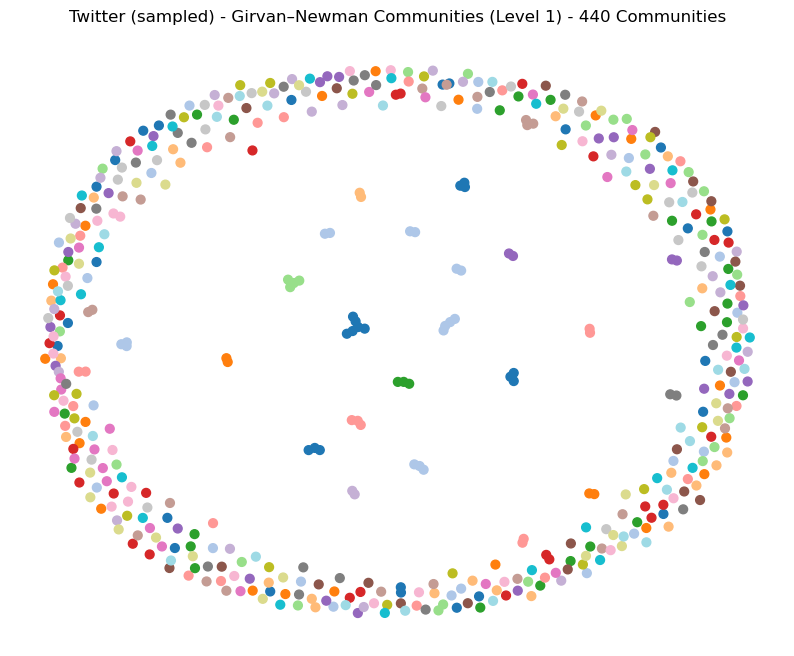


Visualizing Girvan–Newman communities in Twitter (sampled) (Level 2)
Graph subset based on communities still large (1000). Using original Code 1 viz sampling: first 500 nodes of the *original* sample.
Plotting 500 nodes and 48 edges.


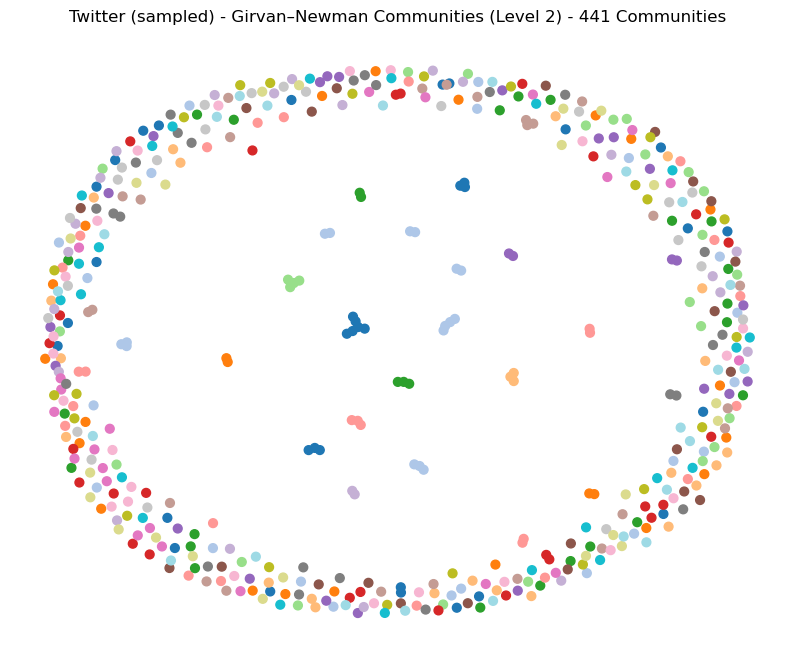


Visualizing Girvan–Newman communities in Twitter (sampled) (Level 3)
Graph subset based on communities still large (1000). Using original Code 1 viz sampling: first 500 nodes of the *original* sample.
Plotting 500 nodes and 48 edges.


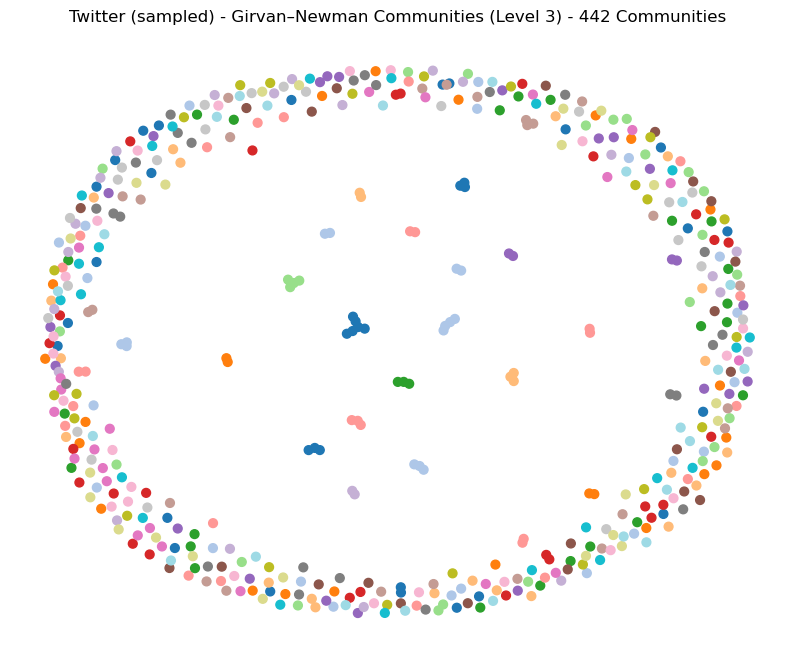


Visualizing Facebook...

Visualizing Girvan–Newman communities in Facebook (sampled) (Level 1)
Graph subset based on communities still large (2000). Using original Code 1 viz sampling: first 500 nodes of the *original* sample.
Plotting 500 nodes and 2606 edges.


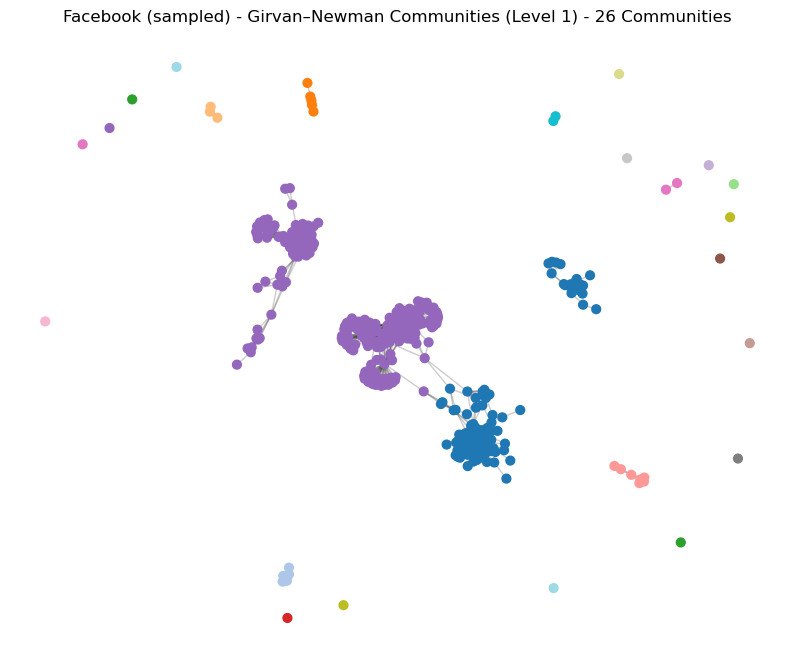


Visualizing Girvan–Newman communities in Facebook (sampled) (Level 2)
Graph subset based on communities still large (2000). Using original Code 1 viz sampling: first 500 nodes of the *original* sample.
Plotting 500 nodes and 2606 edges.


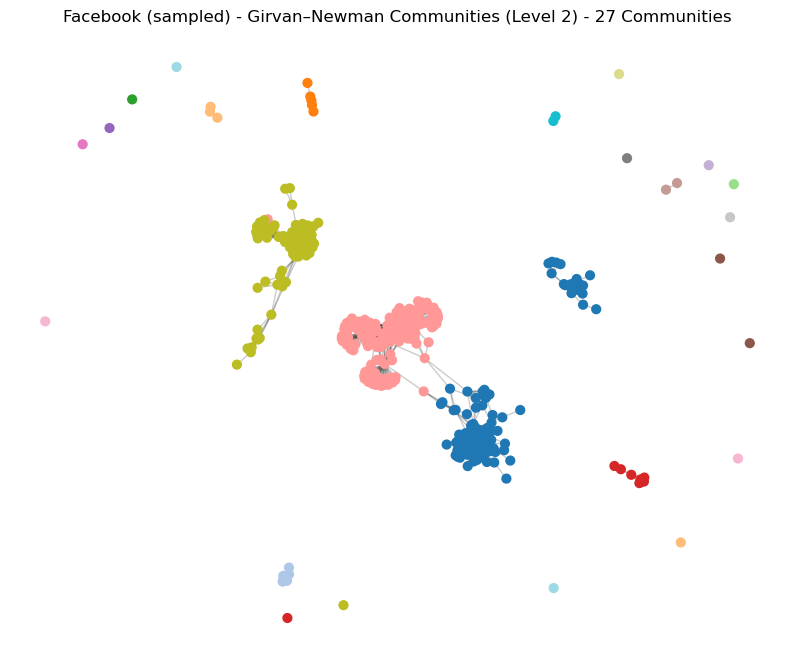


Visualizing Girvan–Newman communities in Facebook (sampled) (Level 3)
Graph subset based on communities still large (2000). Using original Code 1 viz sampling: first 500 nodes of the *original* sample.
Plotting 500 nodes and 2606 edges.


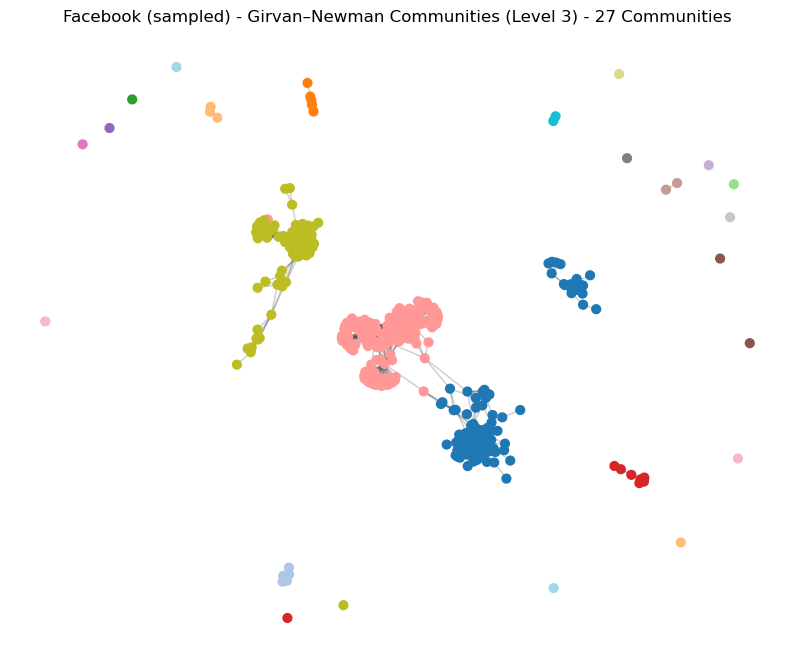


 Step 4: Calculating and Plotting Girvan-Newman Metrics

--- Processing metrics for Twitter (sampled) ---
Note: Using undirected version of Twitter (sampled) for metric calculation.

Calculating metrics for Twitter (sampled) - Level 1...
  Calculating metrics for 824 communities...
  Finished calculating metrics for 824 communities.
Plotting metrics for 824 communities: Twitter (sampled) - Girvan-Newman Level 1


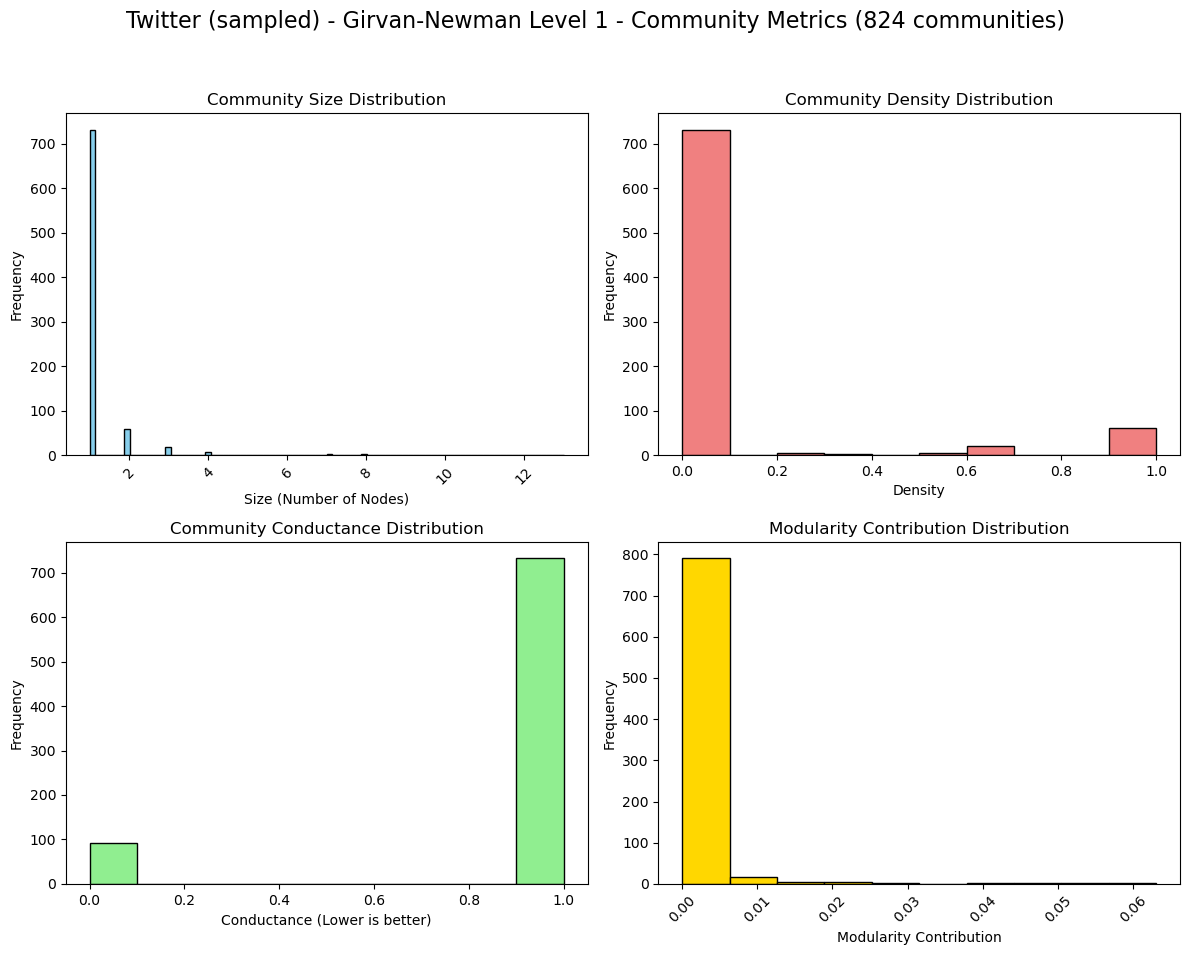


Calculating metrics for Twitter (sampled) - Level 2...
  Calculating metrics for 825 communities...
  Finished calculating metrics for 825 communities.
Plotting metrics for 825 communities: Twitter (sampled) - Girvan-Newman Level 2


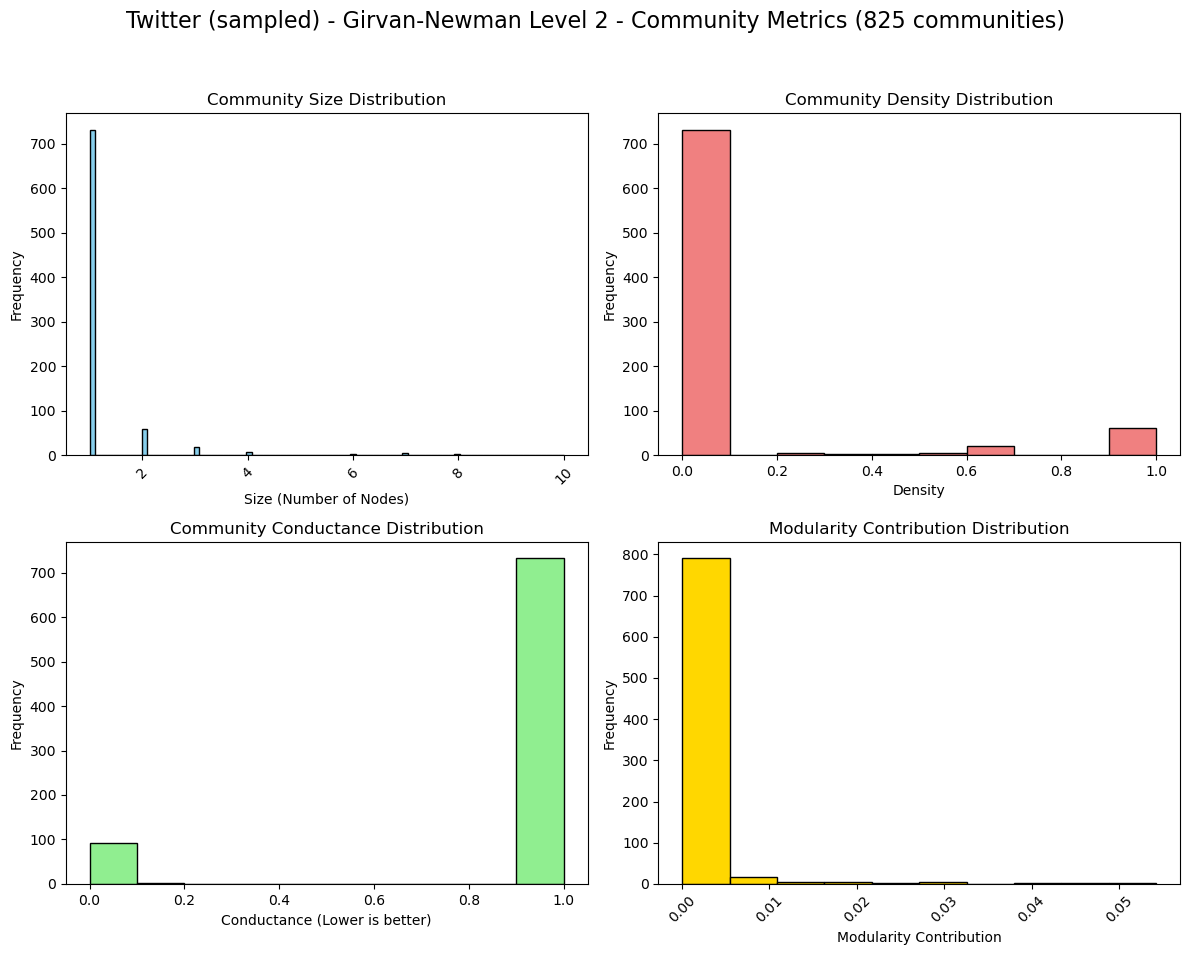


Calculating metrics for Twitter (sampled) - Level 3...
  Calculating metrics for 826 communities...
  Finished calculating metrics for 826 communities.
Plotting metrics for 826 communities: Twitter (sampled) - Girvan-Newman Level 3


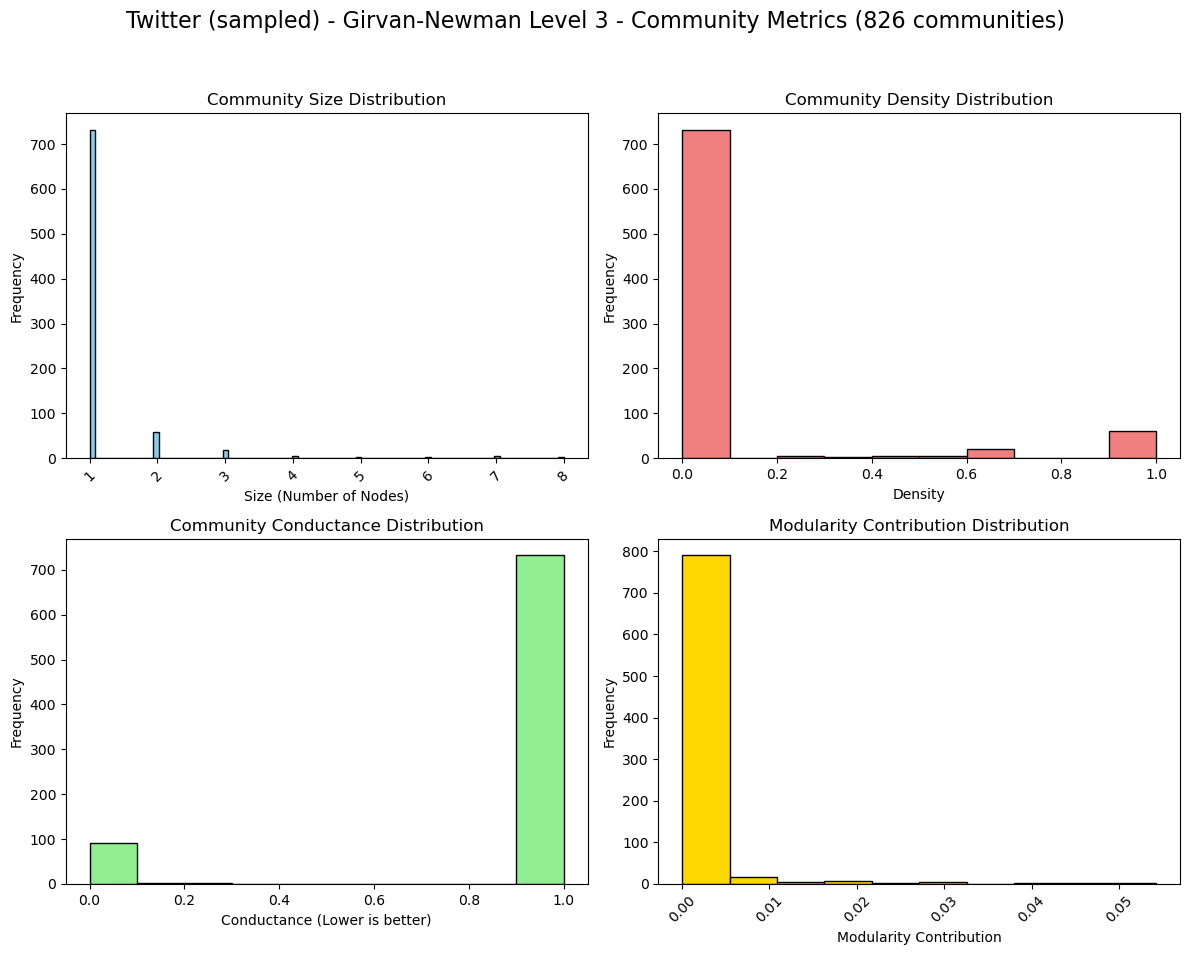


--- Processing metrics for Facebook (sampled) ---

Calculating metrics for Facebook (sampled) - Level 1...
  Calculating metrics for 63 communities...
  Finished calculating metrics for 63 communities.
Plotting metrics for 63 communities: Facebook (sampled) - Girvan-Newman Level 1


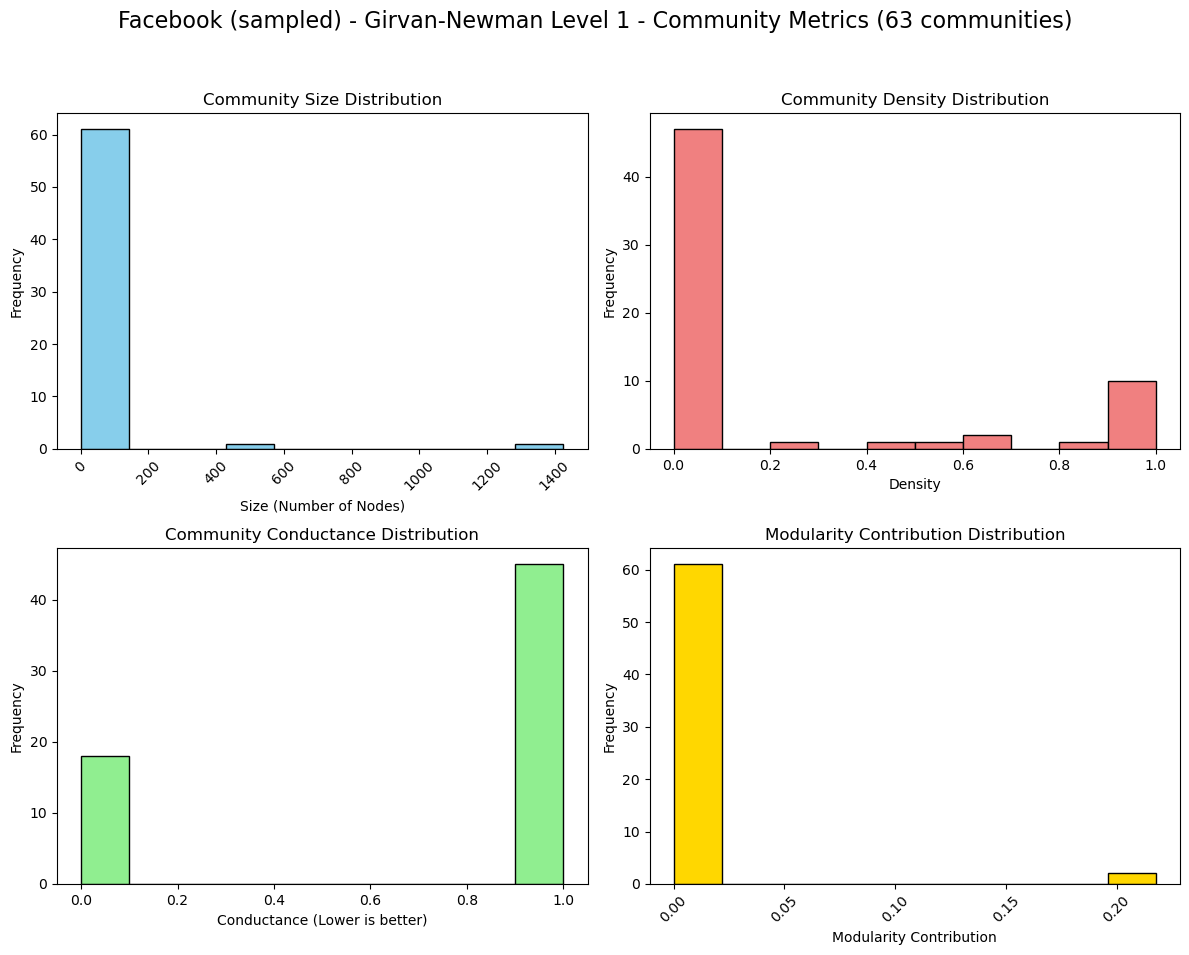


Calculating metrics for Facebook (sampled) - Level 2...
  Calculating metrics for 64 communities...
  Finished calculating metrics for 64 communities.
Plotting metrics for 64 communities: Facebook (sampled) - Girvan-Newman Level 2


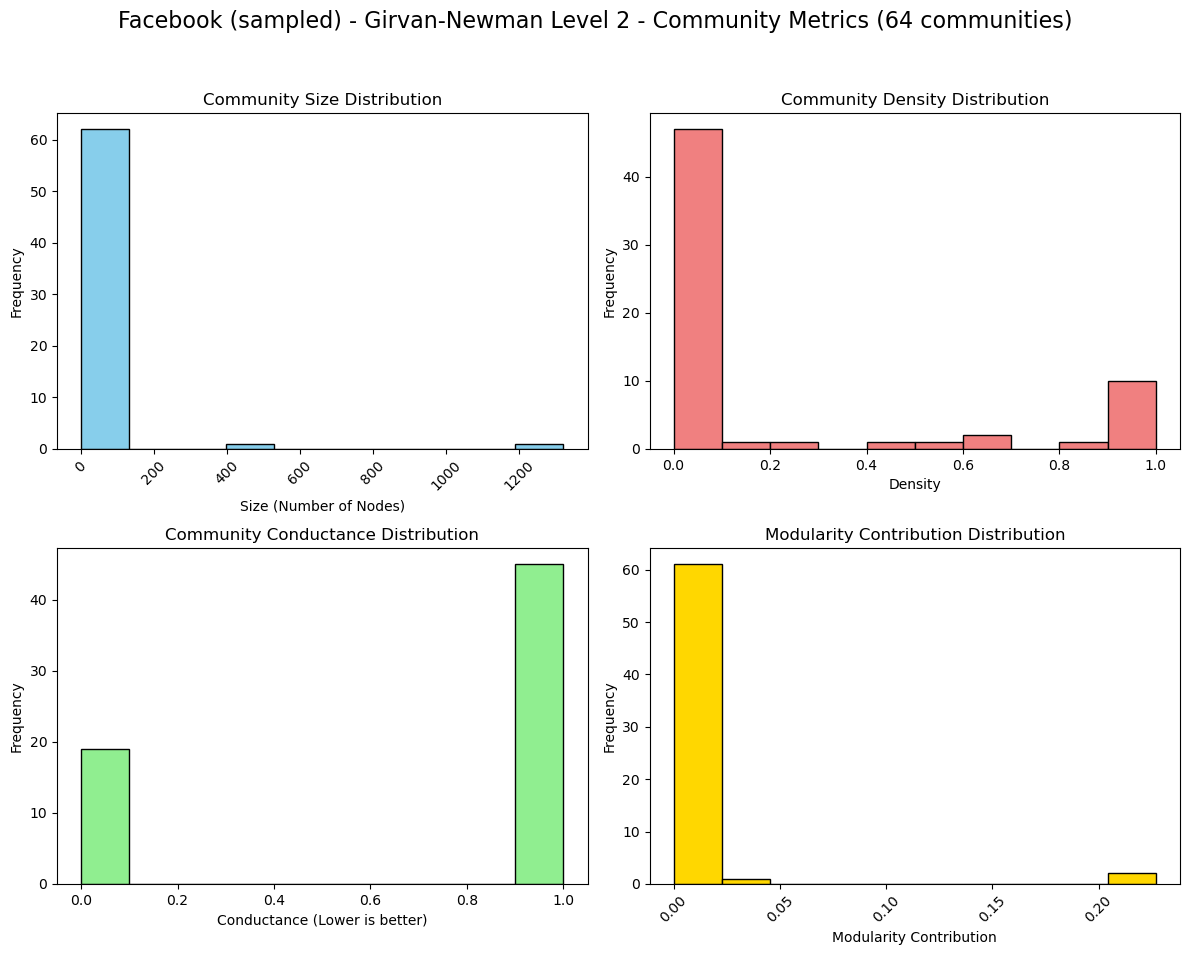


Calculating metrics for Facebook (sampled) - Level 3...
  Calculating metrics for 65 communities...
  Finished calculating metrics for 65 communities.
Plotting metrics for 65 communities: Facebook (sampled) - Girvan-Newman Level 3


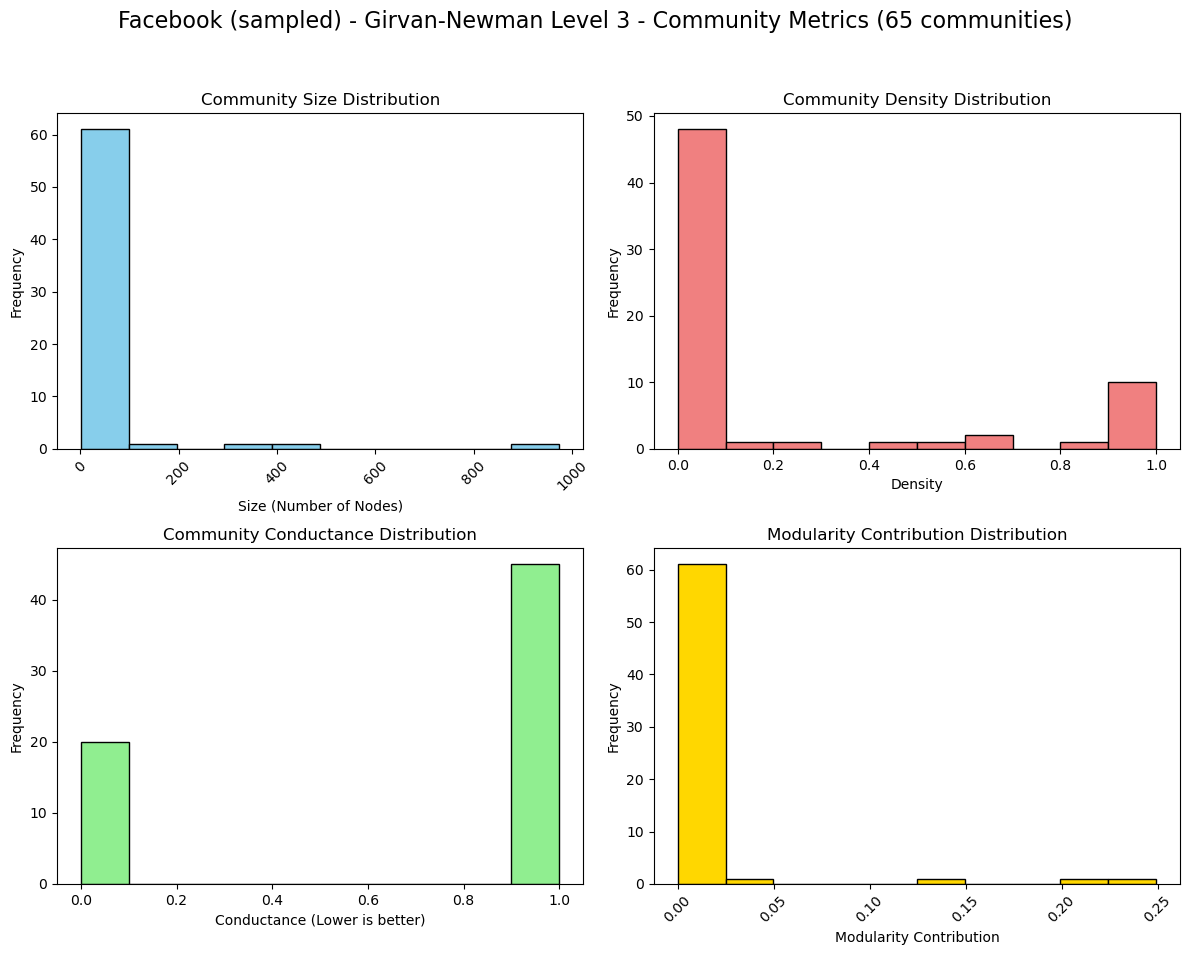


*** Girvan-Newman Metric Calculation and Plotting Complete ***


In [6]:
from networkx.algorithms.community import girvan_newman
      
from networkx.algorithms.community import louvain_communities, modularity, partition_quality
from networkx.algorithms.cuts import conductance 



# -----------------------------
# Sampling Function
# -----------------------------
def sample_graph(graph, sample_size=1000, seed=42):
    if graph.number_of_nodes() <= sample_size:
        return graph.copy()
    random.seed(seed)
    # Ensure sample_size is not larger than the number of nodes
    actual_sample_size = min(sample_size, graph.number_of_nodes())
    if actual_sample_size <= 0:
        return nx.Graph() # Return empty graph if sample size is non-positive
    sampled_nodes = random.sample(list(graph.nodes()), actual_sample_size)
    return graph.subgraph(sampled_nodes).copy()

# -----------------------------
# Girvan–Newman Community Detection
# -----------------------------
def detect_girvan_newman(graph, name, num_levels=3):
    print(f"\n--- Girvan-Newman Community Detection: {name} ---")

    if graph.number_of_nodes() == 0:
        print("Graph is empty. Skipping Girvan-Newman.")
        return []

    graph_undirected = graph
    if graph.is_directed():
        graph_undirected = graph.to_undirected()
        print("Converted directed graph to undirected for Girvan-Newman.")

    # --- Added check for connectivity (optional but good practice like Code 2) ---
    # Girvan-Newman technically works on disconnected graphs by removing edges
    # based on global betweenness, but results might be more interpretable
    # if run on components. Let's keep Code 1's original behavior for now
    # but add a note.
    if not nx.is_connected(graph_undirected):
        print("Note: Graph is not connected. Girvan-Newman will proceed on the full graph.")
        # If you wanted Code 2's behavior, you'd add the component selection here.
    # --- End of connectivity note ---

    if graph_undirected.number_of_nodes() == 0:
         print("Graph for Girvan-Newman is empty. Skipping.")
         return []

    comp = girvan_newman(graph_undirected) # Use the potentially undirected graph
    communities_by_level = []
    levels_processed = 0

    print(f"Running Girvan-Newman on graph with {graph_undirected.number_of_nodes()} nodes and {graph_undirected.number_of_edges()} edges.")
    for i in range(num_levels):
        try:
            # The generator yields tuples of frozensets/nodes. Store them as is.
            communities = next(comp)
            # We will convert to sets later specifically for metrics calculation.
            communities_by_level.append(communities)
            print(f"Level {i + 1}: {len(communities)} communities found.")
            levels_processed += 1
        except StopIteration:
            print(f"StopIteration reached after {levels_processed} levels. No more levels.")
            break
        except Exception as e:
            print(f"An error occurred during Girvan-Newman at level {i+1}: {e}")
            break

    return communities_by_level

# -----------------------------
# Visualization
# -----------------------------
def visualize_girvan_newman(graph, communities, name, level=0, max_nodes=500):
    if not communities or level >= len(communities):
         print(f"\nCannot visualize {name}: No communities found or level {level+1} is out of bounds.")
         return

    print(f"\nVisualizing Girvan–Newman communities in {name} (Level {level + 1})")

    graph_vis = graph
    if graph_vis.is_directed():
        graph_vis = graph_vis.to_undirected()

    community_level_orig = communities[level] # This is likely a tuple of tuples/frozensets

    # Convert to list of sets for easier processing below
    community_level = [set(c) for c in community_level_orig]

    if not community_level:
        print(f"No communities to visualize at level {level + 1}.")
        return

    # Use all nodes present in the communities for visualization focus
    nodes_in_communities = set().union(*community_level)
    if not nodes_in_communities:
         print("No nodes found in the communities for this level. Cannot visualize.")
         return

    graph_vis_sub = graph_vis.subgraph(nodes_in_communities).copy()

    # Use the original sampling logic from Code 1 for visualization if too large
    if graph_vis_sub.number_of_nodes() > max_nodes:
        print(f"Graph subset based on communities still large ({graph_vis_sub.number_of_nodes()}). Using original Code 1 viz sampling: first {max_nodes} nodes of the *original* sample.")
        # Revert to original graph for node selection if using Code 1's viz logic
        nodes_to_plot = list(graph_vis.nodes())[:max_nodes]
        graph_vis_final = graph_vis.subgraph(nodes_to_plot).copy()
        # Filter communities to only those nodes present in the final viz graph
        community_level_final = [comm.intersection(graph_vis_final.nodes()) for comm in community_level]
        community_level_final = [comm for comm in community_level_final if comm] # Remove empty sets
    else:
        # If the community subgraph is small enough, use it
        print(f"Visualizing based on subgraph containing all nodes in level {level+1} communities ({graph_vis_sub.number_of_nodes()} nodes).")
        graph_vis_final = graph_vis_sub
        community_level_final = community_level # Already filtered to nodes in communities


    if not community_level_final or graph_vis_final.number_of_nodes() == 0:
        print("No communities or nodes left after filtering/sampling for visualization.")
        return

    node_to_community = {}
    for i, comm in enumerate(community_level_final):
        for node in comm:
            node_to_community[node] = i

    node_colors = [node_to_community.get(n, -1) for n in graph_vis_final.nodes()]

    print(f"Plotting {graph_vis_final.number_of_nodes()} nodes and {graph_vis_final.number_of_edges()} edges.")
    pos = nx.spring_layout(graph_vis_final, seed=42) # Use original layout params

    plt.figure(figsize=(10, 8)) # Use original figure size
    nx.draw_networkx_nodes(graph_vis_final, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=40) # Original node size
    nx.draw_networkx_edges(graph_vis_final, pos, alpha=0.2) # Original edge alpha
    plt.title(f"{name} - Girvan–Newman Communities (Level {level + 1}) - {len(community_level_final)} Communities")
    plt.axis('off')
    plt.show()


# -----------------------------
# Metrics Calculation (from Code 2)
# -----------------------------
def calculate_community_metrics(graph_undirected, communities_set_list):
    """Calculates metrics for a list of communities (sets of nodes)."""
    metrics = []
    if not communities_set_list or graph_undirected.number_of_nodes() == 0:
        print("  Skipping metrics: No communities or empty graph.")
        return metrics

    # Ensure graph is undirected for calculations
    if graph_undirected.is_directed():
       graph_calc = graph_undirected.to_undirected()
       print("  Note: Using undirected version for metric calculation (should already be).")
    else:
       graph_calc = graph_undirected # Already undirected

    total_edges_in_graph = graph_calc.number_of_edges()
    total_nodes_in_graph = graph_calc.number_of_nodes()

    if total_nodes_in_graph == 0:
        print("  Skipping metrics: Graph has no nodes.")
        return []

    node_degrees = dict(graph_calc.degree())
    sum_of_all_degrees = sum(node_degrees.values()) # 2 * total_edges_in_graph for undirected

    print(f"  Calculating metrics for {len(communities_set_list)} communities...")
    for i, comm_nodes_set in enumerate(communities_set_list):
        comm_nodes = list(comm_nodes_set) # Convert set to list for subgraph
        size = len(comm_nodes)

        if size == 0:
            print(f"  Skipping community {i}: Zero size.")
            continue

        comm_graph = graph_calc.subgraph(comm_nodes)
        internal_edges = comm_graph.number_of_edges()

        # Density
        if size > 1:
            possible_edges = size * (size - 1) / 2
            density = internal_edges / possible_edges if possible_edges > 0 else 0.0
        else:
            density = 0.0 # Single node community has 0 density

        # Conductance
        try:
             # conductance(G, S) needs the full graph and the community node set
             cond = conductance(graph_calc, comm_nodes_set)
        except ZeroDivisionError:
             # Can happen if community is isolated or covers the whole graph component in specific ways
             cond = 0.0 if internal_edges == total_edges_in_graph else 1.0 # Adjust logic based on definition
        except Exception as e:
            print(f"  Error calculating conductance for community {i}: {e}")
            cond = float('nan') # Use NaN for errors

        # Modularity Contribution (approximated per community)
        # Note: True modularity is a sum over all communities
        modularity_contrib = 0.0
        if sum_of_all_degrees > 0: # Equivalent to total_edges_in_graph > 0 for undirected
            sum_degrees_in_comm = sum(node_degrees.get(node, 0) for node in comm_nodes)
            # Using the formula: (L_c / L) - (k_c / 2L)^2
            # where L_c = internal_edges, L = total_edges_in_graph, k_c = sum_degrees_in_comm
            term1 = internal_edges / total_edges_in_graph if total_edges_in_graph > 0 else 0
            term2 = (sum_degrees_in_comm / sum_of_all_degrees) ** 2 if sum_of_all_degrees > 0 else 0
            modularity_contrib = term1 - term2
        else:
             modularity_contrib = 0.0

        metrics.append({
            'id': i,
            'size': size,
            'density': density,
            'conductance': cond,
            'modularity_contribution': modularity_contrib,
            'internal_edges': internal_edges,
        })

    print(f"  Finished calculating metrics for {len(metrics)} communities.")
    return metrics


# -----------------------------
# Metrics Plotting (from Code 2)
# -----------------------------
def plot_community_metrics(metrics, title_prefix):
    if not metrics:
        print("No metrics data to plot.")
        return

    num_communities = len(metrics)
    print(f"Plotting metrics for {num_communities} communities: {title_prefix}")

    sizes = [m['size'] for m in metrics]
    densities = [m['density'] for m in metrics]
    # Filter out NaN conductances before plotting histogram
    conductances = [m['conductance'] for m in metrics if not np.isnan(m['conductance'])]
    modularity_contribs = [m['modularity_contribution'] for m in metrics]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # Use layout from Code 2
    fig.suptitle(f"{title_prefix} - Community Metrics ({num_communities} communities)", fontsize=16)

    # Size Distribution
    axes[0, 0].hist(sizes, bins=max(10, num_communities // 10), color='skyblue', edgecolor='black') # Adjusted bins slightly
    axes[0, 0].set_title('Community Size Distribution')
    axes[0, 0].set_xlabel('Size (Number of Nodes)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Density Distribution
    axes[0, 1].hist(densities, bins=10, color='lightcoral', edgecolor='black', range=(0,1))
    axes[0, 1].set_title('Community Density Distribution')
    axes[0, 1].set_xlabel('Density')
    axes[0, 1].set_ylabel('Frequency')

    # Conductance Distribution
    if conductances: # Only plot if there are valid conductances
        axes[1, 0].hist(conductances, bins=10, color='lightgreen', edgecolor='black', range=(0,1))
    else:
        axes[1,0].text(0.5, 0.5, 'No valid conductance values', ha='center', va='center')
    axes[1, 0].set_title('Community Conductance Distribution')
    axes[1, 0].set_xlabel('Conductance (Lower is better)')
    axes[1, 0].set_ylabel('Frequency')

    # Modularity Contribution Distribution
    axes[1, 1].hist(modularity_contribs, bins=10, color='gold', edgecolor='black')
    axes[1, 1].set_title('Modularity Contribution Distribution')
    axes[1, 1].set_xlabel('Modularity Contribution')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Keep Code 2's layout adjustment
    plt.show()


# ============================================================
# Main Execution Logic
# ============================================================

# --- Step 1: Sampling Graphs ---
print("\n--- Step 1: Sampling Graphs ---")
# Using original sampling parameters from Code 1
twitter_sample = sample_graph(twitter_graph, sample_size=1000, seed=42)
facebook_sample = sample_graph(facebook_graph, sample_size=2000, seed=42)
print(f"Twitter sample: {twitter_sample.number_of_nodes()} nodes, {twitter_sample.number_of_edges()} edges")
print(f"Facebook sample: {facebook_sample.number_of_nodes()} nodes, {facebook_sample.number_of_edges()} edges")


# --- Step 2: Running Girvan-Newman ---
print("\n--- Step 2: Running Girvan-Newman ---")
twitter_gn = detect_girvan_newman(twitter_sample, "Twitter (sampled)", num_levels=3)
facebook_gn = detect_girvan_newman(facebook_sample, "Facebook (sampled)", num_levels=3)


# --- Step 3: Visualizing Communities ---
print("\n--- Step 3: Visualizing Communities ---")
num_levels_to_visualize = 3 # Or min(3, len(twitter_gn)) etc.
print("\nVisualizing Twitter...")
if twitter_gn:
    for i in range(min(num_levels_to_visualize, len(twitter_gn))):
        visualize_girvan_newman(twitter_sample, twitter_gn, name="Twitter (sampled)", level=i)
else:
    print("Skipping Twitter visualization - no communities found.")

print("\nVisualizing Facebook...")
if facebook_gn:
    for i in range(min(num_levels_to_visualize, len(facebook_gn))):
        visualize_girvan_newman(facebook_sample, facebook_gn, name="Facebook (sampled)", level=i)
else:
    print("Skipping Facebook visualization - no communities found.")


# --- Step 4: Calculating and Plotting Metrics ---
print("\n=============================================================")
print(" Step 4: Calculating and Plotting Girvan-Newman Metrics")
print("=============================================================")

# Prepare data structures similar to Code 2 for iteration
gn_results_by_level = {
    "Twitter (sampled)": twitter_gn,
    "Facebook (sampled)": facebook_gn
}
graph_samples_used = {
    "Twitter (sampled)": twitter_sample,
    "Facebook (sampled)": facebook_sample
}

for name, communities_all_levels in gn_results_by_level.items():
    graph_obj_sample = graph_samples_used[name]

    if not communities_all_levels:
        print(f"\n--- Skipping metrics for {name}: No communities detected. ---")
        continue

    print(f"\n--- Processing metrics for {name} ---")

    # Ensure we use an undirected graph for metrics
    if graph_obj_sample.is_directed():
        graph_undirected_sample = graph_obj_sample.to_undirected()
        print(f"Note: Using undirected version of {name} for metric calculation.")
    else:
        graph_undirected_sample = graph_obj_sample

    for level_index, communities_at_level_orig in enumerate(communities_all_levels):
        level_num = level_index + 1

        print(f"\nCalculating metrics for {name} - Level {level_num}...")

        if not communities_at_level_orig:
            print(f"  No communities found at Level {level_num}. Skipping metric calculation and plotting.")
            continue

        # Convert the original community format (tuples/frozensets) to a list of sets
        # Also filter out any potentially empty communities resulted from intermediate steps
        communities_list_for_metrics = [set(comm) for comm in communities_at_level_orig if comm]

        if not communities_list_for_metrics:
             print(f"  No non-empty communities found at Level {level_num} after conversion/filtering. Skipping.")
             continue

        # Call the metrics calculation function
        try:
            gn_community_metrics = calculate_community_metrics(
                graph_undirected_sample, # Pass the undirected graph
                communities_list_for_metrics # Pass the list of sets
            )
        except Exception as e:
            print(f"  Error calculating metrics for {name} - Level {level_num}: {e}")
            gn_community_metrics = [] # Ensure it's an empty list on error

        # Plot the metrics if calculated
        if gn_community_metrics:
            plot_title = f"{name} - Girvan-Newman Level {level_num}"
            plot_community_metrics(gn_community_metrics, plot_title)
        else:
            print(f"  No metrics were calculated or available to plot for {name} - Level {level_num}.")

print("\n*** Girvan-Newman Metric Calculation and Plotting Complete ***")

**we sampled** the Twitter and Facebook graphs because The Girvan–Newman algorithm is computationally expensive, especially on large networks like Twitter (81,000+ nodes). To make the algorithm run in a reasonable time and allow for meaningful visualization, we applied it to sampled subgraphs.Although it may affect the accuracy of detected communities, it still provides a useful approximation of the structural patterns in each network.

*For twitter network:*

Even after 3 levels, the number of communities remains very high (~826 out of 1000 nodes).
The network appears sparsely connected: many nodes are isolated or weakly linked, so the algorithm splits them off early. The dense core is visible in the center of the plots — small, highly connected communities. 
The sample is too small for the result to have a strong significance.

*For Facebook network:*

It has fewer but larger communities , and more structured compared to twitter. we can see that the grey pink blue assembly of points indicate that there are tightly clustered groups so the nodes tend to belong to unified circles which leads to clearer and denser community structures.

The Girvan-Newman algorithm's core action seems to happen very early. It immediately shatters the network into many small fragments while simultaneously isolating a small number of dense, well-separated core groups. The partitions, while containing some good local communities, are globally fragmented and do not score well on modularity at these levels.

For a note , the study of centrality and community detection is inspired by the reference section of the networkx documentary (https://networkx.org/documentation/stable/reference)

# 3 - Shallow embeddings

The goal of these embedding techniques (Spectral, Node2Vec) is to represent each node in the graph as a vector in a lower-dimensional space (here, 64 dimensions). We then test how well this embedding captures structure by applying a standard clustering algorithm (KMeans with k=10) to these vectors. The Silhouette Score measures how well-separated the resulting clusters are:
Scores near +1 indicate dense, well-separated clusters.
Scores near 0 indicate overlapping clusters or that points are very close to decision boundaries.

Starting Embedding Analysis

--- Processing Facebook Graph (4039 nodes) ---
--- Starting Spectral Embedding ---
  Preprocessing graph (4039 nodes)...
  Calculating normalized Laplacian for 4039 nodes...
  Computing 65 smallest magnitude eigenvalues/vectors...
  Eigendecomposition finished. Processing 65 vectors.
  Extracted embedding matrix shape: (4039, 64)
--- Embedding Info: Spectral (Facebook) ---
  Embedding dimension: 64
  Nodes with embeddings: 4039
  Sample embeddings (first 5):
    Node 0: [ 0.0361 -0.0108 -0.0003 -0.0315] ...
    Node 1: [-0.0155  0.007  -0.0021 -0.0059] ...
    Node 2: [ 0.0399 -0.0122  0.0021  0.0049] ...
    Node 3: [ 0.0021  0.0018 -0.0006 -0.0018] ...
    Node 4: [-0.0003 -0.0002  0.0002 -0.0035] ...
--- Starting Clustering Evaluation (k=10) ---
  Sample size 20000 >= data points 4039. Using all points.
  Running KMeans clustering on 4039 points...
  Calculating Overall Silhouette Score...
  Overall Silhouette Score: 0.1031
  Calculating Per-Cluster Silh

/var/folders/30/by5mgpsd0bs53jj017b7c5km0000gn/T/ipykernel_902/2333455478.py:223: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10' if num_clusters_in_plot <= 10 else cmap_name, num_clusters_in_plot)


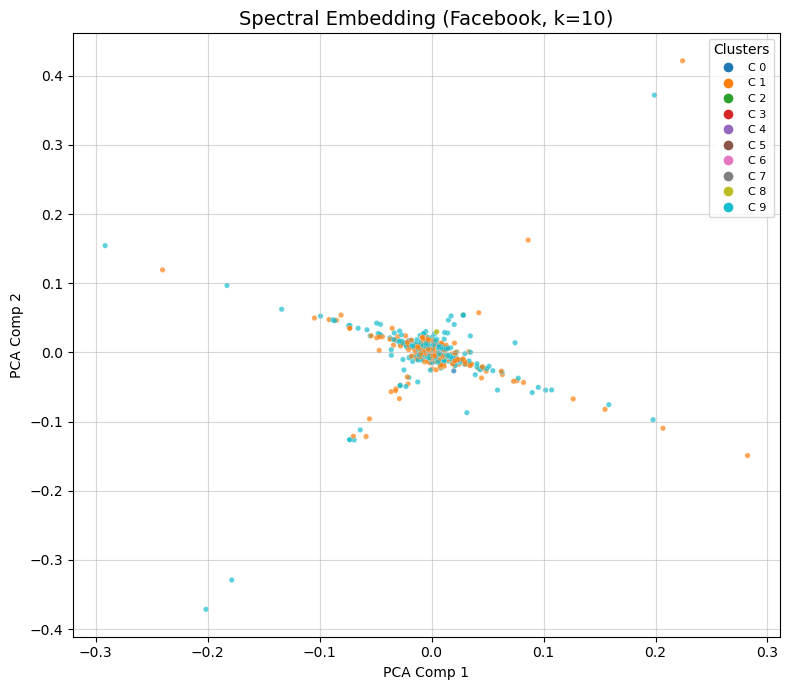


--- Plotting Per-Cluster Silhouette Scores: Spectral (Facebook) (k=10) ---


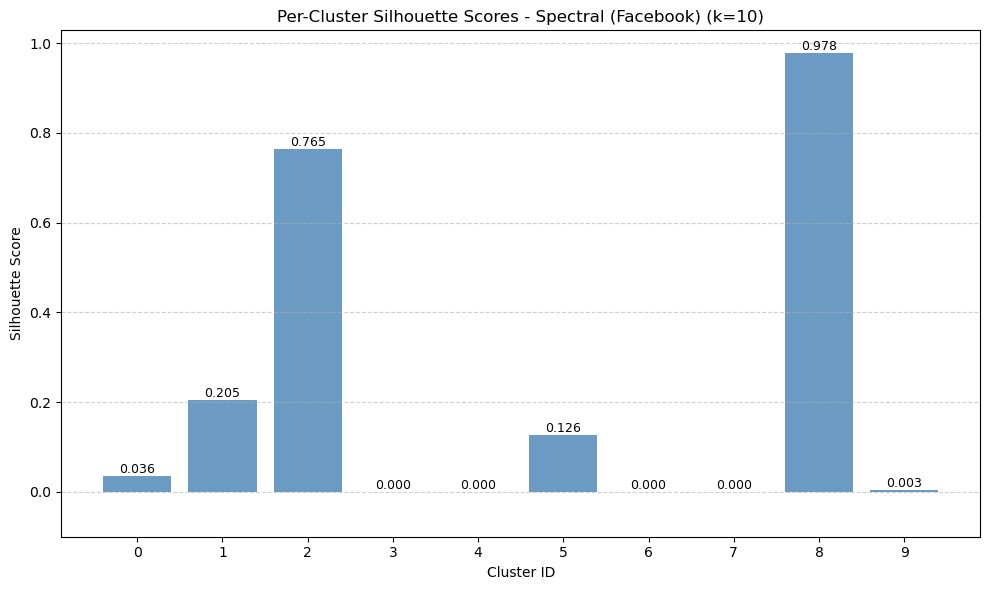

--- Starting Node2Vec Embedding ---
  Setting random seeds (seed=42)...
  Preprocessing graph for Node2Vec (4039 nodes)...
  Initializing Node2Vec...
  Fitting Node2Vec model...
  Extracting embeddings...
  Extracted embedding matrix shape: (4039, 64)
--- Embedding Info: Node2Vec (Facebook) ---
  Embedding dimension: 64
  Nodes with embeddings: 4039
  Sample embeddings (first 5):
    Node 0: [ 1.0469 -2.425   0.7276 -1.4576] ...
    Node 1: [ 1.2522 -1.4217 -0.5425 -0.024 ] ...
    Node 2: [ 0.8386 -0.3944 -0.626  -0.3734] ...
    Node 3: [ 0.911  -0.8237  0.1324 -0.2292] ...
    Node 4: [ 0.8664 -0.9692 -0.2137 -1.1276] ...
--- Starting Clustering Evaluation (k=10) ---
  Sample size 20000 >= data points 4039. Using all points.
  Running KMeans clustering on 4039 points...
  Calculating Overall Silhouette Score...
  Overall Silhouette Score: 0.2392
  Calculating Per-Cluster Silhouette Scores...
    Per-cluster scores:
      Cluster 0: 0.2429
      Cluster 1: 0.0819
      Cluster 2: 0.1

/var/folders/30/by5mgpsd0bs53jj017b7c5km0000gn/T/ipykernel_902/2333455478.py:223: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10' if num_clusters_in_plot <= 10 else cmap_name, num_clusters_in_plot)


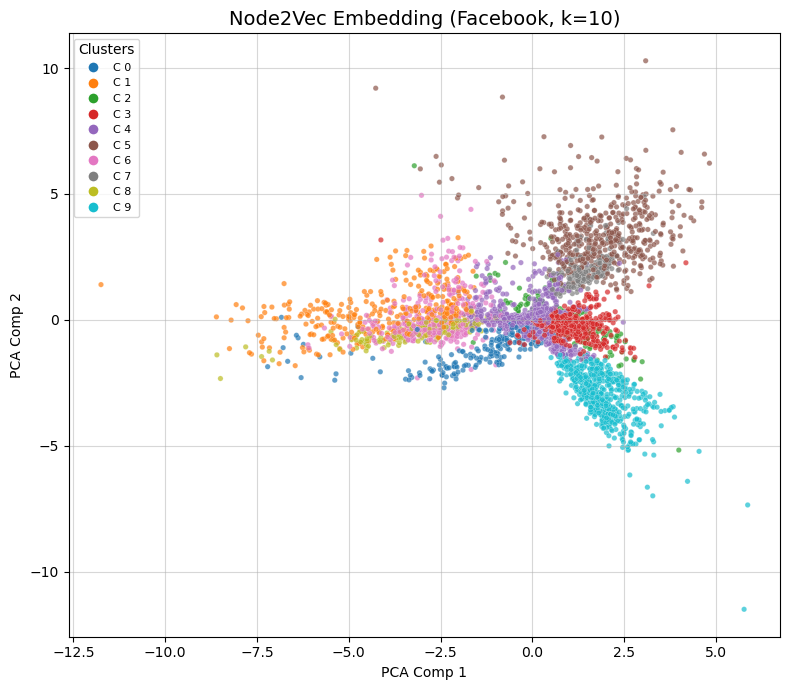


--- Plotting Per-Cluster Silhouette Scores: Node2Vec (Facebook) (k=10) ---


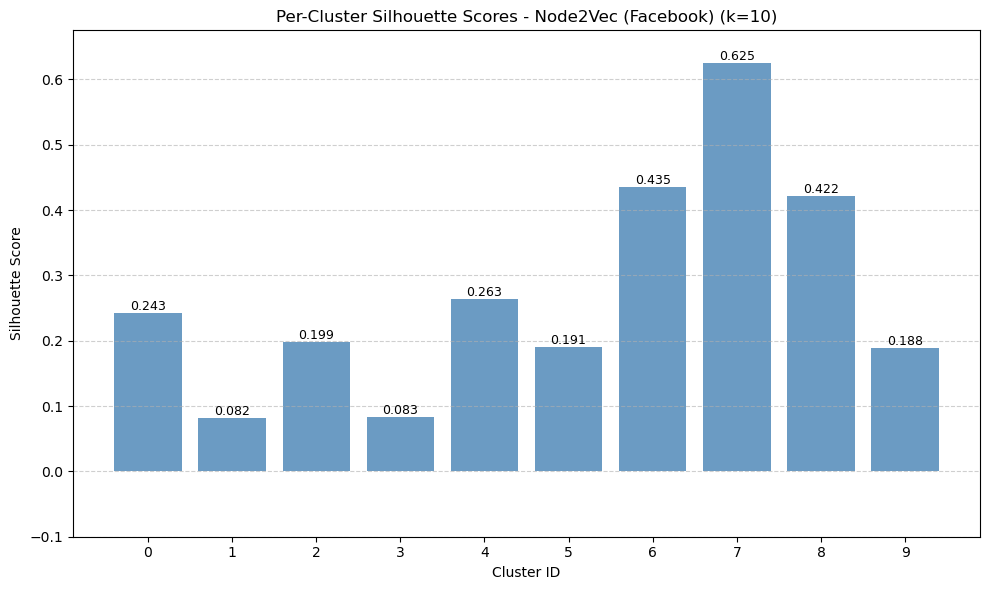


--- Processing Twitter Graph (81306 nodes) ---

--- Skipping Spectral Embedding for directed Twitter graph ---
--- Starting Node2Vec Embedding ---
  Setting random seeds (seed=42)...
  Preprocessing graph for Node2Vec (81306 nodes)...
  Initializing Node2Vec...
  Fitting Node2Vec model...
  Extracting embeddings...
  Extracted embedding matrix shape: (81306, 64)
--- Embedding Info: Node2Vec (Twitter) ---
  Embedding dimension: 64
  Nodes with embeddings: 81306
  Sample embeddings (first 5):
    Node 214328887: [-0.812   0.3522 -1.6127 -0.3083] ...
    Node 34428380: [-0.0439 -0.4562 -0.8067  2.336 ] ...
    Node 17116707: [-1.0143 -0.0988 -1.903  -0.566 ] ...
    Node 28465635: [-0.7158 -1.3406 -3.1558 -0.5742] ...
    Node 380580781: [-1.0812  0.2148 -2.2251 -0.3972] ...
--- Starting Clustering Evaluation (k=10) ---
  Sampling 20000 points for clustering evaluation...
  Running KMeans clustering on 20000 points...
  Calculating Overall Silhouette Score...
  Overall Silhouette Score: 

/var/folders/30/by5mgpsd0bs53jj017b7c5km0000gn/T/ipykernel_902/2333455478.py:223: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10' if num_clusters_in_plot <= 10 else cmap_name, num_clusters_in_plot)


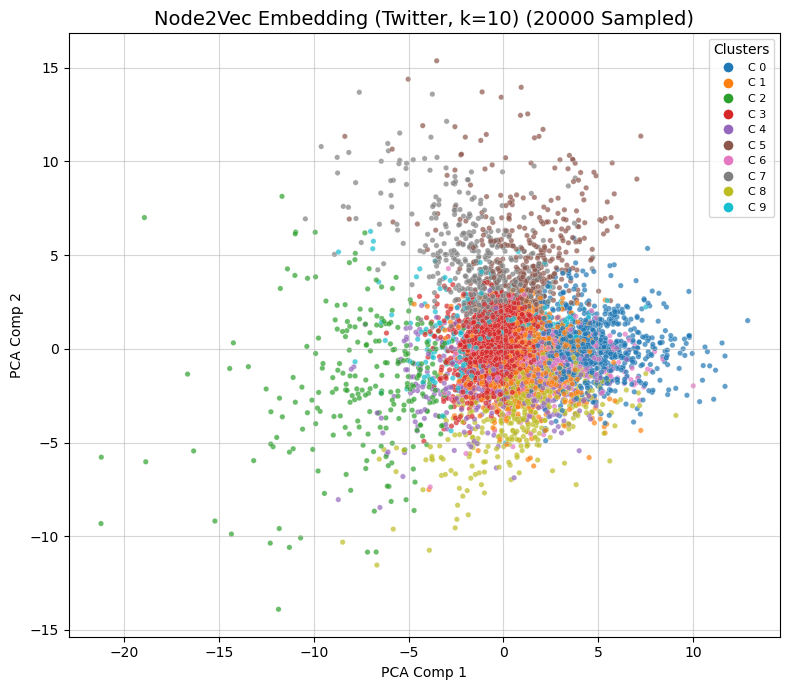


--- Plotting Per-Cluster Silhouette Scores: Node2Vec (Twitter) (k=10) ---


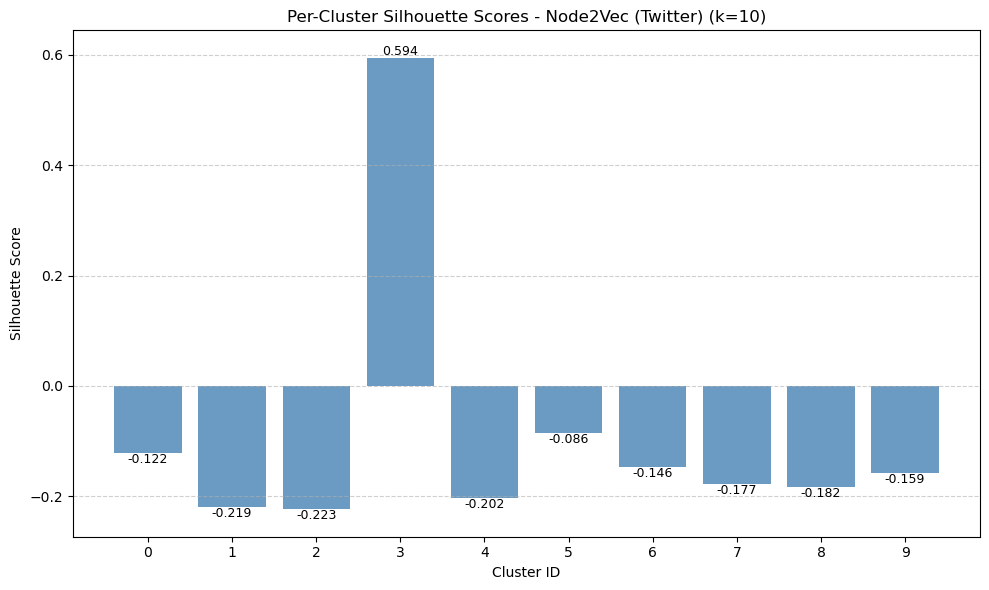


Embedding Analysis Summary
Overall Silhouette Scores (k=10):
- Spectral (Facebook): 0.1031
- Node2Vec (Facebook): 0.2392
- Node2Vec (Twitter):  0.3624


In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse.linalg import eigsh # For spectral embedding
from scipy.sparse import SparseEfficiencyWarning
import warnings # To filter warnings if needed
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples # Added silhouette_samples
from sklearn.decomposition import PCA
from node2vec import Node2Vec # Make sure this library is installed
import random # Import random for setting seeds


# --- Functions (evaluate_clustering, spectral_embedding, run_node2vec, print_embedding_info, plot_embedding, plot_silhouette_per_cluster) ---
# Assume these functions are defined above as in the previous responses,
# including the modified evaluate_clustering and the new plot_silhouette_per_cluster

def evaluate_clustering(emb_matrix, nodes, n_clusters=5, seed=42, sample_size=None): # Added sample_size

    print(f"--- Starting Clustering Evaluation (k={n_clusters}) ---")
    if emb_matrix is None or emb_matrix.shape[0] < n_clusters:
        print(f"  Not enough data points ({emb_matrix.shape[0] if emb_matrix is not None else 0}) for {n_clusters} clusters. Skipping clustering.")
        # Return empty dict, NaN score, empty per-cluster scores
        return {}, np.nan, {} # <--- MODIFIED RETURN

    matrix_to_cluster = emb_matrix
    nodes_for_clustering = nodes

    if sample_size is not None and emb_matrix.shape[0] > sample_size:
        print(f"  Sampling {sample_size} points for clustering evaluation...")
        np.random.seed(seed)
        sample_indices = np.random.choice(emb_matrix.shape[0], size=sample_size, replace=False)
        matrix_to_cluster = emb_matrix[sample_indices]
        nodes_for_clustering = [nodes[i] for i in sample_indices]
    elif sample_size is not None:
         print(f"  Sample size {sample_size} >= data points {emb_matrix.shape[0]}. Using all points.")

    print(f"  Running KMeans clustering on {matrix_to_cluster.shape[0]} points...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto')
    cluster_labels_array = kmeans.fit_predict(matrix_to_cluster)

    print(f"  Calculating Overall Silhouette Score...")
    overall_score = np.nan
    per_cluster_scores = {} # <--- INITIALIZE dictionary for per-cluster scores
    n_labels = 0

    try:
        unique_labels = np.unique(cluster_labels_array)
        n_labels = len(unique_labels)
        if n_labels > 1 and matrix_to_cluster.shape[0] > n_clusters :
            # Calculate overall score
            overall_score = silhouette_score(matrix_to_cluster, cluster_labels_array)
            print(f"  Overall Silhouette Score: {overall_score:.4f}")

            # --- Calculate per-cluster scores --- # <--- ADDED BLOCK ---
            print(f"  Calculating Per-Cluster Silhouette Scores...")
            sample_silhouette_values = silhouette_samples(matrix_to_cluster, cluster_labels_array)

            for i in range(n_clusters): # Iterate up to n_clusters to capture all potential cluster IDs
                # Aggregate the silhouette scores for samples belonging to cluster i, and compute the average
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels_array == i]

                # Check if the cluster actually has any members assigned to it
                if ith_cluster_silhouette_values.size > 0:
                    per_cluster_scores[i] = ith_cluster_silhouette_values.mean()
                else:
                     # Assign NaN or skip if cluster is empty (depends on desired output)
                     per_cluster_scores[i] = np.nan
                     # print(f"      Cluster {i}: Empty (no samples assigned)") # Optional message

            # Optionally print per-cluster scores here
            print("    Per-cluster scores:")
            for cluster_id, score in sorted(per_cluster_scores.items()):
                 score_str = f"{score:.4f}" if not np.isnan(score) else "N/A (Empty)"
                 print(f"      Cluster {cluster_id}: {score_str}")
            # --- End of added block ---

        else:
            print(f"  Warning: Cannot calculate silhouette score (found {n_labels} labels for {matrix_to_cluster.shape[0]} points).")

    except ValueError as e:
        print(f"  Could not calculate silhouette score: {e}")

    node_cluster_labels = {node: label for node, label in zip(nodes_for_clustering, cluster_labels_array)}

    # Return node labels, overall score, AND per-cluster scores
    return node_cluster_labels, overall_score, per_cluster_scores # <--- MODIFIED RETURN

def spectral_embedding(G, dim=64, seed=42):
    print("--- Starting Spectral Embedding ---")
    if G.number_of_nodes() == 0:
        print("  Graph is empty, cannot compute spectral embedding.")
        return {}, None, []
    print(f"  Preprocessing graph ({G.number_of_nodes()} nodes)...")
    graph_undirected = nx.Graph(G)
    graph_undirected.remove_edges_from(nx.selfloop_edges(graph_undirected))
    num_nodes = graph_undirected.number_of_nodes()
    if num_nodes <= 1:
        print("  Graph has 0 or 1 node after preprocessing.")
        return {}, None, list(graph_undirected.nodes())
    if not nx.is_connected(graph_undirected):
        print("  Warning: Graph is disconnected. Using largest component.")
        largest_cc = max(nx.connected_components(graph_undirected), key=len)
        graph_undirected = graph_undirected.subgraph(largest_cc).copy()
        num_nodes = graph_undirected.number_of_nodes()
        print(f"  Using largest connected component ({num_nodes} nodes).")
        if num_nodes <= 1: return {}, None, list(graph_undirected.nodes())

    print(f"  Calculating normalized Laplacian for {num_nodes} nodes...")
    node_order = list(graph_undirected.nodes())
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=SparseEfficiencyWarning)
            L_norm = nx.normalized_laplacian_matrix(graph_undirected, nodelist=node_order)
    except Exception as e:
        print(f"  Error calculating normalized Laplacian: {e}")
        return {}, None, node_order

    print(f"  Computing {dim+1} smallest magnitude eigenvalues/vectors...")
    eigenvals, eigenvecs = None, None
    k_eig = min(dim + 1, num_nodes - 1)
    if k_eig < 1:
         print(f"  Graph too small for non-trivial spectral embedding.")
         return {}, None, node_order

    try:
        np.random.seed(seed)
        eigenvals, eigenvecs = eigsh(L_norm, k=k_eig, which='SM', tol=1e-6, sigma=0, maxiter=num_nodes*5)
    except Exception as e:
        print(f"  Error computing eigenvalues/vectors: {e}")
        return {}, None, node_order

    print(f"  Eigendecomposition finished. Processing {eigenvecs.shape[1]} vectors.")
    if eigenvecs.shape[1] <= 1:
         print("  Warning: Only trivial eigenvector found.")
         return {}, None, node_order

    actual_dim = min(dim, eigenvecs.shape[1] - 1)
    if actual_dim < dim: print(f"  Warning: Using dim={actual_dim}.")
    if actual_dim <= 0: print(f"  Error: No non-trivial eigenvectors."); return {}, None, node_order

    emb = eigenvecs[:, 1 : actual_dim + 1]
    print(f"  Extracted embedding matrix shape: {emb.shape}")
    emb_dict = {node: emb[i, :] for i, node in enumerate(node_order)}
    return emb_dict, emb, node_order


def run_node2vec(G, dimensions=64, walk_length=30, num_walks=10, workers=4, window=10, seed=42):
    print(f"--- Starting Node2Vec Embedding ---")
    if G.number_of_nodes() == 0:
         print("  Graph is empty.")
         return {}, None, []
    print(f"  Setting random seeds (seed={seed})...")
    random.seed(seed)
    np.random.seed(seed)
    print(f"  Preprocessing graph for Node2Vec ({G.number_of_nodes()} nodes)...")
    original_nodes = list(G.nodes())
    if not all(isinstance(n, str) for n in original_nodes):
        G_str = nx.relabel_nodes(G, {node: str(node) for node in original_nodes}, copy=True)
    else:
        G_str = G
    print(f"  Initializing Node2Vec...")
    node2vec = Node2Vec(G_str, dimensions=dimensions, walk_length=walk_length,
                        num_walks=num_walks, workers=workers, quiet=True)
    print("  Fitting Node2Vec model...")
    model = None
    try:
        model = node2vec.fit(window=window, min_count=1, batch_words=4, seed=seed)
    except Exception as e:
        print(f"  Error during Node2Vec fitting: {e}")
        return {}, None, []
    print("  Extracting embeddings...")
    emb_dict, emb_matrix_list, valid_nodes = {}, [], []
    if model and hasattr(model, 'wv'):
        for node in original_nodes:
            node_str = str(node)
            if node_str in model.wv:
                emb_dict[node] = model.wv[node_str]
                emb_matrix_list.append(model.wv[node_str])
                valid_nodes.append(node)
    else: print("  Error: Model or word vectors not available."); return {}, None, []
    if not emb_matrix_list: print("  Error: No embeddings extracted."); return {}, None, []
    emb_matrix = np.array(emb_matrix_list)
    print(f"  Extracted embedding matrix shape: {emb_matrix.shape}")
    return emb_dict, emb_matrix, valid_nodes


def print_embedding_info(method_name, emb_dict, nodes_with_embeddings):
    print(f"--- Embedding Info: {method_name} ---")
    if not emb_dict or not nodes_with_embeddings: print("  No embeddings."); return
    try: dims = emb_dict[nodes_with_embeddings[0]].shape[0]; print(f"  Embedding dimension: {dims}")
    except: print("  Could not determine dimension.")
    print(f"  Nodes with embeddings: {len(emb_dict)}")
    print(f"  Sample embeddings (first 5):")
    for i, node in enumerate(nodes_with_embeddings[:5]):
        vector_str = np.array2string(emb_dict[node][:4], precision=4, suppress_small=True) + " ..."
        print(f"    Node {node}: {vector_str}")


def plot_embedding(emb_matrix, nodes_with_embeddings, title="Embedding visualization (PCA)",
                   cluster_labels=None, cmap_name='viridis', sample_size=2000, seed=42):
    print(f"--- Starting Visualization: {title} ---")
    if emb_matrix is None or emb_matrix.shape[0] < 2: print(f"  Not enough data points."); return
    if emb_matrix.shape[1] < 2: print(f"  Embedding dimension < 2."); return
    matrix_to_plot, nodes_for_plot, plot_title = emb_matrix, nodes_with_embeddings, title
    if emb_matrix.shape[0] > sample_size:
        print(f"  Sampling {sample_size} points...")
        np.random.seed(seed); sample_indices = np.random.choice(emb_matrix.shape[0], size=sample_size, replace=False)
        matrix_to_plot = emb_matrix[sample_indices]; nodes_for_plot = [nodes_with_embeddings[i] for i in sample_indices]
        plot_title = f"{title} ({sample_size} Sampled)"
    print(f"  Running PCA...")
    try: pca = PCA(n_components=2, random_state=seed); emb_2d = pca.fit_transform(matrix_to_plot)
    except Exception as e: print(f"  PCA failed: {e}"); return
    print("  Plotting...")
    plt.figure(figsize=(8, 7)); colors_for_plot, unique_labels_in_plot = None, []
    if cluster_labels is not None:
         ordered_labels = [cluster_labels.get(node, -1) for node in nodes_for_plot]
         unique_labels_in_plot = sorted(list(set(l for l in ordered_labels if l != -1)))
         num_clusters_in_plot = len(unique_labels_in_plot)
         if num_clusters_in_plot > 0:
            cmap = plt.cm.get_cmap('tab10' if num_clusters_in_plot <= 10 else cmap_name, num_clusters_in_plot)
            label_to_cmap_idx = {label: i for i, label in enumerate(unique_labels_in_plot)}
            colors_for_plot = [cmap(label_to_cmap_idx.get(label)) if label != -1 else (0.8, 0.8, 0.8, 0.5) for label in ordered_labels]
         else: print("    No valid cluster labels found.")
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors_for_plot, s=15, alpha=0.7, edgecolors='w', linewidth=0.2)
    plt.title(plot_title, fontsize=14); plt.xlabel("PCA Comp 1"); plt.ylabel("PCA Comp 2"); plt.grid(True, alpha=0.5)
    if colors_for_plot is not None and num_clusters_in_plot > 0:
         handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'C {label}', markerfacecolor=cmap(label_to_cmap_idx[label]), markersize=8) for label in unique_labels_in_plot]
         plt.legend(handles=handles, title="Clusters", fontsize=8, loc='best')
    plt.tight_layout(); plt.show()


def plot_silhouette_per_cluster(per_cluster_scores, method_name, n_clusters):
    """
    Plots a bar chart showing the Silhouette score for each individual cluster.

    Args:
        per_cluster_scores (dict): Dictionary mapping cluster ID to its Silhouette score.
        method_name (str): Name of the embedding method and graph (e.g., "Spectral (Facebook)").
        n_clusters (int): The target number of clusters (k).
    """
    print(f"\n--- Plotting Per-Cluster Silhouette Scores: {method_name} (k={n_clusters}) ---")

    if not per_cluster_scores:
        print("  No per-cluster scores available to plot.")
        return

    # Sort scores by cluster ID for consistent plotting
    sorted_scores = sorted(per_cluster_scores.items())
    cluster_ids = [item[0] for item in sorted_scores]
    scores = [item[1] for item in sorted_scores]

    # Handle potential NaN scores if calculation failed for some clusters
    scores_numeric = [s if not np.isnan(s) else 0 for s in scores] # Plot NaN as 0

    x_pos = np.arange(len(cluster_ids))

    fig, ax = plt.subplots(figsize=(10, 6)) # Adjusted figure size
    bars = ax.bar(x_pos, scores_numeric, align='center', alpha=0.8, color='steelblue')
    ax.set_ylabel('Silhouette Score')
    ax.set_xlabel('Cluster ID')
    ax.set_xticks(x_pos)
    # Ensure only integer labels are shown for cluster IDs
    ax.set_xticklabels([int(cid) for cid in cluster_ids])
    ax.set_title(f'Per-Cluster Silhouette Scores - {method_name} (k={n_clusters})')
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    # Silhouette scores range from -1 to 1
    # Calculate min/max ignoring NaNs
    valid_scores = [s for s in scores if not np.isnan(s)]
    min_score = min(valid_scores) if valid_scores else -0.1
    max_score = max(valid_scores) if valid_scores else 0.1
    ax.set_ylim(bottom=min(-0.1, min_score - 0.05),
                top=max(0.1, max_score + 0.05))

    # Add score labels on top of bars
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        label_text = f"{scores[i]:.3f}" if not np.isnan(scores[i]) else "N/A"
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, label_text,
                 va='bottom' if yval >= 0 else 'top', ha='center', fontsize=9) # Adjust label position and size

    plt.tight_layout()
    plt.show()


# ---------------------------
# Main Analysis
# ---------------------------
def main():
    # --- Ensure graphs are loaded ---
    # Placeholder for actual graph loading if run standalone
    global facebook_graph, twitter_graph
    try:
        _ = facebook_graph
        _ = twitter_graph
    except NameError:
        print("="*60)
        print("WARNING: `facebook_graph` and/or `twitter_graph` not found.")
        print("Attempting to load placeholder graphs for demonstration.")
        try:
            # Create small placeholder graphs if not loaded
            facebook_graph = nx.karate_club_graph()
            twitter_graph = nx.gnp_random_graph(100, 0.05, directed=True, seed=42) # Added seed
            print("Loaded placeholder graphs.")
        except Exception as e:
             print(f"ERROR: Could not load placeholder graphs: {e}")
             print("Please load your NetworkX graph objects into these variables before calling main().")
             print("="*60)
             return
        print("="*60)


    print("="*30 + "\nStarting Embedding Analysis\n" + "="*30)

    graph_data = {
        "Facebook": facebook_graph,
        "Twitter": twitter_graph
    }
    results = {}

    # --- Settings ---
    EMBEDDING_DIM = 64
    N_CLUSTERS = 10 # Using 10 clusters as per the original context
    N2V_WALK_LENGTH = 25
    N2V_NUM_WALKS = 10
    N2V_WORKERS = 4 # Adjust based on your system cores
    RANDOM_SEED = 42
    CLUSTER_SAMPLE_SIZE = 20000 # Use None to disable sampling here
    PLOT_SAMPLE_SIZE = 20000

    # --- Process Facebook Graph ---
    fb_name = "Facebook"
    if fb_name in graph_data:
        fb_graph = graph_data[fb_name]
        print(f"\n--- Processing {fb_name} Graph ({fb_graph.number_of_nodes()} nodes) ---")

        # 1. Spectral Embedding (Facebook)
        spec_emb_dict_fb, spec_emb_matrix_fb, spec_nodes_fb = spectral_embedding(
            fb_graph, dim=EMBEDDING_DIM, seed=RANDOM_SEED
        )
        if spec_nodes_fb and spec_emb_matrix_fb is not None: # Check matrix exists
            print_embedding_info("Spectral (Facebook)", spec_emb_dict_fb, spec_nodes_fb)
            spec_labels_fb, spec_score_fb, spec_per_cluster_fb = evaluate_clustering(
                 spec_emb_matrix_fb, nodes=spec_nodes_fb, n_clusters=N_CLUSTERS,
                 sample_size=CLUSTER_SAMPLE_SIZE, seed=RANDOM_SEED
            )
            results[f"{fb_name}_Spectral_Score"] = spec_score_fb
            cluster_sample_info = f"sample={CLUSTER_SAMPLE_SIZE}" if CLUSTER_SAMPLE_SIZE is not None and spec_emb_matrix_fb.shape[0] > CLUSTER_SAMPLE_SIZE else "all"
            score_str = f"{spec_score_fb:.4f}" if not np.isnan(spec_score_fb) else "N/A"
            print(f"  --> Overall Silhouette Score (k={N_CLUSTERS}, points={cluster_sample_info}): {score_str}")
            plot_embedding(spec_emb_matrix_fb, spec_nodes_fb,
                           title=f"Spectral Embedding (Facebook, k={N_CLUSTERS})",
                           cluster_labels=spec_labels_fb, sample_size=PLOT_SAMPLE_SIZE, seed=RANDOM_SEED)
            plot_silhouette_per_cluster(spec_per_cluster_fb, "Spectral (Facebook)", N_CLUSTERS)
        else:
            results[f"{fb_name}_Spectral_Score"] = np.nan
            print("Spectral embedding failed or produced no results.")

        # 2. Node2Vec Embedding (Facebook)
        fb_n2v_dict, fb_n2v_matrix, fb_n2v_nodes = run_node2vec(
            fb_graph, dimensions=EMBEDDING_DIM, walk_length=N2V_WALK_LENGTH,
            num_walks=N2V_NUM_WALKS, workers=N2V_WORKERS, seed=RANDOM_SEED
        )
        if fb_n2v_nodes and fb_n2v_matrix is not None: # Check matrix exists
            print_embedding_info("Node2Vec (Facebook)", fb_n2v_dict, fb_n2v_nodes)
            fb_n2v_labels, fb_n2v_score, fb_n2v_per_cluster = evaluate_clustering(
                fb_n2v_matrix, nodes=fb_n2v_nodes, n_clusters=N_CLUSTERS,
                sample_size=CLUSTER_SAMPLE_SIZE, seed=RANDOM_SEED
            )
            results[f"{fb_name}_Node2Vec_Score"] = fb_n2v_score
            cluster_sample_info = f"sample={CLUSTER_SAMPLE_SIZE}" if CLUSTER_SAMPLE_SIZE is not None and fb_n2v_matrix.shape[0] > CLUSTER_SAMPLE_SIZE else "all"
            score_str = f"{fb_n2v_score:.4f}" if not np.isnan(fb_n2v_score) else "N/A"
            print(f"  --> Overall Silhouette Score (k={N_CLUSTERS}, points={cluster_sample_info}): {score_str}")
            plot_embedding(fb_n2v_matrix, fb_n2v_nodes,
                           title=f"Node2Vec Embedding (Facebook, k={N_CLUSTERS})",
                           cluster_labels=fb_n2v_labels, sample_size=PLOT_SAMPLE_SIZE, seed=RANDOM_SEED)
            plot_silhouette_per_cluster(fb_n2v_per_cluster, "Node2Vec (Facebook)", N_CLUSTERS)
        else:
            results[f"{fb_name}_Node2Vec_Score"] = np.nan
            print("Node2Vec embedding failed or produced no results.")
    else:
        print(f"\n--- Skipping {fb_name} Graph (not found in graph_data) ---")


    # --- Process Twitter Graph ---
    tw_name = "Twitter"
    if tw_name in graph_data:
        tw_graph = graph_data[tw_name]
        print(f"\n--- Processing {tw_name} Graph ({tw_graph.number_of_nodes()} nodes) ---")

        # Spectral embedding is typically not applied directly to large directed graphs
        print("\n--- Skipping Spectral Embedding for directed Twitter graph ---")

        # 3. Node2Vec Embedding (Twitter)
        tw_n2v_dict, tw_n2v_matrix, tw_n2v_nodes = run_node2vec(
            tw_graph, dimensions=EMBEDDING_DIM, walk_length=N2V_WALK_LENGTH,
            num_walks=N2V_NUM_WALKS, workers=N2V_WORKERS, seed=RANDOM_SEED
        )
        if tw_n2v_nodes and tw_n2v_matrix is not None: # Check matrix exists
            print_embedding_info("Node2Vec (Twitter)", tw_n2v_dict, tw_n2v_nodes)
            tw_n2v_labels, tw_n2v_score, tw_n2v_per_cluster = evaluate_clustering(
                tw_n2v_matrix, nodes=tw_n2v_nodes, n_clusters=N_CLUSTERS,
                sample_size=CLUSTER_SAMPLE_SIZE, seed=RANDOM_SEED
            )
            results[f"{tw_name}_Node2Vec_Score"] = tw_n2v_score
            cluster_sample_info = f"sample={CLUSTER_SAMPLE_SIZE}" if CLUSTER_SAMPLE_SIZE is not None and tw_n2v_matrix.shape[0] > CLUSTER_SAMPLE_SIZE else "all"
            score_str = f"{tw_n2v_score:.4f}" if not np.isnan(tw_n2v_score) else "N/A"
            print(f"  --> Overall Silhouette Score (k={N_CLUSTERS}, points={cluster_sample_info}): {score_str}")
            plot_embedding(tw_n2v_matrix, tw_n2v_nodes,
                           title=f"Node2Vec Embedding (Twitter, k={N_CLUSTERS})",
                           cluster_labels=tw_n2v_labels, sample_size=PLOT_SAMPLE_SIZE, seed=RANDOM_SEED)
            plot_silhouette_per_cluster(tw_n2v_per_cluster, "Node2Vec (Twitter)", N_CLUSTERS)
        else:
            results[f"{tw_name}_Node2Vec_Score"] = np.nan
            print("Node2Vec embedding failed or produced no results.")
    else:
         print(f"\n--- Skipping {tw_name} Graph (not found in graph_data) ---")


    # --- Final Summary ---
    print("\n" + "="*30 + "\nEmbedding Analysis Summary\n" + "="*30)
    print(f"Overall Silhouette Scores (k={N_CLUSTERS}):") # Clarified this is overall score
    spec_fb_score = results.get(f'{fb_name}_Spectral_Score', np.nan)
    n2v_fb_score = results.get(f'{fb_name}_Node2Vec_Score', np.nan)
    n2v_tw_score = results.get(f'{tw_name}_Node2Vec_Score', np.nan)
    spec_fb_str = f"{spec_fb_score:.4f}" if not np.isnan(spec_fb_score) else "N/A"
    n2v_fb_str = f"{n2v_fb_score:.4f}" if not np.isnan(n2v_fb_score) else "N/A"
    n2v_tw_str = f"{n2v_tw_score:.4f}" if not np.isnan(n2v_tw_score) else "N/A"
    print(f"- Spectral (Facebook): {spec_fb_str}")
    print(f"- Node2Vec (Facebook): {n2v_fb_str}")
    print(f"- Node2Vec (Twitter):  {n2v_tw_str}")
    print("="*30)

    # --- plot_embedding_quality call is REMOVED as requested ---


if __name__ == "__main__":
    main()

**Facebook** : 
The spectral Silhouette score is very high : KMeans found extremely distinct and well-separated clusters. Nodes within a cluster are very similar in this embedding space, and clusters are far apart. 

The Node2Vec silhouette score is lower, some clustering structure are present, but the clusters are significantly less distinct and more overlapping. The 2D PCA plot shows visually distinct clusters of different colors. The clusters are spread out and separable to the eye, although there is some mixing at the boundaries. 

**Twitter**
Twitter is large and directed, so no spectral embeddings

The Silhouette score for N2V is very low. The clusters overlap. The PCA plot confirms the low score. It shows a dense "ball" of points where the different color clusters are heavily intermingled with no clear separation. The complexity, scale, directed nature, and potentially different kind of community structure (compared to Facebook) make this a much harder task for this embedding+clustering combination. 

### Addition :
Silhouette score per cluster

**Facebook** : 
Spectral embedding leads to a few outstandingly good clusters but completely fails to form meaningful, separated clusters for the rest. The high overall average score (~0.769) is heavily skewed by the few excellent clusters  and hides the fact that most clusters are poorly defined (score near 0).

Node2Vec captures structure that allows KMeans to form clusters that are all at least somewhat meaningful (all positive scores). No single cluster is as exceptionally well-separated as the best ones from Spectral, but there isn't a widespread failure like Spectral showed for many clusters. 

**Twitter**
Node2Vec embedding combined with KMeans struggles significantly. The negative scores for 9 out of 10 clusters indicate that, on average, nodes within these clusters are closer to nodes in other clusters. This points to heavy overlap and poor separation. Only one cluster (Cluster 3) seems to represent a somewhat distinct community.


# GCN For the Facebook graph

**Graph Neural Network (GNN)**

A graph neural network is a neural model that we can apply directly to graphs without prior knowledge of every component within the graph. GNN provides a convenient way for node level, edge level and graph level prediction tasks.

In GNNs, neighbors and connections define nodes. If we remove the neighbors and connections around a node, then the node will lose all its information. Therefore, the neighbors of a node and connections to neighbors define the concept of the node itself.

 The task of all GNN is to determine the node embedding for each node by looking at the information on its neighboring nodes.

 Here, we will be using Graph convolutional networks (GCNs) that are one of the most popular types of GNNs. They function similarly to convolutional neural networks (CNNs) because the Facebook graph is structural and unlabelled so it is well-suited to capture its local and global connectivity patterns.[Reference for this study](https://builtin.com/data-science/gnn)


*    We use PyTorch for neural network training and PyTorch Geometric (PyG) for graph layers and utilities
*   We keep  only the largest connected component to avoid isolated nodes and disconnected structure
*   Since the dataset doesn't have node features, we assign every node the same dummy feature: [1.0]
*   We then splits the edges into train, validation, and test sets
*   We define a 2-layer GCN with the first layer taking as input one feature per node and outputs the number of neurons in the hidden layer (size of embeddings) ; its main utility is to learn how to mix information from a node and its neighbors. The second layer input and output the hidden channels; this layer refines the embeddings further by again aggregating neighbor info.
*  The encode function builds node embeddings by first combining information from each node's direct neighbors (1-hop) using a GCN layer, then applying a ReLU activation and dropout to avoid overfitting. It passes the result through a second GCN layer to include information from 2-hop neighbors. The final output is a learned vector (embedding) for each node.
* Now the decode function is used for link prediction: we take the dot product between the embedding of two nodes and then we add up the values across columns, row by row to compute a single score from node embedding pairs .If the result is high, it means the model thinks a link probably exists between them
* The purpose of using a constrastive loss is to teach the model to give high scores to real edges (positive pairs) and low scores to fake edges (negative pairs) .For real (positive) edges, it uses -log(sigmoid(score)), which becomes small when the score is high, encouraging the model to connect them. For fake (negative) edges, it flips the sign and uses -log(sigmoid(-score)), which becomes small when the score is low, discouraging false links.
* We sets up the Adam optimizer that takes as parameter the learning rate and the weight decay
* The training class then set model to training mode (activates dropout) , compute node embeddings , generate fake edges using negative_sampling and then calculates the loss.
* We then use the test function to evaluates how well the model predicts which node pairs should or should not be connected, using the AUC (Area Under the Curve) score , the precision score (the proportion of predicted links that are actually correct) , the recall score (the proportion of true links that were successfully predicted) and finally the f1-score ( harmonic mean of precision and recall, providing a balanced measure of overall prediction quality. ; a common metric for binary classification).We deactivate the dropout while evaluating





In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, negative_sampling
from torch_geometric.utils import from_networkx
import networkx as nx

# Load the Facebook graph (edge list)
G = nx.read_edgelist("facebook_combined.txt", nodetype=int)
G = G.subgraph(max(nx.connected_components(G), key=len))

# Add dummy feature
for node in G.nodes:
    G.nodes[node]["x"] = [1.0]
data = from_networkx(G)
data.x = data.x.float()
data = train_test_split_edges(data)

# GCN model with dropout
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = dropout

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

# Contrastive loss function
#z: node embeddings (shape [num_nodes, hidden_dim])
#pos_edge_index: real edges (from the dataset)
#neg_edge_index: randomly sampled non-connected node pairs
def contrastive_loss(z, pos_edge_index, neg_edge_index):
    pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    return -F.logsigmoid(pos_score).mean() - F.logsigmoid(-neg_score).mean()

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64, dropout=0.5).to(device)
data = data.to(device)
#weight_decay = 5e-4: adds L2 regularization to prevent overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes)
    loss = contrastive_loss(z, data.train_pos_edge_index, neg_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()
#not to track gradients during this function
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_edge_index = data.test_pos_edge_index
    neg_edge_index = data.test_neg_edge_index
    pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))])
    y_score = torch.cat([pos_pred, neg_pred])
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y_true.cpu(), y_score.cpu())

# Run training
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        auc = test()
        model.eval()
        with torch.no_grad():
            z = model.encode(data.x, data.train_pos_edge_index)
            pos_edge_index = data.test_pos_edge_index
            neg_edge_index = data.test_neg_edge_index
            pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
            neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
            precision, recall, f1 = compute_prf(pos_pred, neg_pred)

        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")



/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 020, Loss: 1.3133, AUC: 0.7810, Precision: 0.5019, Recall: 0.9976, F1: 0.6679
Epoch 040, Loss: 1.2792, AUC: 0.7746, Precision: 0.5520, Recall: 0.9517, F1: 0.6987
Epoch 060, Loss: 1.2738, AUC: 0.7657, Precision: 0.5825, Recall: 0.9054, F1: 0.7089
Epoch 080, Loss: 1.2619, AUC: 0.7723, Precision: 0.5783, Recall: 0.9186, F1: 0.7098
Epoch 100, Loss: 1.2601, AUC: 0.7784, Precision: 0.5758, Recall: 0.9254, F1: 0.7099
Epoch 120, Loss: 1.2470, AUC: 0.7696, Precision: 0.5974, Recall: 0.8841, F1: 0.7130
Epoch 140, Loss: 1.2528, AUC: 0.7691, Precision: 0.6023, Recall: 0.8754, F1: 0.7136
Epoch 160, Loss: 1.2293, AUC: 0.7889, Precision: 0.5818, Recall: 0.9216, F1: 0.7133
Epoch 180, Loss: 1.2295, AUC: 0.7938, Precision: 0.5793, Recall: 0.9310, F1: 0.7142
Epoch 200, Loss: 1.2496, AUC: 0.7888, Precision: 0.5934, Recall: 0.9056, F1: 0.7170


For visualisation , we use **TSNE** to visualize high-dimensional data in 2D or 3D, while trying to preserve the structure of the data

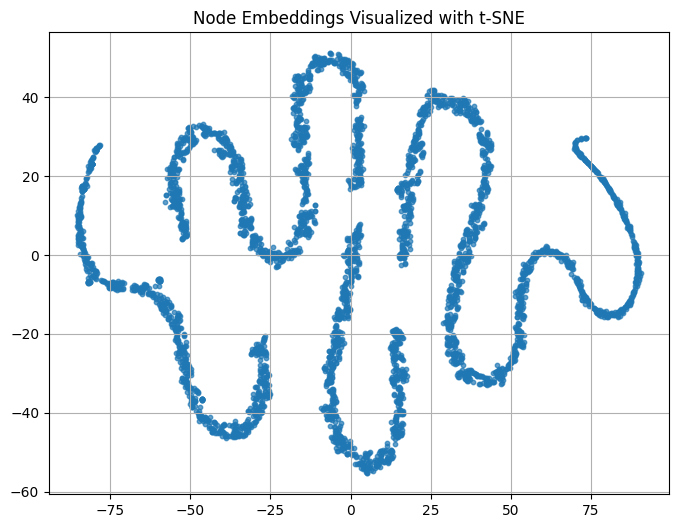

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
z = model.encode(data.x, data.train_pos_edge_index).cpu().detach()
z_2d = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10, alpha=0.7)
plt.title("Node Embeddings Visualized with t-SNE")
plt.grid(True)
plt.show()


Same approach but instead of using the dummy feature ,we're computing now two real features for each node in our graph:

1.   Normalized degree(how active or locally connected a node is)
2.   PageRank score( how globally influential the node is)

Then we combine them into a 2D feature vector per node.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, negative_sampling
from torch_geometric.utils import from_networkx
import networkx as nx

# Load the Facebook graph (edge list)
G = nx.read_edgelist("facebook_combined.txt", nodetype=int)
G = G.subgraph(max(nx.connected_components(G), key=len))

# Generate features: degree + PageRank
pagerank = nx.pagerank(G)
max_deg = max(dict(G.degree()).values())
for node in G.nodes:
    degree = G.degree[node] / max_deg
    pr = pagerank[node]
    G.nodes[node]["x"] = [degree, pr]

# Convert to PyG data object
data = from_networkx(G)
data.x = data.x.float()
data = train_test_split_edges(data)

# GCN model without dropout
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

# Contrastive loss function
def contrastive_loss(z, pos_edge_index, neg_edge_index):
    pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    return -F.logsigmoid(pos_score).mean() - F.logsigmoid(-neg_score).mean()

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes)
    loss = contrastive_loss(z, data.train_pos_edge_index, neg_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_edge_index = data.test_pos_edge_index
    neg_edge_index = data.test_neg_edge_index
    pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))])
    y_score = torch.cat([pos_pred, neg_pred])
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y_true.cpu(), y_score.cpu())

# Run training
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        auc = test()
        model.eval()
        with torch.no_grad():
            z = model.encode(data.x, data.train_pos_edge_index)
            pos_edge_index = data.test_pos_edge_index
            neg_edge_index = data.test_neg_edge_index
            pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
            neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
            precision, recall, f1 = compute_prf(pos_pred, neg_pred)

        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")



/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 020, Loss: 1.1850, AUC: 0.8328, Precision: 0.5626, Recall: 0.9696, F1: 0.7121
Epoch 040, Loss: 1.1160, AUC: 0.8040, Precision: 0.6307, Recall: 0.8751, F1: 0.7331
Epoch 060, Loss: 1.0978, AUC: 0.8266, Precision: 0.6336, Recall: 0.9645, F1: 0.7648
Epoch 080, Loss: 1.0880, AUC: 0.8533, Precision: 0.6261, Recall: 0.9695, F1: 0.7608
Epoch 100, Loss: 1.0875, AUC: 0.8566, Precision: 0.6253, Recall: 0.9580, F1: 0.7567
Epoch 120, Loss: 1.0860, AUC: 0.8537, Precision: 0.6252, Recall: 0.9594, F1: 0.7571
Epoch 140, Loss: 1.0839, AUC: 0.8537, Precision: 0.6247, Recall: 0.9600, F1: 0.7569
Epoch 160, Loss: 1.0867, AUC: 0.8518, Precision: 0.6234, Recall: 0.9602, F1: 0.7560
Epoch 180, Loss: 1.0853, AUC: 0.8551, Precision: 0.6221, Recall: 0.9628, F1: 0.7558
Epoch 200, Loss: 1.0827, AUC: 0.8605, Precision: 0.6222, Recall: 0.9631, F1: 0.7560


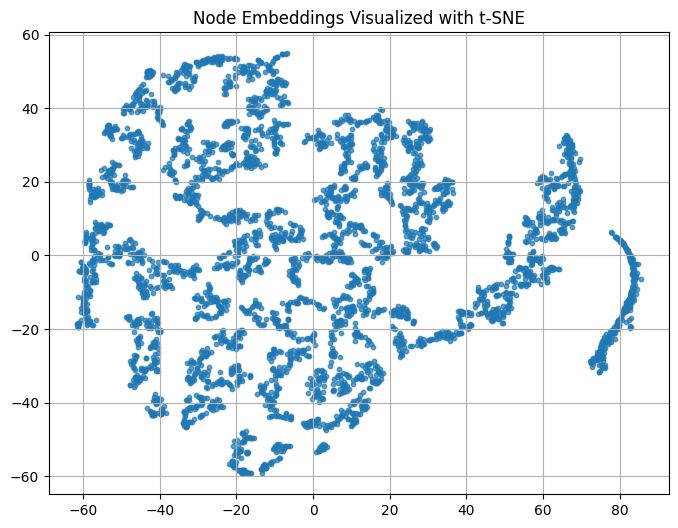

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
z = model.encode(data.x, data.train_pos_edge_index).cpu().detach()
z_2d = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10, alpha=0.7)
plt.title("Node Embeddings Visualized with t-SNE")
plt.grid(True)
plt.show()


*   **What is the defined task here?**

It is **link prediction** on a graph, using an unsupervised approach.
The goal is to predict whether an edge (connection) should exist between two nodes based on the graph structure and node features.

---



*  **Why choose this dataset for this task?**

Since the Facebook graph from the SNAP dataset is well-structured and unlabeled, it is a good fit for an unsupervised link prediction job.
We limited the graph to its greatest linked component in order to guarantee connectivity


---


* **What is the Training Strategy?**

Using a contrastive loss based on positive pairs—actual edges from the graph—and negative pairs—nonexistent edges produced by negative sampling—we chose an unsupervised contrastive training strategy.
By encouraging the model to push unconnected nodes apart and bring connected nodes closer together in the embedding space, the GNN is able to acquire meaningful node representations without the need for labels.


---


*  **Why did we choose only 2 layers?**

Increasing the depth of a GNN does not necessarily improve performance.
As more layers are added, each node aggregates information from increasingly distant neighbors, which can lead to over-smoothing


---
*  **What approach did we use for node feature initialization and Neighborhood Encoding?**

We compared two different approaches ; first using the dummy feature and then using normalized node degree (local centrality) and PageRank (global importance)
that gave us better results because it helps the model start with a more informative embedding space.Furthermore, by using GCN layers, the model aggregates information from neighbors at each layer, allowing it to reconstruct the local structure of the graph (1-hop, then 2-hop neighborhoods).


---

*  **What is the aggregation function used in this case?**

The aggregation function is a weighted average of neighboring node features, including the node itself (via self-loops). The contribution of each neighbor is normalized by the degrees of the nodes. This aggregated information is then passed through a linear transformation followed by a non-linear activation function like ReLU.


---



*  **What are the metrics used to evaluate the model?**

1- Quantitative : Contrastive Loss / AUC score / Precision / Recall / F1-score

2- Qualitative : Visualisation of the  embeddings in 2D with t-SNE



---

*  **Results analysis**

With structured features (degree + PageRank), the model achieves a high AUC of up to 0.8605, compared to only around 0.79 when using dummy features. The contrastive loss also decreases significantly, stabilizing around 1.08 with structured features, whereas it remains higher, around 1.25–1.31, with dummy features.

In addition to AUC and loss, we observe higher F1-scores (~0.76) with structured features, compared to ~0.71 when using dummy features. In both cases, the recall is high (above 0.90), showing the model is effective at identifying true links. However, structured features lead to better balance between precision and recall, confirming that meaningful node features help the GNN learn more discriminative and informative embeddings, resulting in stronger link prediction performance.


The t-SNE plot using structured features like degree and PageRank, shows well-distributed embeddings with clear, dense clusters. This means the GNN successfully learned to separate different regions of the graph, producing rich and informative node representations. This is consistent with the higher AUC (0.86), indicating good predictive performance
On the other hand , the second plot, using only a dummy feature [1.0], shows less variation and a repetitive pattern with little clustering. The embeddings are less meaningful, which explains the lower AUC (~0.79), showing that the model found it hard to distinguish between nodes using uniform input.






# GAT/GraphSAGE For the Twitter Graph

To extend our study, we applied a **Graph Attention Network (GAT)** on the Twitter graph, which is a directed and larger-scale social network. GAT introduces an attention mechanism that allows the model to learn which neighbors are more relevant when aggregating node information, rather than treating all neighbors equally as in GCN.

Since Twitter is a directed graph, we selected the largest weakly connected component and reduced the graph to the first 15,000 nodes to avoid memory issues. We enriched the nodes with structured features, specifically the normalized degree and PageRank score, to provide the model with both local and global centrality information.

Our GAT model consists of two attention layers. The first layer uses multi-head attention and includes dropout to improve generalization, while the second layer outputs refined node embeddings. We also experimented with a version without dropout, and observed that adding dropout slightly improves performance, particularly in terms of stability and generalization.

As in the GCN setup, we used a contrastive loss to train the model for the link prediction task. We evaluated the model using the AUC score, and extended our analysis by including precision, recall, and F1-score, which provide a more complete picture of the model's prediction performance.

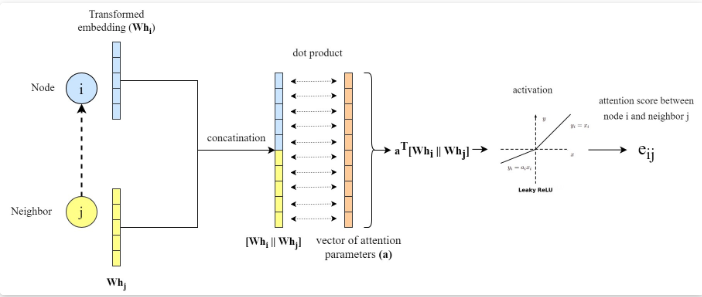

The understanding of GAT and its implementation were inspired by : [First reference](https://petar-v.com/GAT/) / [Second reference](https://epichka.com/blog/2023/gat-paper-explained/)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Final evaluation after training


def compute_prf(pos_pred, neg_pred):
    y_true = torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)])
    y_score = torch.cat([pos_pred, neg_pred])
    y_pred = (y_score > 0).float()

    # Ensure inputs are valid (e.g., not all ones or zeros)
    try:
        precision = precision_score(y_true.cpu(), y_pred.cpu())
        recall = recall_score(y_true.cpu(), y_pred.cpu())
        f1 = f1_score(y_true.cpu(), y_pred.cpu())
        return precision, recall, f1
    except Exception as e:
        print("Error in compute_prf:", e)
        return None


In [ ]:
import networkx as nx
from torch_geometric.utils import from_networkx, train_test_split_edges
from torch_geometric.utils import negative_sampling
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Load and preprocess Twitter graph
G = nx.read_edgelist("twitter_combined.txt", create_using=nx.DiGraph(), nodetype=int)
G = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()
G = G.subgraph(list(G.nodes)[:15000]).copy()
#  degree/PageRank
pagerank = nx.pagerank(G)
max_deg = max(dict(G.degree()).values())
for node in G.nodes:
    degree = G.degree[node] / max_deg
    pr = pagerank[node]
    G.nodes[node]["x"] = [degree, pr]


# Convert to PyG Data

data = from_networkx(G)
data.x = data.x.float()
data = train_test_split_edges(data)  # for link prediction


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=1):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)

    def encode(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gat2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
def contrastive_loss(z, pos_edge_index, neg_edge_index):
    pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    return -F.logsigmoid(pos_score).mean() - F.logsigmoid(-neg_score).mean()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=data.x.size(1), hidden_channels=32).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes)
    loss = contrastive_loss(z, data.train_pos_edge_index, neg_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_edge_index = data.test_pos_edge_index
    neg_edge_index = data.test_neg_edge_index
    pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))])
    y_score = torch.cat([pos_pred, neg_pred])
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y_true.cpu(), y_score.cpu())
for epoch in range(1, 351):
    loss = train()
    if epoch % 20 == 0:
        auc = test()
        model.eval()
        with torch.no_grad():
            z = model.encode(data.x, data.train_pos_edge_index)
            pos_edge_index = data.test_pos_edge_index
            neg_edge_index = data.test_neg_edge_index
            pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
            neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
            precision, recall, f1 = compute_prf(pos_pred, neg_pred)

        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 020, Loss: 1.2407, AUC: 0.7491, Precision: 0.6368, Recall: 0.9202, F1: 0.7528
Epoch 040, Loss: 1.1911, AUC: 0.7785, Precision: 0.6341, Recall: 0.9360, F1: 0.7560
Epoch 060, Loss: 1.1730, AUC: 0.7869, Precision: 0.6356, Recall: 0.9292, F1: 0.7548
Epoch 080, Loss: 1.1679, AUC: 0.7912, Precision: 0.6342, Recall: 0.9275, F1: 0.7533
Epoch 100, Loss: 1.1657, AUC: 0.7931, Precision: 0.6347, Recall: 0.9283, F1: 0.7540
Epoch 120, Loss: 1.1623, AUC: 0.7955, Precision: 0.6341, Recall: 0.9271, F1: 0.7531
Epoch 140, Loss: 1.1620, AUC: 0.7972, Precision: 0.6344, Recall: 0.9270, F1: 0.7533
Epoch 160, Loss: 1.1594, AUC: 0.7991, Precision: 0.6343, Recall: 0.9282, F1: 0.7536
Epoch 180, Loss: 1.1574, AUC: 0.8001, Precision: 0.6345, Recall: 0.9280, F1: 0.7537
Epoch 200, Loss: 1.1581, AUC: 0.8016, Precision: 0.6343, Recall: 0.9293, F1: 0.7540
Epoch 220, Loss: 1.1554, AUC: 0.8007, Precision: 0.6356, Recall: 0.9262, F1: 0.7539
Epoch 240, Loss: 1.1554, AUC: 0.8035, Precision: 0.6344, Recall: 0.9319, F1:

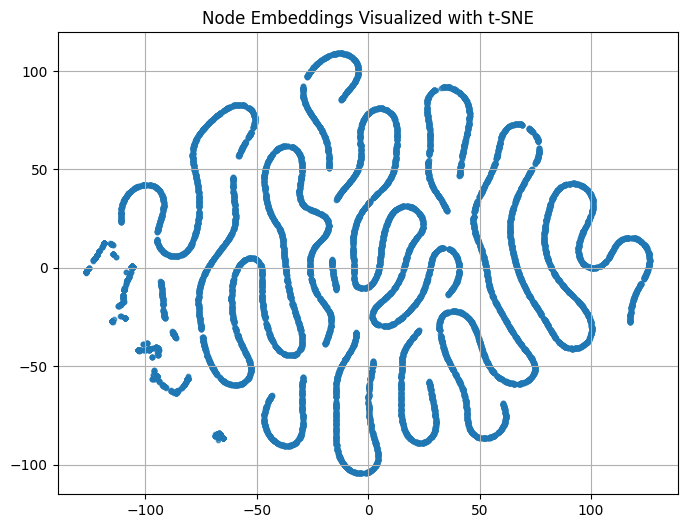

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
z = model.encode(data.x, data.train_pos_edge_index).cpu().detach()
z_2d = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10, alpha=0.7)
plt.title("Node Embeddings Visualized with t-SNE")
plt.grid(True)
plt.show()



*  **What is the defined task here ?**

It's link prediction as well so the goal is to predict if an edge should exist between two nodes.

---


*   **Why choose the twitter graph to apply link prediction through GAT?**

We chose Graph Attention Networks (GAT) because the Twitter graph is highly sparse, large, and directed, with many users having very different numbers of connections (followers/following). It's important because not all Twitter's connections are equally important.

We also chose the link prediction task because the Twitter graph is dynamic and constantly evolving. Predicting new potential connections ( who might follow whom next) is a very realistic and valuable application of graph learning on social networks.

---



* **What is the aggregation function in this case?**

The aggregation function in GAT is a weighted sum of neighboring node features. Unlike GCN, the weights are learned through an attention mechanism that assigns more importance to certain neighbors. These attention scores are computed and normalized using a softmax function. The final result is passed through a non-linear activation like ELU.


---
* **Result analysis**

The model consistently improves after training with GAT, achieving an AUC of ~0.805 and a final loss of about 1.15. These results imply a strong ability to differentiate between real and fake links especially considering the complexity of the Twitter graph.

With precision and recall being steady at 0.635 and 0.93, respectively, the F1-score is high and well-balanced at about 0.755. This shows that although there is still need to increase the precision, the model predicts links with good reliability and captures the majority of true positives.

The t-SNE plot of the node embeddings shows that the model has learned expressive node representations. Adding dropout to the GAT model helped improve generalization by reducing overfitting. The results confirm that attention-based aggregation, leads to an efficient learning in the context of a link prediction task when paired with informative variables such as node degree and PageRank.






# GrapheSAGE : Second approach

To further our analysis on the Twitter graph, we also implemented a **GraphSAGE** model. GraphSAGE is a popular extension of GNNs that learns node embeddings by sampling and aggregating features from a node's local neighborhood, enabling **inductive learning** on large-scale graphs. This makes it appropriate for the Twitter graph, which is directed and considerably large.

As with the GAT experiment, we focused on the largest weakly connected component and restricted the graph to 15,000 nodes for computational efficiency. Nodes were enriched with structured features—normalized degree and PageRank

Our GraphSAGE architecture consists of two layers of SAGEConv, which aggregate information from neighbors using mean pooling followed by a non-linear transformation. We also tested the model with and without dropout, and unlike with GAT, we observed that dropout did not lead to better performance in this case. Removing dropout slightly improved the model's predictive stability.


The model was trained using contrastive loss for the link prediction task, and performance was evaluated with the same metrics to let us compare between the models.

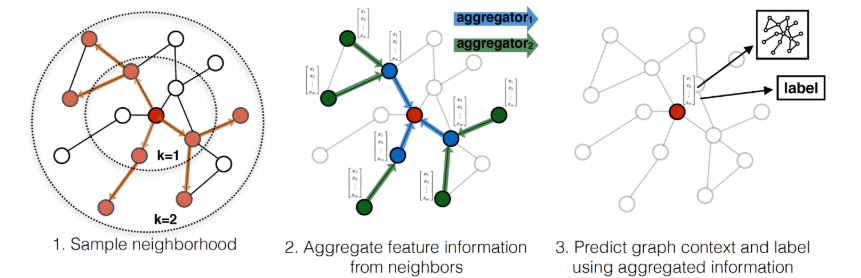

The understanding of GAT and its implementation were inspired by :[First reference](https://snap.stanford.edu/graphsage/) and [Second reference](https://www.activeloop.ai/resources/glossary/graph-sage/)




In [ ]:
import networkx as nx
from torch_geometric.utils import from_networkx, train_test_split_edges
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling

# Load Twitter graph
G = nx.read_edgelist("twitter_combined.txt", create_using=nx.DiGraph(), nodetype=int)
G = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()

# reduce size to prevent memory crash
G = G.subgraph(list(G.nodes)[:15000]).copy()
pagerank = nx.pagerank(G)
max_deg = max(dict(G.degree()).values())
for node in G.nodes:
    degree = G.degree[node] / max_deg
    pr = pagerank[node]
    G.nodes[node]["x"] = [degree, pr]


# Convert to PyG
data = from_networkx(G)
data.x = data.x.float()
data = train_test_split_edges(data)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)

    def encode(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.sage2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

def contrastive_loss(z, pos_edge_index, neg_edge_index):
    pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    return -F.logsigmoid(pos_score).mean() - F.logsigmoid(-neg_score).mean()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(in_channels=data.x.size(1), hidden_channels=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes)
    loss = contrastive_loss(z, data.train_pos_edge_index, neg_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_edge_index = data.test_pos_edge_index
    neg_edge_index = data.test_neg_edge_index
    pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))])
    y_score = torch.cat([pos_pred, neg_pred])
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y_true.cpu(), y_score.cpu())
for epoch in range(1, 301):
    loss = train()
    if epoch % 20 == 0:
        auc = test()
        model.eval()
        with torch.no_grad():
            z = model.encode(data.x, data.train_pos_edge_index)
            pos_edge_index = data.test_pos_edge_index
            neg_edge_index = data.test_neg_edge_index
            pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
            neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
            precision, recall, f1 = compute_prf(pos_pred, neg_pred)

        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 020, Loss: 1.4316, AUC: 0.7194, Precision: 0.4999, Recall: 0.9997, F1: 0.6665
Epoch 040, Loss: 1.3328, AUC: 0.8386, Precision: 0.5205, Recall: 0.9939, F1: 0.6832
Epoch 060, Loss: 1.1550, AUC: 0.8202, Precision: 0.6265, Recall: 0.9387, F1: 0.7515
Epoch 080, Loss: 1.1174, AUC: 0.8546, Precision: 0.6342, Recall: 0.9388, F1: 0.7570
Epoch 100, Loss: 1.1017, AUC: 0.8530, Precision: 0.6382, Recall: 0.9394, F1: 0.7601
Epoch 120, Loss: 1.0878, AUC: 0.8567, Precision: 0.6412, Recall: 0.9425, F1: 0.7632
Epoch 140, Loss: 1.0761, AUC: 0.8681, Precision: 0.6404, Recall: 0.9513, F1: 0.7655
Epoch 160, Loss: 1.0674, AUC: 0.8707, Precision: 0.6456, Recall: 0.9495, F1: 0.7686
Epoch 180, Loss: 1.0594, AUC: 0.8764, Precision: 0.6429, Recall: 0.9537, F1: 0.7681
Epoch 200, Loss: 1.0552, AUC: 0.8793, Precision: 0.6445, Recall: 0.9540, F1: 0.7693
Epoch 220, Loss: 1.0502, AUC: 0.8792, Precision: 0.6483, Recall: 0.9510, F1: 0.7710
Epoch 240, Loss: 1.0463, AUC: 0.8811, Precision: 0.6493, Recall: 0.9506, F1:

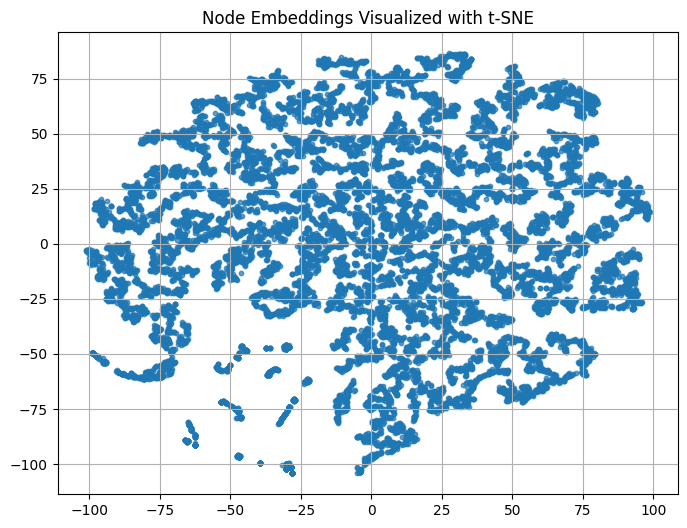

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
z = model.encode(data.x, data.train_pos_edge_index).cpu().detach()
z_2d = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10, alpha=0.7)
plt.title("Node Embeddings Visualized with t-SNE")
plt.grid(True)
plt.show()

* **What is the aggregation function used here?**

The aggregation is based on the mean of the neighbors' embeddings, followed by concatenation with the node's own embedding, then a transformation and activation.



---
* **Result analysis**

Using GraphSAGE with structured features (degree + PageRank) on the Twitter graph, we observed consistent improvements across training epochs. The AUC score steadily increased, reaching 0.8869, and the contrastive loss decreased to around 1.03 by epoch 300. Precision and recall also balanced well, with a final F1-score of 0.7717, showing strong predictive performance.

When compared to the earlier GAT model, which reached an AUC of around 0.8049 and F1-score of 0.7559, GraphSAGE outperforms GAT in terms of all evaluation metrics. This implies that GraphSAGE performed better in this challenge by utilizing the structured features and neighborhood information.

Looking at the t-SNE plot of the GraphSAGE embeddings, we can see that the nodes are well spread out with some clear groupings. This means the model has learned to represent different types of nodes in a meaningful way. The clusters show that similar nodes (in terms of their connections) end up close together, which is a good sign. It supports the strong performance we saw in the metrics and shows that GraphSAGE is doing a good job at understanding the structure of the graph.

Unlike GAT, where adding dropout slightly improved generalization, we noticed that applying dropout in GraphSAGE didn't help and even slightly degraded performance. The best results were obtained without it, indicating that GraphSAGE's aggregation strategy is inherently more robust in this setting.

Overall, when structured node information are present, GraphSAGE not only produces superior link prediction accuracy but also shows better stability and learning efficiency on the Twitter graph.


# Trying The GraphSAGE On Facebook Graph

Since GraphSAGE gave us excellent results on the twitter network , let's see if shows an improvement compared to GCN for the Facebook's graph

In [ ]:
import networkx as nx
from torch_geometric.utils import from_networkx, train_test_split_edges
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling

# Load Twitter graph
G = nx.read_edgelist("facebook_combined.txt", create_using=nx.DiGraph(), nodetype=int)
G = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()


pagerank = nx.pagerank(G)
max_deg = max(dict(G.degree()).values())
for node in G.nodes:
    degree = G.degree[node] / max_deg
    pr = pagerank[node]
    G.nodes[node]["x"] = [degree, pr]


# Convert to PyG
data = from_networkx(G)
data.x = data.x.float()
data = train_test_split_edges(data)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)

    def encode(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)

        x = self.sage2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

def contrastive_loss(z, pos_edge_index, neg_edge_index):
    pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    return -F.logsigmoid(pos_score).mean() - F.logsigmoid(-neg_score).mean()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(in_channels=data.x.size(1), hidden_channels=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes)
    loss = contrastive_loss(z, data.train_pos_edge_index, neg_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_edge_index = data.test_pos_edge_index
    neg_edge_index = data.test_neg_edge_index
    pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))])
    y_score = torch.cat([pos_pred, neg_pred])
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y_true.cpu(), y_score.cpu())
for epoch in range(1, 351):
    loss = train()

    if epoch % 20 == 0:
        auc = test()
        model.eval()
        with torch.no_grad():
            z = model.encode(data.x, data.train_pos_edge_index)
            pos_edge_index = data.test_pos_edge_index
            neg_edge_index = data.test_neg_edge_index
            pos_pred = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
            neg_pred = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
            precision, recall, f1 = compute_prf(pos_pred, neg_pred)

        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 020, Loss: 1.4129, AUC: 0.7236, Precision: 0.4999, Recall: 0.9996, F1: 0.6665
Epoch 040, Loss: 1.3401, AUC: 0.7712, Precision: 0.5002, Recall: 0.9993, F1: 0.6666
Epoch 060, Loss: 1.2139, AUC: 0.8097, Precision: 0.5746, Recall: 0.9677, F1: 0.7211
Epoch 080, Loss: 1.1034, AUC: 0.8296, Precision: 0.6436, Recall: 0.9356, F1: 0.7626
Epoch 100, Loss: 1.0807, AUC: 0.8527, Precision: 0.6539, Recall: 0.9408, F1: 0.7715
Epoch 120, Loss: 1.0593, AUC: 0.8680, Precision: 0.6455, Recall: 0.9433, F1: 0.7664
Epoch 140, Loss: 1.0359, AUC: 0.8838, Precision: 0.6386, Recall: 0.9525, F1: 0.7646
Epoch 160, Loss: 1.0180, AUC: 0.8878, Precision: 0.6467, Recall: 0.9484, F1: 0.7690
Epoch 180, Loss: 1.0127, AUC: 0.8929, Precision: 0.6469, Recall: 0.9525, F1: 0.7705
Epoch 200, Loss: 1.0071, AUC: 0.8953, Precision: 0.6464, Recall: 0.9531, F1: 0.7704
Epoch 220, Loss: 1.0030, AUC: 0.8975, Precision: 0.6458, Recall: 0.9546, F1: 0.7704
Epoch 240, Loss: 0.9996, AUC: 0.8982, Precision: 0.6474, Recall: 0.9548, F1:

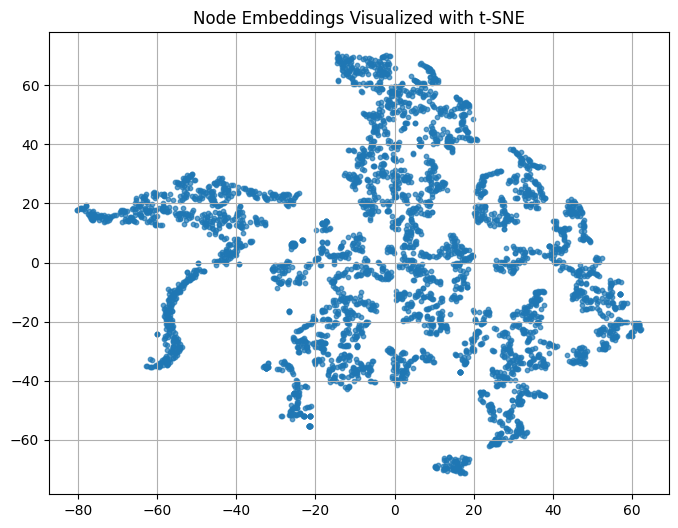

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
z = model.encode(data.x, data.train_pos_edge_index).cpu().detach()
z_2d = TSNE(n_components=2).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10, alpha=0.7)
plt.title("Node Embeddings Visualized with t-SNE")
plt.grid(True)
plt.show()

**Result Analysis**

When applying GraphSAGE to the Facebook graph, we notice a clear improvement over the results obtained with the GCN model. The AUC score with GraphSAGE reaches up to 0.9031, compared to a maximum of 0.8605 with GCN. The F1-score also improves slightly, from around 0.76 with GCN to around 0.77 with GraphSAGE, showing better overall performance on the link prediction task.

Precision and recall are both slightly higher with GraphSAGE, and the contrastive loss decreases more steadily, indicating that the model learns more effectively. The t-SNE visualization also shows more structured and dense clusters compared to GCN, suggesting that GraphSAGE produces more meaningful node embeddings.

In summary, for the Facebook graph, GraphSAGE outperforms GCN in terms of AUC, F1-score, and embedding quality. This suggests that GraphSAGE's approach of sampling and aggregating neighborhood information in a more flexible way helps the model better capture the graph structure.

After the in-class presentation, I extended the analysis by systematically comparing multiple Graph Neural Network (GNN) approaches on two real-world datasets: the Facebook graph and the Twitter graph. The objective was to evaluate model performance using two key metrics: AUC (Area Under Curve) and F1 Score.Across both datasets, GraphSAGE consistently outperformed other models in both AUC and F1 Score, making it the most effective approach among those tested

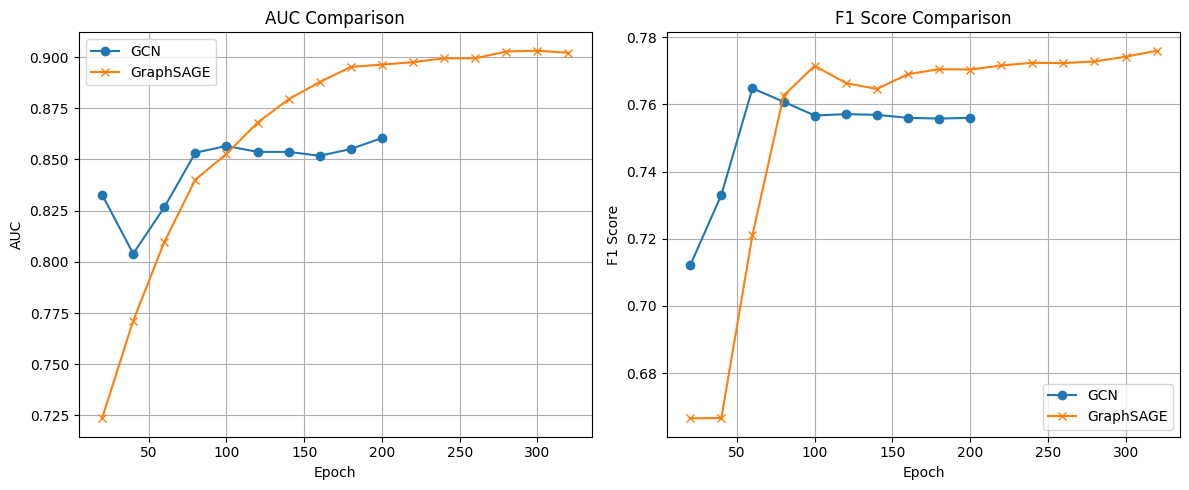

In [2]:
import matplotlib.pyplot as plt

# Replace these with the actual values from your logs
epochs_gcn = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

auc_gcn = [
    0.8328, 0.8040, 0.8266, 0.8533, 0.8566,
    0.8537, 0.8537, 0.8518, 0.8551, 0.8605
]

f1_gcn = [
    0.7121, 0.7331, 0.7648, 0.7608, 0.7567,
    0.7571, 0.7569, 0.7560, 0.7558, 0.7560
]


epochs_sage = list(range(20, 341, 20))
auc_sage = [0.7236, 0.7712, 0.8097, 0.8402, 0.8527, 0.8680, 0.8794, 0.8878, 0.8952,
            0.8963, 0.8975, 0.8994, 0.8994, 0.9027, 0.9031, 0.9021]
f1_sage = [0.6665, 0.6666, 0.7211, 0.7626, 0.7715, 0.7664, 0.7646, 0.7690,
           0.7705, 0.7704, 0.7716, 0.7724, 0.7723, 0.7728, 0.7742, 0.7760]
epochs_sage = epochs_sage[:16]  # Trim to match length of auc_sage/f1_sage

# Plot AUC
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_gcn, auc_gcn, label="GCN", marker='o')
plt.plot(epochs_sage, auc_sage, label="GraphSAGE", marker='x')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC Comparison")
plt.legend()
plt.grid(True)

# Plot F1
plt.subplot(1, 2, 2)
plt.plot(epochs_gcn, f1_gcn, label="GCN", marker='o')
plt.plot(epochs_sage, f1_sage, label="GraphSAGE", marker='x')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


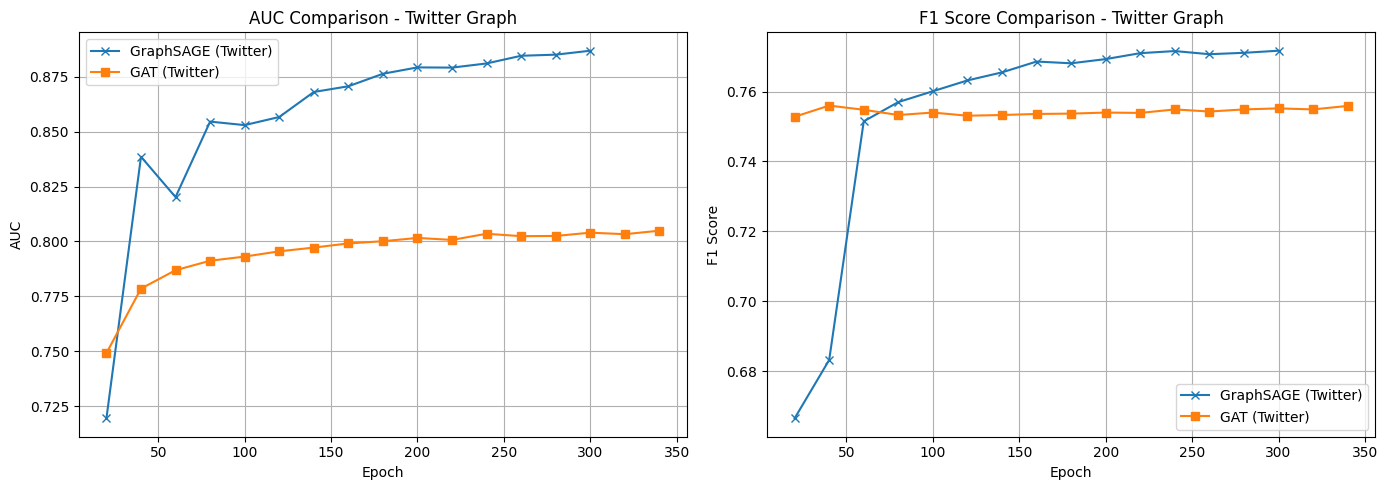

In [3]:
import matplotlib.pyplot as plt

# === Twitter Graph ===
# GAT (Twitter)
epochs_gat_tw = list(range(20, 341, 20))
auc_gat_tw = [
    0.7491, 0.7785, 0.7869, 0.7912, 0.7931, 0.7955, 0.7972, 0.7991, 0.8001, 0.8016,
    0.8007, 0.8035, 0.8024, 0.8025, 0.8040, 0.8033, 0.8049
]
f1_gat_tw = [
    0.7528, 0.7560, 0.7548, 0.7533, 0.7540, 0.7531, 0.7533, 0.7536, 0.7537, 0.7540,
    0.7539, 0.7549, 0.7543, 0.7549, 0.7552, 0.7549, 0.7559
]

# GraphSAGE (Twitter)
epochs_sage_tw = list(range(20, 301, 20))
auc_sage_tw = [
    0.7194, 0.8386, 0.8202, 0.8546, 0.8530, 0.8567, 0.8681, 0.8707, 0.8764, 0.8793,
    0.8792, 0.8811, 0.8846, 0.8851, 0.8869
]
f1_sage_tw = [
    0.6665, 0.6832, 0.7515, 0.7570, 0.7601, 0.7632, 0.7655, 0.7686, 0.7681, 0.7693,
    0.7710, 0.7716, 0.7707, 0.7711, 0.7717
]
epochs_sage_tw = epochs_sage_tw[:len(auc_sage_tw)]  # safety trim

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# AUC
axs[0].plot(epochs_sage_tw, auc_sage_tw, label="GraphSAGE (Twitter)", marker='x')
axs[0].plot(epochs_gat_tw, auc_gat_tw, label="GAT (Twitter)", marker='s')
axs[0].set_title("AUC Comparison - Twitter Graph")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("AUC")
axs[0].legend()
axs[0].grid(True)

# F1 Score
axs[1].plot(epochs_sage_tw, f1_sage_tw, label="GraphSAGE (Twitter)", marker='x')
axs[1].plot(epochs_gat_tw, f1_gat_tw, label="GAT (Twitter)", marker='s')
axs[1].set_title("F1 Score Comparison - Twitter Graph")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("F1 Score")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
